In [ ]:
!pip install optuna

     |████████████████████████████████| 296kB 18.7MB/s 
     |████████████████████████████████| 81kB 10.8MB/s 
     |████████████████████████████████| 163kB 48.5MB/s 
     |████████████████████████████████| 143kB 47.7MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
     |████████████████████████████████| 112kB 58.0MB/s 
     |████████████████████████████████| 81kB 11.6MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=84f2282691e71b2ebc10f60d6555792a6899c0bec40a63b31ba516f1563552c4
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [ ]:
from glob import glob
from keras import optimizers
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, models
import cv2
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import optuna
import os

In [ ]:
path = glob("kyogoku/*/")
data = []
label = [] 
total = 0
x = 32
y = 18

def append_data(directory, total):
  files = os.listdir(directory)
  print(files)
  for image in files:
    if image.endswith(".jpg"):
      image = cv2.imread(directory + image)
      image = cv2.resize(image, (x, y))
      image_gs = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      image_gs = image_gs.flatten()
      data.append(image_gs)
      label.append(total)

for i in path:
    append_data(i, total)
    total += 1

['ohhara_008.jpg', 'yamaoka_177.jpg', 'kurita_167.jpg', 'tomii_166.jpg', 'tomii_167.jpg', 'tomii_168.jpg', 'tomii_169.jpg', 'tomii_170.jpg', 'tanimura_054.jpg', 'tanimura_056.jpg', 'ohhara_013.jpg', 'tomii_171.jpg', 'ohhara_014.jpg', 'ohhara_015.jpg', 'tanimura_057.jpg', 'tanimura_058.jpg', 'tanimura_059.jpg', 'tomii_172.jpg', 'tomii_173.jpg', 'ohhara_016.jpg', 'tomii_174.jpg', 'tomii_175.jpg', 'tomii_176.jpg', 'tomii_177.jpg', 'tomii_178.jpg', 'tomii_179.jpg', 'tomii_180.jpg', 'tomii_181.jpg', 'tomii_182.jpg', 'tanimura_061.jpg', 'tanimura_062.jpg', 'tomii_183.jpg', 'tomii_184.jpg', 'tanimura_109.jpg', 'tanimura_110.jpg', 'tomii_185.jpg', 'tomii_186.jpg', 'tomii_187.jpg', 'tomii_188.jpg', 'tanimura_111.jpg', 'tomii_189.jpg', 'tomii_191.jpg', 'tomii_192.jpg', 'tomii_193.jpg', 'tomii_194.jpg', 'kurita_168.jpg', 'kurita_169.jpg', 'tomii_195.jpg', 'tomii_196.jpg', 'tomii_197.jpg', 'tomii_198.jpg', 'tomii_199.jpg', 'ohhara_024.jpg', 'kurita_170.jpg', 'kaibara_179.jpg', 'kaibara_180.jpg', '

In [ ]:
data = np.array(data, dtype=np.float64)
label = np.array(label, dtype=np.float64)

train_data, test_data, train_label, test_label = train_test_split(data, label, random_state=1, stratify=label, test_size=0.1)

train_data = train_data.reshape((len(train_data)), x, y, 1)
test_data = test_data.reshape((len(test_data)), x, y, 1)

train_data /= 255
test_data /= 255

train_label = to_categorical(train_label, num_classes=2)
test_label = to_categorical(test_label, num_classes=2)
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(1152, 32, 18, 1)
(1152, 2)
(129, 32, 18, 1)
(129, 2)


In [ ]:
model_list = []
result_list = []

def create_model(layer, filter_size, filters, activation, dropout_rate):
  model = model = models.Sequential()
  model.add(layers.Conv2D(16, (filter_size, filter_size), activation="relu", padding="same", input_shape=(x, y, 1)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2), strides=(1, 1)))
  model.add(layers.Flatten())
  for i in range(layer):
    model.add(layers.Dense(filters, activation=activation))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate=dropout_rate))
  model.add(layers.Dense(2, activation="softmax"))
  return model

def optimisation(choice):
  K.clear_session()
  layer = choice.suggest_int("layer", 1, 8)
  filter_size = choice.suggest_int("filter_size", 3, 7, 2)
  filters = choice.suggest_int("filters", 32, 256, 32)
  optimizer = choice.suggest_categorical("optimizer", ["SGD", "RMSprop", "Adagrad", "Adadelta", "Adam", "Adamax", "Nadam"])
  activation = choice.suggest_categorical("activation", ["softmax", "elu", "selu", "softplus", "softsign", "relu", "tanh", "sigmoid", "hard_sigmoid", "linear"])
  dropout_rate = choice.suggest_uniform("dropout_rate", 0.25, 0.5)
  model = create_model(layer, filter_size, filters, activation, dropout_rate)
  model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  result = model.fit(train_data, train_label, batch_size=batchsize, epochs=epoch, verbose=2, validation_data=(test_data, test_label))
  model_list.append(model)
  result_list.append(result)
  return 1 - result.history["val_accuracy"][-1]

In [ ]:
batchsize = train_data.shape[0] // 64
print(batchsize)
epoch = 16
study = optuna.create_study()
study.optimize(optimisation, n_trials=256)

[I 2021-03-17 07:48:30,688] A new study created in memory with name: no-name-ece1ee5a-f5b2-4dbd-95b4-462142f6e289


18
Epoch 1/16
64/64 - 34s - loss: 0.9493 - accuracy: 0.5720 - val_loss: 0.4165 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5846 - accuracy: 0.7266 - val_loss: 0.3496 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4545 - accuracy: 0.8056 - val_loss: 0.3242 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.4227 - accuracy: 0.8394 - val_loss: 0.3188 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3879 - accuracy: 0.8472 - val_loss: 0.3361 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3741 - accuracy: 0.8637 - val_loss: 0.3126 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3362 - accuracy: 0.8681 - val_loss: 0.2968 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3225 - accuracy: 0.8906 - val_loss: 0.2682 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3078 - accuracy: 0.8845 - val_loss: 0.2220 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2850 - accuracy: 0.8993 - val_loss: 0.2183 - val_accuracy: 0.9070
Epoch 11/16
64/

[I 2021-03-17 07:49:14,938] Trial 0 finished with value: 0.031007766723632812 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.3336820860350168}. Best is trial 0 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.9171 - accuracy: 0.6024 - val_loss: 0.3760 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5590 - accuracy: 0.7595 - val_loss: 0.3297 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.5109 - accuracy: 0.8099 - val_loss: 0.3356 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.4323 - accuracy: 0.8498 - val_loss: 0.3481 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.4338 - accuracy: 0.8620 - val_loss: 0.3388 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.4195 - accuracy: 0.8681 - val_loss: 0.3303 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.4074 - accuracy: 0.8828 - val_loss: 0.3310 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3958 - accuracy: 0.8767 - val_loss: 0.3256 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3810 - accuracy: 0.8845 - val_loss: 0.3202 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.3926 - accuracy: 0.8750 - val_loss: 0.3186 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:49:21,652] Trial 1 finished with value: 0.10077518224716187 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adam', 'activation': 'sigmoid', 'dropout_rate': 0.46021739052080035}. Best is trial 0 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9814 - accuracy: 0.5278 - val_loss: 0.5945 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.7932 - accuracy: 0.6016 - val_loss: 0.5253 - val_accuracy: 0.8915
Epoch 3/16
64/64 - 0s - loss: 0.7445 - accuracy: 0.6181 - val_loss: 0.6174 - val_accuracy: 0.7519
Epoch 4/16
64/64 - 0s - loss: 0.6588 - accuracy: 0.6484 - val_loss: 0.6588 - val_accuracy: 0.6434
Epoch 5/16
64/64 - 0s - loss: 0.6476 - accuracy: 0.6762 - val_loss: 0.5182 - val_accuracy: 0.7907
Epoch 6/16
64/64 - 0s - loss: 0.5848 - accuracy: 0.7109 - val_loss: 0.6134 - val_accuracy: 0.6744
Epoch 7/16
64/64 - 0s - loss: 0.5761 - accuracy: 0.7101 - val_loss: 0.6501 - val_accuracy: 0.6357
Epoch 8/16
64/64 - 0s - loss: 0.5374 - accuracy: 0.7509 - val_loss: 0.6069 - val_accuracy: 0.6589
Epoch 9/16
64/64 - 0s - loss: 0.5435 - accuracy: 0.7283 - val_loss: 0.5892 - val_accuracy: 0.7209
Epoch 10/16
64/64 - 0s - loss: 0.5348 - accuracy: 0.7509 - val_loss: 0.5038 - val_accuracy: 0.7597
Epoch 11/16
64/64 -

[I 2021-03-17 07:49:25,875] Trial 2 finished with value: 0.1627907156944275 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adagrad', 'activation': 'softsign', 'dropout_rate': 0.3539065326932095}. Best is trial 0 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 4s - loss: 0.8518 - accuracy: 0.5998 - val_loss: 0.4919 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 1s - loss: 0.5409 - accuracy: 0.7500 - val_loss: 0.3692 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 1s - loss: 0.4651 - accuracy: 0.8160 - val_loss: 0.3592 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 1s - loss: 0.4081 - accuracy: 0.8637 - val_loss: 0.3293 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3820 - accuracy: 0.8750 - val_loss: 0.3226 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3692 - accuracy: 0.8819 - val_loss: 0.3157 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 1s - loss: 0.3617 - accuracy: 0.8880 - val_loss: 0.2822 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 1s - loss: 0.3277 - accuracy: 0.8967 - val_loss: 0.2589 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 1s - loss: 0.3275 - accuracy: 0.8898 - val_loss: 0.2329 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.3166 - accuracy: 0.8898 - val_loss: 0.1911 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:49:37,675] Trial 3 finished with value: 0.05426359176635742 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 128, 'optimizer': 'Nadam', 'activation': 'relu', 'dropout_rate': 0.283193838504457}. Best is trial 0 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.8484 - accuracy: 0.6224 - val_loss: 0.4821 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5744 - accuracy: 0.7448 - val_loss: 0.3967 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4828 - accuracy: 0.7943 - val_loss: 0.3356 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.4053 - accuracy: 0.8542 - val_loss: 0.3231 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3879 - accuracy: 0.8637 - val_loss: 0.3301 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.4024 - accuracy: 0.8733 - val_loss: 0.3221 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3708 - accuracy: 0.8802 - val_loss: 0.3197 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3640 - accuracy: 0.8845 - val_loss: 0.3189 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3681 - accuracy: 0.8967 - val_loss: 0.3761 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.3583 - accuracy: 0.8924 - val_loss: 0.3777 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:49:44,279] Trial 4 finished with value: 0.10077518224716187 and parameters: {'layer': 7, 'filter_size': 7, 'filters': 160, 'optimizer': 'SGD', 'activation': 'tanh', 'dropout_rate': 0.33770498922070513}. Best is trial 0 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.9304 - accuracy: 0.5790 - val_loss: 0.3641 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5679 - accuracy: 0.7378 - val_loss: 0.3345 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4718 - accuracy: 0.7934 - val_loss: 0.3282 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3986 - accuracy: 0.8446 - val_loss: 0.3226 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3804 - accuracy: 0.8672 - val_loss: 0.3150 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3811 - accuracy: 0.8481 - val_loss: 0.3024 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3414 - accuracy: 0.8741 - val_loss: 0.2972 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3342 - accuracy: 0.8845 - val_loss: 0.2791 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3284 - accuracy: 0.8889 - val_loss: 0.2694 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.3216 - accuracy: 0.8819 - val_loss: 0.2555 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:49:49,881] Trial 5 finished with value: 0.062015533447265625 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 160, 'optimizer': 'SGD', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4599819153252726}. Best is trial 0 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.8744 - accuracy: 0.6068 - val_loss: 0.5963 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5599 - accuracy: 0.7474 - val_loss: 0.3650 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4677 - accuracy: 0.8177 - val_loss: 0.3285 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.4427 - accuracy: 0.8559 - val_loss: 0.3277 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.4047 - accuracy: 0.8655 - val_loss: 0.3238 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3729 - accuracy: 0.8750 - val_loss: 0.3107 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3980 - accuracy: 0.8741 - val_loss: 0.3369 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3637 - accuracy: 0.8837 - val_loss: 0.3168 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3631 - accuracy: 0.8845 - val_loss: 0.3234 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.3686 - accuracy: 0.8863 - val_loss: 0.3291 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:49:56,462] Trial 6 finished with value: 0.10077518224716187 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.43943934245926486}. Best is trial 0 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8781 - accuracy: 0.5972 - val_loss: 0.5537 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5443 - accuracy: 0.7387 - val_loss: 0.3580 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4536 - accuracy: 0.8090 - val_loss: 0.3420 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3848 - accuracy: 0.8533 - val_loss: 0.2773 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3475 - accuracy: 0.8698 - val_loss: 0.2481 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3541 - accuracy: 0.8663 - val_loss: 0.2879 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3138 - accuracy: 0.8915 - val_loss: 0.2923 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3449 - accuracy: 0.8724 - val_loss: 0.3207 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.3113 - accuracy: 0.8898 - val_loss: 0.2708 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2971 - accuracy: 0.8906 - val_loss: 0.1871 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:50:01,609] Trial 7 finished with value: 0.07751935720443726 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adam', 'activation': 'softsign', 'dropout_rate': 0.40352728942027755}. Best is trial 0 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9070 - accuracy: 0.6120 - val_loss: 0.3736 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5934 - accuracy: 0.7205 - val_loss: 0.3430 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4739 - accuracy: 0.8082 - val_loss: 0.3399 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.4220 - accuracy: 0.8472 - val_loss: 0.3313 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.4016 - accuracy: 0.8681 - val_loss: 0.3237 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3654 - accuracy: 0.8854 - val_loss: 0.3247 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3596 - accuracy: 0.8845 - val_loss: 0.3208 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3611 - accuracy: 0.8915 - val_loss: 0.3213 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3353 - accuracy: 0.8984 - val_loss: 0.3194 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.3299 - accuracy: 0.9002 - val_loss: 0.3215 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:50:07,128] Trial 8 finished with value: 0.10077518224716187 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 32, 'optimizer': 'SGD', 'activation': 'relu', 'dropout_rate': 0.39086370206641274}. Best is trial 0 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.8845 - accuracy: 0.5729 - val_loss: 0.4978 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5775 - accuracy: 0.7196 - val_loss: 0.3974 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4482 - accuracy: 0.8177 - val_loss: 0.3779 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3692 - accuracy: 0.8628 - val_loss: 0.3153 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3504 - accuracy: 0.8715 - val_loss: 0.3381 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3622 - accuracy: 0.8880 - val_loss: 0.2743 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3347 - accuracy: 0.8924 - val_loss: 0.3206 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3120 - accuracy: 0.8837 - val_loss: 0.4507 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3046 - accuracy: 0.8924 - val_loss: 0.7839 - val_accuracy: 0.4031
Epoch 10/16
64/64 - 0s - loss: 0.2807 - accuracy: 0.8967 - val_loss: 0.4582 - val_accuracy: 0.7752
Epoch 11/16
64/64 -

[I 2021-03-17 07:50:13,381] Trial 9 finished with value: 0.10077518224716187 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 64, 'optimizer': 'RMSprop', 'activation': 'softsign', 'dropout_rate': 0.3752590110304798}. Best is trial 0 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7467 - accuracy: 0.6597 - val_loss: 0.6227 - val_accuracy: 0.8837
Epoch 2/16
64/64 - 0s - loss: 0.4227 - accuracy: 0.8177 - val_loss: 0.3736 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3252 - accuracy: 0.8759 - val_loss: 0.3100 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2663 - accuracy: 0.8976 - val_loss: 0.2979 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2025 - accuracy: 0.9210 - val_loss: 0.2882 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.1857 - accuracy: 0.9349 - val_loss: 0.3106 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1567 - accuracy: 0.9436 - val_loss: 0.2339 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1240 - accuracy: 0.9549 - val_loss: 0.2510 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1201 - accuracy: 0.9583 - val_loss: 0.2508 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0970 - accuracy: 0.9722 - val_loss: 0.1790 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:50:17,811] Trial 10 finished with value: 0.038759708404541016 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.28505169254100526}. Best is trial 0 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8740 - accuracy: 0.6806 - val_loss: 0.3245 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4110 - accuracy: 0.8307 - val_loss: 0.2994 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.2706 - accuracy: 0.9089 - val_loss: 0.2908 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2248 - accuracy: 0.9288 - val_loss: 0.2753 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.1804 - accuracy: 0.9436 - val_loss: 0.2819 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.1446 - accuracy: 0.9575 - val_loss: 0.2148 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1228 - accuracy: 0.9670 - val_loss: 0.2282 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1019 - accuracy: 0.9757 - val_loss: 0.2062 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.0792 - accuracy: 0.9792 - val_loss: 0.1370 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.0675 - accuracy: 0.9835 - val_loss: 0.0871 - val_accuracy: 0.9922
Epoch 11/16
64/64 -

[I 2021-03-17 07:50:21,741] Trial 11 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.25307034596426925}. Best is trial 0 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8007 - accuracy: 0.6163 - val_loss: 0.3805 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4845 - accuracy: 0.7734 - val_loss: 0.3485 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3699 - accuracy: 0.8516 - val_loss: 0.3366 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2945 - accuracy: 0.8837 - val_loss: 0.3149 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2983 - accuracy: 0.8733 - val_loss: 0.2870 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2280 - accuracy: 0.9045 - val_loss: 0.2963 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2056 - accuracy: 0.9227 - val_loss: 0.2629 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1685 - accuracy: 0.9418 - val_loss: 0.2327 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1788 - accuracy: 0.9410 - val_loss: 0.1653 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1281 - accuracy: 0.9523 - val_loss: 0.2083 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:50:26,680] Trial 12 finished with value: 0.038759708404541016 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.2969825624196698}. Best is trial 0 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 1.1294 - accuracy: 0.4748 - val_loss: 0.9550 - val_accuracy: 0.1008
Epoch 2/16
64/64 - 0s - loss: 1.1022 - accuracy: 0.5069 - val_loss: 0.8160 - val_accuracy: 0.1163
Epoch 3/16
64/64 - 0s - loss: 1.0694 - accuracy: 0.5043 - val_loss: 0.7006 - val_accuracy: 0.4729
Epoch 4/16
64/64 - 0s - loss: 1.1206 - accuracy: 0.4748 - val_loss: 0.6393 - val_accuracy: 0.6667
Epoch 5/16
64/64 - 0s - loss: 1.0253 - accuracy: 0.5148 - val_loss: 0.5913 - val_accuracy: 0.7364
Epoch 6/16
64/64 - 0s - loss: 1.0334 - accuracy: 0.5200 - val_loss: 0.5420 - val_accuracy: 0.7829
Epoch 7/16
64/64 - 0s - loss: 1.0241 - accuracy: 0.5122 - val_loss: 0.5281 - val_accuracy: 0.7907
Epoch 8/16
64/64 - 0s - loss: 1.0483 - accuracy: 0.5061 - val_loss: 0.5243 - val_accuracy: 0.7364
Epoch 9/16
64/64 - 0s - loss: 1.0293 - accuracy: 0.5113 - val_loss: 0.5592 - val_accuracy: 0.7132
Epoch 10/16
64/64 - 0s - loss: 0.9866 - accuracy: 0.5156 - val_loss: 0.5662 - val_accuracy: 0.6977
Epoch 11/16
64/64 -

[I 2021-03-17 07:50:30,999] Trial 13 finished with value: 0.356589138507843 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adadelta', 'activation': 'softplus', 'dropout_rate': 0.31497719367861077}. Best is trial 0 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.8721 - accuracy: 0.5955 - val_loss: 0.3506 - val_accuracy: 0.8915
Epoch 2/16
64/64 - 0s - loss: 0.5290 - accuracy: 0.7648 - val_loss: 0.3612 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4107 - accuracy: 0.8333 - val_loss: 0.3905 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.4007 - accuracy: 0.8420 - val_loss: 0.3740 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3501 - accuracy: 0.8550 - val_loss: 0.3524 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3197 - accuracy: 0.8681 - val_loss: 0.3889 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3388 - accuracy: 0.8681 - val_loss: 0.3372 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2899 - accuracy: 0.8872 - val_loss: 0.1529 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.2705 - accuracy: 0.8958 - val_loss: 0.1440 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.2509 - accuracy: 0.9062 - val_loss: 0.1179 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:50:38,500] Trial 14 finished with value: 0.015503883361816406 and parameters: {'layer': 8, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.25023330383510406}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 2s - loss: 0.7937 - accuracy: 0.6345 - val_loss: 0.4896 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.5242 - accuracy: 0.7561 - val_loss: 0.3202 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4131 - accuracy: 0.8168 - val_loss: 0.3016 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3783 - accuracy: 0.8568 - val_loss: 0.3121 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3473 - accuracy: 0.8620 - val_loss: 0.2926 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3060 - accuracy: 0.8733 - val_loss: 0.3238 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2964 - accuracy: 0.8863 - val_loss: 0.2951 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2826 - accuracy: 0.8950 - val_loss: 0.1451 - val_accuracy: 0.9535
Epoch 9/16
64/64 - 0s - loss: 0.2516 - accuracy: 0.8976 - val_loss: 0.1534 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.2707 - accuracy: 0.8845 - val_loss: 0.1126 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:50:45,881] Trial 15 finished with value: 0.06976741552352905 and parameters: {'layer': 8, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.2572973278077001}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 2s - loss: 0.9090 - accuracy: 0.5842 - val_loss: 0.3725 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.6072 - accuracy: 0.7109 - val_loss: 0.3198 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4550 - accuracy: 0.8186 - val_loss: 0.3195 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.4281 - accuracy: 0.8351 - val_loss: 0.3163 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3930 - accuracy: 0.8542 - val_loss: 0.3169 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3801 - accuracy: 0.8655 - val_loss: 0.2999 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3218 - accuracy: 0.8715 - val_loss: 0.2897 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3377 - accuracy: 0.8785 - val_loss: 0.2408 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2900 - accuracy: 0.8854 - val_loss: 0.2566 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2961 - accuracy: 0.8819 - val_loss: 0.2204 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:50:53,637] Trial 16 finished with value: 0.06976741552352905 and parameters: {'layer': 8, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.32917766720435476}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 2s - loss: 0.9701 - accuracy: 0.5269 - val_loss: 0.5066 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.7808 - accuracy: 0.5955 - val_loss: 0.4401 - val_accuracy: 0.8915
Epoch 3/16
64/64 - 0s - loss: 0.7654 - accuracy: 0.6050 - val_loss: 0.3748 - val_accuracy: 0.8915
Epoch 4/16
64/64 - 0s - loss: 0.7426 - accuracy: 0.6146 - val_loss: 0.3754 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.6870 - accuracy: 0.6476 - val_loss: 0.3869 - val_accuracy: 0.9070
Epoch 6/16
64/64 - 0s - loss: 0.6822 - accuracy: 0.6415 - val_loss: 0.4606 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.6403 - accuracy: 0.6710 - val_loss: 0.4293 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.5914 - accuracy: 0.6979 - val_loss: 0.5015 - val_accuracy: 0.7752
Epoch 9/16
64/64 - 0s - loss: 0.6104 - accuracy: 0.6875 - val_loss: 0.3981 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.6012 - accuracy: 0.6988 - val_loss: 0.3752 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:51:00,992] Trial 17 finished with value: 0.10852712392807007 and parameters: {'layer': 8, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adagrad', 'activation': 'selu', 'dropout_rate': 0.2508699426439002}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 2s - loss: 1.0364 - accuracy: 0.5694 - val_loss: 0.4115 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.6671 - accuracy: 0.6823 - val_loss: 0.3565 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.5733 - accuracy: 0.7595 - val_loss: 0.3187 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.5089 - accuracy: 0.7786 - val_loss: 0.3160 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.4612 - accuracy: 0.8273 - val_loss: 0.3093 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.4294 - accuracy: 0.8446 - val_loss: 0.2839 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.4287 - accuracy: 0.8420 - val_loss: 0.2576 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3629 - accuracy: 0.8707 - val_loss: 0.2363 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3883 - accuracy: 0.8594 - val_loss: 0.2056 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.3507 - accuracy: 0.8655 - val_loss: 0.1984 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:51:07,322] Trial 18 finished with value: 0.04651165008544922 and parameters: {'layer': 6, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.41898455903283693}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 2s - loss: 0.4022 - accuracy: 0.8958 - val_loss: 0.3269 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.3193 - accuracy: 0.9028 - val_loss: 0.3269 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3217 - accuracy: 0.9028 - val_loss: 0.3269 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3197 - accuracy: 0.9028 - val_loss: 0.3291 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3215 - accuracy: 0.9028 - val_loss: 0.3286 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3207 - accuracy: 0.9028 - val_loss: 0.3274 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3198 - accuracy: 0.9028 - val_loss: 0.3268 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3209 - accuracy: 0.9028 - val_loss: 0.3268 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3219 - accuracy: 0.9028 - val_loss: 0.3272 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.3225 - accuracy: 0.9028 - val_loss: 0.3269 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:51:15,330] Trial 19 finished with value: 0.10077518224716187 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'softmax', 'dropout_rate': 0.36292186223931044}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 2s - loss: 1.2614 - accuracy: 0.5043 - val_loss: 1.8786 - val_accuracy: 0.1008
Epoch 2/16
64/64 - 0s - loss: 1.2801 - accuracy: 0.5217 - val_loss: 1.9302 - val_accuracy: 0.1008
Epoch 3/16
64/64 - 0s - loss: 1.2396 - accuracy: 0.4991 - val_loss: 1.8871 - val_accuracy: 0.1008
Epoch 4/16
64/64 - 0s - loss: 1.3370 - accuracy: 0.4913 - val_loss: 1.8721 - val_accuracy: 0.1008
Epoch 5/16
64/64 - 0s - loss: 1.3954 - accuracy: 0.4818 - val_loss: 1.8274 - val_accuracy: 0.1008
Epoch 6/16
64/64 - 0s - loss: 1.3374 - accuracy: 0.4731 - val_loss: 1.6676 - val_accuracy: 0.1008
Epoch 7/16
64/64 - 0s - loss: 1.2736 - accuracy: 0.4983 - val_loss: 1.5503 - val_accuracy: 0.1008
Epoch 8/16
64/64 - 0s - loss: 1.2887 - accuracy: 0.5087 - val_loss: 1.4766 - val_accuracy: 0.1008
Epoch 9/16
64/64 - 0s - loss: 1.2923 - accuracy: 0.4896 - val_loss: 1.3598 - val_accuracy: 0.1163
Epoch 10/16
64/64 - 0s - loss: 1.2846 - accuracy: 0.5130 - val_loss: 1.3148 - val_accuracy: 0.1163
Epoch 11/16
64/64 -

[I 2021-03-17 07:51:22,981] Trial 20 finished with value: 0.8837209269404411 and parameters: {'layer': 8, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adadelta', 'activation': 'selu', 'dropout_rate': 0.4952859300008303}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 0.8225 - accuracy: 0.6198 - val_loss: 0.3313 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5006 - accuracy: 0.7665 - val_loss: 0.3228 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3694 - accuracy: 0.8516 - val_loss: 0.3324 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3006 - accuracy: 0.8811 - val_loss: 0.3473 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2513 - accuracy: 0.8950 - val_loss: 0.3572 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2094 - accuracy: 0.9227 - val_loss: 0.3111 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2135 - accuracy: 0.9227 - val_loss: 0.2719 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1800 - accuracy: 0.9410 - val_loss: 0.2471 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1488 - accuracy: 0.9453 - val_loss: 0.1788 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1344 - accuracy: 0.9462 - val_loss: 0.1563 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:51:28,031] Trial 21 finished with value: 0.015503883361816406 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.29802339919068294}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 0.8508 - accuracy: 0.6111 - val_loss: 0.3279 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4980 - accuracy: 0.7526 - val_loss: 0.3298 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4010 - accuracy: 0.8273 - val_loss: 0.3153 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3257 - accuracy: 0.8655 - val_loss: 0.3025 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2728 - accuracy: 0.9036 - val_loss: 0.2807 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2707 - accuracy: 0.9019 - val_loss: 0.2424 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2056 - accuracy: 0.9210 - val_loss: 0.2086 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1994 - accuracy: 0.9358 - val_loss: 0.1816 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1605 - accuracy: 0.9375 - val_loss: 0.1776 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1562 - accuracy: 0.9444 - val_loss: 0.1685 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:51:32,987] Trial 22 finished with value: 0.031007766723632812 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.3052594195390963}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 2s - loss: 0.7879 - accuracy: 0.6528 - val_loss: 0.4614 - val_accuracy: 0.8837
Epoch 2/16
64/64 - 0s - loss: 0.3981 - accuracy: 0.8290 - val_loss: 0.2999 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3348 - accuracy: 0.8655 - val_loss: 0.2857 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2885 - accuracy: 0.8819 - val_loss: 0.3749 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2330 - accuracy: 0.8993 - val_loss: 0.4211 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2105 - accuracy: 0.9253 - val_loss: 0.3646 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1573 - accuracy: 0.9462 - val_loss: 0.2820 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1562 - accuracy: 0.9436 - val_loss: 0.3371 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1279 - accuracy: 0.9514 - val_loss: 0.1990 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1053 - accuracy: 0.9653 - val_loss: 0.4543 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:51:40,445] Trial 23 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.27458091230100373}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 0.8385 - accuracy: 0.6137 - val_loss: 0.3362 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4873 - accuracy: 0.7778 - val_loss: 0.3110 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3824 - accuracy: 0.8351 - val_loss: 0.3075 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2906 - accuracy: 0.8898 - val_loss: 0.2945 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2685 - accuracy: 0.8976 - val_loss: 0.2969 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2016 - accuracy: 0.9288 - val_loss: 0.2894 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1979 - accuracy: 0.9323 - val_loss: 0.2478 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1882 - accuracy: 0.9271 - val_loss: 0.2245 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1366 - accuracy: 0.9462 - val_loss: 0.1677 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1231 - accuracy: 0.9575 - val_loss: 0.1382 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:51:45,044] Trial 24 finished with value: 0.05426359176635742 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.32275876068185005}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 2s - loss: 0.4805 - accuracy: 0.8967 - val_loss: 0.3519 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.3253 - accuracy: 0.9028 - val_loss: 0.3270 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3194 - accuracy: 0.9028 - val_loss: 0.3268 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3193 - accuracy: 0.9028 - val_loss: 0.3268 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3191 - accuracy: 0.9028 - val_loss: 0.3268 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3187 - accuracy: 0.9028 - val_loss: 0.3268 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3068 - accuracy: 0.9028 - val_loss: 0.3275 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2363 - accuracy: 0.9097 - val_loss: 0.3315 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2368 - accuracy: 0.9097 - val_loss: 0.3349 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2134 - accuracy: 0.9201 - val_loss: 0.3187 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:51:52,490] Trial 25 finished with value: 0.08527129888534546 and parameters: {'layer': 7, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.34512080970250286}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 0.7502 - accuracy: 0.6458 - val_loss: 0.7365 - val_accuracy: 0.1008
Epoch 2/16
64/64 - 0s - loss: 0.5105 - accuracy: 0.7613 - val_loss: 0.4268 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3694 - accuracy: 0.8455 - val_loss: 0.3299 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3106 - accuracy: 0.8898 - val_loss: 0.2978 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3091 - accuracy: 0.8767 - val_loss: 0.2617 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2606 - accuracy: 0.8976 - val_loss: 0.2301 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2238 - accuracy: 0.9132 - val_loss: 0.1424 - val_accuracy: 0.9457
Epoch 8/16
64/64 - 0s - loss: 0.2191 - accuracy: 0.9132 - val_loss: 0.1507 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.1788 - accuracy: 0.9349 - val_loss: 0.1027 - val_accuracy: 0.9690
Epoch 10/16
64/64 - 0s - loss: 0.1804 - accuracy: 0.9262 - val_loss: 0.1163 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 07:51:57,828] Trial 26 finished with value: 0.02325582504272461 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.27722200616451775}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 0.8099 - accuracy: 0.6189 - val_loss: 0.3784 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5308 - accuracy: 0.7509 - val_loss: 0.3422 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4068 - accuracy: 0.8281 - val_loss: 0.3224 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3240 - accuracy: 0.8785 - val_loss: 0.3022 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3257 - accuracy: 0.8793 - val_loss: 0.2634 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2865 - accuracy: 0.8872 - val_loss: 0.2372 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2459 - accuracy: 0.9028 - val_loss: 0.1879 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.2052 - accuracy: 0.9245 - val_loss: 0.1472 - val_accuracy: 0.9535
Epoch 9/16
64/64 - 0s - loss: 0.2145 - accuracy: 0.9210 - val_loss: 0.1520 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.1771 - accuracy: 0.9349 - val_loss: 0.1042 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:52:03,087] Trial 27 finished with value: 0.031007766723632812 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.26423401247688433}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 1.1667 - accuracy: 0.5087 - val_loss: 0.4708 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 1.1105 - accuracy: 0.5000 - val_loss: 0.5358 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 1.1072 - accuracy: 0.5043 - val_loss: 0.5881 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 1.1378 - accuracy: 0.4957 - val_loss: 0.6379 - val_accuracy: 0.7984
Epoch 5/16
64/64 - 0s - loss: 1.0506 - accuracy: 0.5113 - val_loss: 0.6710 - val_accuracy: 0.5271
Epoch 6/16
64/64 - 0s - loss: 1.0636 - accuracy: 0.5286 - val_loss: 0.7242 - val_accuracy: 0.4651
Epoch 7/16
64/64 - 0s - loss: 1.0798 - accuracy: 0.5017 - val_loss: 0.7459 - val_accuracy: 0.4651
Epoch 8/16
64/64 - 0s - loss: 1.0413 - accuracy: 0.5312 - val_loss: 0.7626 - val_accuracy: 0.4806
Epoch 9/16
64/64 - 0s - loss: 1.0752 - accuracy: 0.5234 - val_loss: 0.7750 - val_accuracy: 0.5116
Epoch 10/16
64/64 - 0s - loss: 1.0124 - accuracy: 0.5304 - val_loss: 0.7289 - val_accuracy: 0.5504
Epoch 11/16
64/64 -

[I 2021-03-17 07:52:07,847] Trial 28 finished with value: 0.40310078859329224 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adadelta', 'activation': 'sigmoid', 'dropout_rate': 0.29634663447766274}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 2s - loss: 0.7870 - accuracy: 0.6102 - val_loss: 0.4205 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5043 - accuracy: 0.7717 - val_loss: 0.3314 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3880 - accuracy: 0.8238 - val_loss: 0.3008 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3220 - accuracy: 0.8681 - val_loss: 0.3710 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3162 - accuracy: 0.8819 - val_loss: 0.3555 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2622 - accuracy: 0.9036 - val_loss: 0.2738 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2309 - accuracy: 0.9062 - val_loss: 0.1925 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1969 - accuracy: 0.9219 - val_loss: 0.1489 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1741 - accuracy: 0.9349 - val_loss: 0.1948 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1504 - accuracy: 0.9514 - val_loss: 0.1978 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:52:13,820] Trial 29 finished with value: 0.04651165008544922 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.27107291823549196}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 2s - loss: 0.6873 - accuracy: 0.6658 - val_loss: 0.3293 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4482 - accuracy: 0.8264 - val_loss: 0.3416 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3801 - accuracy: 0.8689 - val_loss: 0.3659 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3676 - accuracy: 0.8724 - val_loss: 0.3499 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3681 - accuracy: 0.8819 - val_loss: 0.3764 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3409 - accuracy: 0.8889 - val_loss: 0.4632 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3291 - accuracy: 0.8811 - val_loss: 0.3077 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3249 - accuracy: 0.8863 - val_loss: 0.2679 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3044 - accuracy: 0.8932 - val_loss: 0.4370 - val_accuracy: 0.8372
Epoch 10/16
64/64 - 0s - loss: 0.2979 - accuracy: 0.8863 - val_loss: 0.4817 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:52:20,149] Trial 30 finished with value: 0.10077518224716187 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'sigmoid', 'dropout_rate': 0.25108688582922206}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 2s - loss: 0.8709 - accuracy: 0.5773 - val_loss: 0.4221 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5888 - accuracy: 0.7378 - val_loss: 0.3464 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4868 - accuracy: 0.7856 - val_loss: 0.3422 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.4305 - accuracy: 0.8507 - val_loss: 0.3329 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.4078 - accuracy: 0.8568 - val_loss: 0.3028 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.4043 - accuracy: 0.8663 - val_loss: 0.3150 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3875 - accuracy: 0.8715 - val_loss: 0.3656 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.3895 - accuracy: 0.8793 - val_loss: 0.3582 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.4167 - accuracy: 0.8776 - val_loss: 0.3171 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.3866 - accuracy: 0.8793 - val_loss: 0.3419 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:52:27,231] Trial 31 finished with value: 0.10077518224716187 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'tanh', 'dropout_rate': 0.31521134025505715}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 1.0101 - accuracy: 0.5547 - val_loss: 0.4905 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.8388 - accuracy: 0.5712 - val_loss: 0.3815 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.7152 - accuracy: 0.6389 - val_loss: 0.3550 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.6845 - accuracy: 0.6597 - val_loss: 0.3652 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.6152 - accuracy: 0.6832 - val_loss: 0.3592 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.6368 - accuracy: 0.6875 - val_loss: 0.3451 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.6176 - accuracy: 0.7057 - val_loss: 0.3375 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.5731 - accuracy: 0.7170 - val_loss: 0.3234 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.5216 - accuracy: 0.7509 - val_loss: 0.3835 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.5287 - accuracy: 0.7344 - val_loss: 0.3784 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:52:31,669] Trial 32 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adagrad', 'activation': 'linear', 'dropout_rate': 0.28785691273947006}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 2s - loss: 0.7774 - accuracy: 0.6276 - val_loss: 0.3901 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5291 - accuracy: 0.7630 - val_loss: 0.3431 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4042 - accuracy: 0.8377 - val_loss: 0.3234 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.4007 - accuracy: 0.8420 - val_loss: 0.3122 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3491 - accuracy: 0.8620 - val_loss: 0.2591 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3201 - accuracy: 0.8811 - val_loss: 0.2148 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2689 - accuracy: 0.9054 - val_loss: 0.2011 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.2608 - accuracy: 0.9028 - val_loss: 0.1363 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.2320 - accuracy: 0.9149 - val_loss: 0.1610 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.2325 - accuracy: 0.9089 - val_loss: 0.1323 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 07:52:37,489] Trial 33 finished with value: 0.04651165008544922 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.30551101699816047}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 2s - loss: 0.7430 - accuracy: 0.6684 - val_loss: 0.4786 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4335 - accuracy: 0.8264 - val_loss: 0.3181 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.2842 - accuracy: 0.8915 - val_loss: 0.2948 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2474 - accuracy: 0.9106 - val_loss: 0.3119 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2319 - accuracy: 0.9167 - val_loss: 0.3310 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.1707 - accuracy: 0.9427 - val_loss: 0.3246 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1705 - accuracy: 0.9253 - val_loss: 0.1944 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1071 - accuracy: 0.9609 - val_loss: 0.1653 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1094 - accuracy: 0.9609 - val_loss: 0.0897 - val_accuracy: 0.9612
Epoch 10/16
64/64 - 0s - loss: 0.1135 - accuracy: 0.9635 - val_loss: 0.3709 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:52:44,097] Trial 34 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'softplus', 'dropout_rate': 0.35597075207655143}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 2s - loss: 0.9500 - accuracy: 0.5495 - val_loss: 0.3866 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.6556 - accuracy: 0.6641 - val_loss: 0.3209 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.5339 - accuracy: 0.7552 - val_loss: 0.3145 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.4546 - accuracy: 0.8012 - val_loss: 0.3201 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.4645 - accuracy: 0.8203 - val_loss: 0.3082 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3790 - accuracy: 0.8507 - val_loss: 0.3005 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.4095 - accuracy: 0.8429 - val_loss: 0.2910 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3574 - accuracy: 0.8681 - val_loss: 0.2769 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3497 - accuracy: 0.8628 - val_loss: 0.2742 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.3114 - accuracy: 0.8889 - val_loss: 0.2503 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:52:50,976] Trial 35 finished with value: 0.06976741552352905 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.3386505659163069}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 0.8010 - accuracy: 0.6311 - val_loss: 0.3194 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4709 - accuracy: 0.8064 - val_loss: 0.3434 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3690 - accuracy: 0.8481 - val_loss: 0.4773 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3247 - accuracy: 0.8802 - val_loss: 0.3445 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3064 - accuracy: 0.8889 - val_loss: 0.4721 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2742 - accuracy: 0.8950 - val_loss: 0.2702 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2733 - accuracy: 0.9115 - val_loss: 0.3281 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.2219 - accuracy: 0.9193 - val_loss: 0.2217 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.2145 - accuracy: 0.9193 - val_loss: 0.3306 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2085 - accuracy: 0.9288 - val_loss: 0.1827 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:52:56,471] Trial 36 finished with value: 0.08527129888534546 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.27198878317078157}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 2s - loss: 0.8856 - accuracy: 0.5946 - val_loss: 0.6582 - val_accuracy: 0.7054
Epoch 2/16
64/64 - 0s - loss: 0.5494 - accuracy: 0.7344 - val_loss: 0.4634 - val_accuracy: 0.9147
Epoch 3/16
64/64 - 0s - loss: 0.4697 - accuracy: 0.7908 - val_loss: 0.3674 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.4205 - accuracy: 0.8394 - val_loss: 0.3440 - val_accuracy: 0.8915
Epoch 5/16
64/64 - 0s - loss: 0.4029 - accuracy: 0.8628 - val_loss: 0.2974 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3749 - accuracy: 0.8733 - val_loss: 0.2939 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3409 - accuracy: 0.8785 - val_loss: 0.3482 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3847 - accuracy: 0.8646 - val_loss: 0.4600 - val_accuracy: 0.7674
Epoch 9/16
64/64 - 0s - loss: 0.3477 - accuracy: 0.8802 - val_loss: 0.2791 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.3616 - accuracy: 0.8819 - val_loss: 0.2677 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:02,988] Trial 37 finished with value: 0.10077518224716187 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'tanh', 'dropout_rate': 0.29249297485075265}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 2s - loss: 0.7659 - accuracy: 0.6102 - val_loss: 0.3605 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4912 - accuracy: 0.7882 - val_loss: 0.3317 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3933 - accuracy: 0.8351 - val_loss: 0.3255 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3523 - accuracy: 0.8620 - val_loss: 0.3218 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3339 - accuracy: 0.8707 - val_loss: 0.3064 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3130 - accuracy: 0.8932 - val_loss: 0.2875 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2739 - accuracy: 0.8889 - val_loss: 0.2699 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2689 - accuracy: 0.8976 - val_loss: 0.2176 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2530 - accuracy: 0.8984 - val_loss: 0.2279 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2585 - accuracy: 0.9036 - val_loss: 0.2322 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:09,059] Trial 38 finished with value: 0.06976741552352905 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 160, 'optimizer': 'SGD', 'activation': 'hard_sigmoid', 'dropout_rate': 0.2790910371064491}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 0.8174 - accuracy: 0.6042 - val_loss: 0.4828 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5311 - accuracy: 0.7535 - val_loss: 0.3319 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4273 - accuracy: 0.8177 - val_loss: 0.3112 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3316 - accuracy: 0.8663 - val_loss: 0.2997 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2851 - accuracy: 0.8854 - val_loss: 0.2863 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2865 - accuracy: 0.8889 - val_loss: 0.2859 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2351 - accuracy: 0.9201 - val_loss: 0.2422 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1975 - accuracy: 0.9236 - val_loss: 0.1587 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1939 - accuracy: 0.9349 - val_loss: 0.1754 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1843 - accuracy: 0.9332 - val_loss: 0.1272 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:13,798] Trial 39 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.30734513515124157}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 0.8328 - accuracy: 0.6727 - val_loss: 1.5666 - val_accuracy: 0.1008
Epoch 2/16
64/64 - 0s - loss: 0.3986 - accuracy: 0.8602 - val_loss: 0.8293 - val_accuracy: 0.2713
Epoch 3/16
64/64 - 0s - loss: 0.2935 - accuracy: 0.9132 - val_loss: 0.4875 - val_accuracy: 0.8837
Epoch 4/16
64/64 - 0s - loss: 0.2455 - accuracy: 0.9201 - val_loss: 0.3551 - val_accuracy: 0.9225
Epoch 5/16
64/64 - 0s - loss: 0.1865 - accuracy: 0.9410 - val_loss: 0.2936 - val_accuracy: 0.9690
Epoch 6/16
64/64 - 0s - loss: 0.1646 - accuracy: 0.9470 - val_loss: 0.2232 - val_accuracy: 0.9612
Epoch 7/16
64/64 - 0s - loss: 0.1387 - accuracy: 0.9549 - val_loss: 0.1416 - val_accuracy: 0.9845
Epoch 8/16
64/64 - 0s - loss: 0.1123 - accuracy: 0.9722 - val_loss: 0.1553 - val_accuracy: 0.9767
Epoch 9/16
64/64 - 0s - loss: 0.0815 - accuracy: 0.9818 - val_loss: 0.0835 - val_accuracy: 0.9690
Epoch 10/16
64/64 - 0s - loss: 0.0691 - accuracy: 0.9887 - val_loss: 0.0905 - val_accuracy: 1.0000
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:17,497] Trial 40 finished with value: 0.038759708404541016 and parameters: {'layer': 1, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.26543519559600476}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 0.7651 - accuracy: 0.6241 - val_loss: 0.4453 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5178 - accuracy: 0.7569 - val_loss: 0.3609 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4036 - accuracy: 0.8299 - val_loss: 0.3259 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3302 - accuracy: 0.8672 - val_loss: 0.3095 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3460 - accuracy: 0.8663 - val_loss: 0.2747 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2858 - accuracy: 0.8776 - val_loss: 0.2330 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2439 - accuracy: 0.8967 - val_loss: 0.1872 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2391 - accuracy: 0.9175 - val_loss: 0.2125 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2415 - accuracy: 0.9132 - val_loss: 0.2278 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.2079 - accuracy: 0.9245 - val_loss: 0.1463 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:22,821] Trial 41 finished with value: 0.031007766723632812 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.26063252238267465}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 0.8898 - accuracy: 0.5894 - val_loss: 0.5511 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5539 - accuracy: 0.7405 - val_loss: 0.4036 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4431 - accuracy: 0.8116 - val_loss: 0.3429 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3621 - accuracy: 0.8446 - val_loss: 0.3141 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3505 - accuracy: 0.8576 - val_loss: 0.2736 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2994 - accuracy: 0.8880 - val_loss: 0.2190 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2940 - accuracy: 0.8889 - val_loss: 0.2895 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2405 - accuracy: 0.9106 - val_loss: 0.1131 - val_accuracy: 0.9922
Epoch 9/16
64/64 - 0s - loss: 0.2591 - accuracy: 0.9071 - val_loss: 0.1347 - val_accuracy: 0.9612
Epoch 10/16
64/64 - 0s - loss: 0.2190 - accuracy: 0.9184 - val_loss: 0.1595 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:28,361] Trial 42 finished with value: 0.015503883361816406 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.331159647058778}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 0.8041 - accuracy: 0.6276 - val_loss: 0.9419 - val_accuracy: 0.1008
Epoch 2/16
64/64 - 0s - loss: 0.5162 - accuracy: 0.7674 - val_loss: 0.4873 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3678 - accuracy: 0.8568 - val_loss: 0.3678 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3285 - accuracy: 0.8759 - val_loss: 0.3063 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3165 - accuracy: 0.8828 - val_loss: 0.3232 - val_accuracy: 0.9070
Epoch 6/16
64/64 - 0s - loss: 0.2934 - accuracy: 0.8837 - val_loss: 0.2303 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2653 - accuracy: 0.9019 - val_loss: 0.2147 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2273 - accuracy: 0.9253 - val_loss: 0.2012 - val_accuracy: 0.9457
Epoch 9/16
64/64 - 0s - loss: 0.2328 - accuracy: 0.9167 - val_loss: 0.1493 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.2262 - accuracy: 0.9236 - val_loss: 0.1608 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:33,223] Trial 43 finished with value: 0.02325582504272461 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.32790911451106375}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 0.8471 - accuracy: 0.6207 - val_loss: 0.5870 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5143 - accuracy: 0.7639 - val_loss: 0.3880 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4562 - accuracy: 0.8056 - val_loss: 0.3427 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3926 - accuracy: 0.8351 - val_loss: 0.2994 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3499 - accuracy: 0.8594 - val_loss: 0.2716 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2993 - accuracy: 0.8802 - val_loss: 0.2487 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2943 - accuracy: 0.8898 - val_loss: 0.2105 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2692 - accuracy: 0.8932 - val_loss: 0.1371 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.2603 - accuracy: 0.8993 - val_loss: 0.1558 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.2143 - accuracy: 0.9175 - val_loss: 0.1021 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:38,562] Trial 44 finished with value: 0.21705424785614014 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.32506313190114666}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 0.8237 - accuracy: 0.6528 - val_loss: 0.3828 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5212 - accuracy: 0.8030 - val_loss: 0.3297 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4313 - accuracy: 0.8594 - val_loss: 0.3270 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.4141 - accuracy: 0.8681 - val_loss: 0.3574 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3969 - accuracy: 0.8750 - val_loss: 0.4382 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3930 - accuracy: 0.8811 - val_loss: 0.8233 - val_accuracy: 0.1395
Epoch 7/16
64/64 - 0s - loss: 0.4179 - accuracy: 0.8724 - val_loss: 0.5662 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3727 - accuracy: 0.8767 - val_loss: 0.6218 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3516 - accuracy: 0.8880 - val_loss: 0.3112 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.3598 - accuracy: 0.8819 - val_loss: 0.3358 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:43,240] Trial 45 finished with value: 0.10077518224716187 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adam', 'activation': 'sigmoid', 'dropout_rate': 0.3709955635334319}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 0.8276 - accuracy: 0.6224 - val_loss: 0.5152 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5084 - accuracy: 0.7717 - val_loss: 0.3600 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4280 - accuracy: 0.8073 - val_loss: 0.3184 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3200 - accuracy: 0.8646 - val_loss: 0.2707 - val_accuracy: 0.9147
Epoch 5/16
64/64 - 0s - loss: 0.2973 - accuracy: 0.8854 - val_loss: 0.1917 - val_accuracy: 0.9225
Epoch 6/16
64/64 - 0s - loss: 0.2784 - accuracy: 0.8863 - val_loss: 0.2252 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.2334 - accuracy: 0.9193 - val_loss: 0.1701 - val_accuracy: 0.9457
Epoch 8/16
64/64 - 0s - loss: 0.2039 - accuracy: 0.9253 - val_loss: 0.1269 - val_accuracy: 0.9457
Epoch 9/16
64/64 - 0s - loss: 0.2025 - accuracy: 0.9245 - val_loss: 0.1148 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.1879 - accuracy: 0.9384 - val_loss: 0.1034 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:47,386] Trial 46 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.3493947168292588}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 1.0924 - accuracy: 0.5477 - val_loss: 1.0694 - val_accuracy: 0.1008
Epoch 2/16
64/64 - 0s - loss: 0.9408 - accuracy: 0.5564 - val_loss: 0.8104 - val_accuracy: 0.1008
Epoch 3/16
64/64 - 0s - loss: 0.8683 - accuracy: 0.5955 - val_loss: 0.6378 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.8145 - accuracy: 0.5946 - val_loss: 0.5256 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.7637 - accuracy: 0.6519 - val_loss: 0.4538 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.7546 - accuracy: 0.6467 - val_loss: 0.4422 - val_accuracy: 0.9225
Epoch 7/16
64/64 - 0s - loss: 0.7028 - accuracy: 0.6693 - val_loss: 0.4186 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.6820 - accuracy: 0.6597 - val_loss: 0.4764 - val_accuracy: 0.7984
Epoch 9/16
64/64 - 0s - loss: 0.6235 - accuracy: 0.6918 - val_loss: 0.4704 - val_accuracy: 0.7752
Epoch 10/16
64/64 - 0s - loss: 0.6252 - accuracy: 0.6901 - val_loss: 0.4262 - val_accuracy: 0.8217
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:52,353] Trial 47 finished with value: 0.10077518224716187 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adagrad', 'activation': 'sigmoid', 'dropout_rate': 0.38246692846568653}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 2s - loss: 0.7418 - accuracy: 0.6224 - val_loss: 0.3540 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5092 - accuracy: 0.7691 - val_loss: 0.3288 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3982 - accuracy: 0.8342 - val_loss: 0.3177 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3576 - accuracy: 0.8672 - val_loss: 0.3085 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3441 - accuracy: 0.8707 - val_loss: 0.2869 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3093 - accuracy: 0.8802 - val_loss: 0.2681 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2906 - accuracy: 0.8906 - val_loss: 0.2517 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3020 - accuracy: 0.8880 - val_loss: 0.2571 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2927 - accuracy: 0.8941 - val_loss: 0.2144 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2521 - accuracy: 0.9080 - val_loss: 0.2313 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:53:57,723] Trial 48 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 32, 'optimizer': 'SGD', 'activation': 'sigmoid', 'dropout_rate': 0.3150156481074606}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 3s - loss: 0.8051 - accuracy: 0.6224 - val_loss: 0.3454 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5317 - accuracy: 0.7812 - val_loss: 0.3294 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 1s - loss: 0.4345 - accuracy: 0.8325 - val_loss: 0.3326 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.4237 - accuracy: 0.8516 - val_loss: 0.3312 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 1s - loss: 0.3881 - accuracy: 0.8811 - val_loss: 0.3183 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3962 - accuracy: 0.8741 - val_loss: 0.3476 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.4004 - accuracy: 0.8828 - val_loss: 0.3281 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3749 - accuracy: 0.8872 - val_loss: 0.3313 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3402 - accuracy: 0.8898 - val_loss: 0.3300 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.3566 - accuracy: 0.8932 - val_loss: 0.3012 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:54:07,801] Trial 49 finished with value: 0.10077518224716187 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3371281044315035}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 0.7993 - accuracy: 0.6415 - val_loss: 0.4457 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4608 - accuracy: 0.7839 - val_loss: 0.3347 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3483 - accuracy: 0.8602 - val_loss: 0.3175 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2921 - accuracy: 0.8924 - val_loss: 0.3714 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2467 - accuracy: 0.9054 - val_loss: 0.3517 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2111 - accuracy: 0.9193 - val_loss: 0.3606 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1902 - accuracy: 0.9314 - val_loss: 0.3444 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1525 - accuracy: 0.9470 - val_loss: 0.2151 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1526 - accuracy: 0.9505 - val_loss: 0.1878 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1466 - accuracy: 0.9444 - val_loss: 0.2118 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:54:11,967] Trial 50 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.283544527389324}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 2s - loss: 0.9163 - accuracy: 0.5790 - val_loss: 0.3454 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.6091 - accuracy: 0.7266 - val_loss: 0.3296 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.5004 - accuracy: 0.7951 - val_loss: 0.3267 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.4460 - accuracy: 0.8299 - val_loss: 0.3196 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.4136 - accuracy: 0.8533 - val_loss: 0.3171 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.4023 - accuracy: 0.8498 - val_loss: 0.3005 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3901 - accuracy: 0.8620 - val_loss: 0.2960 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3699 - accuracy: 0.8854 - val_loss: 0.2591 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3131 - accuracy: 0.8863 - val_loss: 0.2433 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.3216 - accuracy: 0.8793 - val_loss: 0.2016 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:54:19,292] Trial 51 finished with value: 0.062015533447265625 and parameters: {'layer': 8, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.3334980934308587}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 0.7824 - accuracy: 0.6233 - val_loss: 0.4510 - val_accuracy: 0.9070
Epoch 2/16
64/64 - 0s - loss: 0.4929 - accuracy: 0.7656 - val_loss: 0.3228 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4090 - accuracy: 0.8299 - val_loss: 0.3047 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3311 - accuracy: 0.8637 - val_loss: 0.2990 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2731 - accuracy: 0.8837 - val_loss: 0.2819 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2453 - accuracy: 0.8941 - val_loss: 0.2774 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2196 - accuracy: 0.9210 - val_loss: 0.1541 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.1997 - accuracy: 0.9175 - val_loss: 0.1236 - val_accuracy: 0.9457
Epoch 9/16
64/64 - 0s - loss: 0.1811 - accuracy: 0.9349 - val_loss: 0.0957 - val_accuracy: 0.9612
Epoch 10/16
64/64 - 0s - loss: 0.1457 - accuracy: 0.9497 - val_loss: 0.0985 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 07:54:24,620] Trial 52 finished with value: 0.02325582504272461 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.3008454025230868}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 0.7783 - accuracy: 0.6024 - val_loss: 0.4212 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4913 - accuracy: 0.7622 - val_loss: 0.2913 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3971 - accuracy: 0.8238 - val_loss: 0.3330 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3202 - accuracy: 0.8733 - val_loss: 0.2788 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3067 - accuracy: 0.8707 - val_loss: 0.3167 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2458 - accuracy: 0.9089 - val_loss: 0.2469 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2478 - accuracy: 0.9010 - val_loss: 0.2970 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2189 - accuracy: 0.9149 - val_loss: 0.1833 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1832 - accuracy: 0.9306 - val_loss: 0.2134 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1732 - accuracy: 0.9245 - val_loss: 0.2101 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:54:29,949] Trial 53 finished with value: 0.07751935720443726 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.3040235626525188}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 0.7930 - accuracy: 0.6415 - val_loss: 0.4163 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4759 - accuracy: 0.7951 - val_loss: 0.2980 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3794 - accuracy: 0.8368 - val_loss: 0.2989 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3545 - accuracy: 0.8542 - val_loss: 0.2876 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2888 - accuracy: 0.8880 - val_loss: 0.2519 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2755 - accuracy: 0.8802 - val_loss: 0.2408 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2399 - accuracy: 0.9071 - val_loss: 0.2218 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2093 - accuracy: 0.9219 - val_loss: 0.2050 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1884 - accuracy: 0.9314 - val_loss: 0.1518 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1526 - accuracy: 0.9444 - val_loss: 0.2175 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:54:35,284] Trial 54 finished with value: 0.04651165008544922 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.2919812604949104}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 2s - loss: 0.7600 - accuracy: 0.6727 - val_loss: 0.4794 - val_accuracy: 0.8372
Epoch 2/16
64/64 - 0s - loss: 0.4229 - accuracy: 0.8186 - val_loss: 0.2945 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3471 - accuracy: 0.8672 - val_loss: 0.3560 - val_accuracy: 0.9070
Epoch 4/16
64/64 - 0s - loss: 0.2739 - accuracy: 0.8976 - val_loss: 0.4393 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2410 - accuracy: 0.9175 - val_loss: 0.3303 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2171 - accuracy: 0.9201 - val_loss: 0.4614 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2162 - accuracy: 0.9262 - val_loss: 0.2874 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1735 - accuracy: 0.9384 - val_loss: 0.2880 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1291 - accuracy: 0.9488 - val_loss: 0.2943 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1336 - accuracy: 0.9531 - val_loss: 0.3868 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:54:41,112] Trial 55 finished with value: 0.3488371968269348 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'selu', 'dropout_rate': 0.3202098538988891}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 0.7952 - accuracy: 0.6120 - val_loss: 0.6033 - val_accuracy: 0.7597
Epoch 2/16
64/64 - 0s - loss: 0.5390 - accuracy: 0.7569 - val_loss: 0.3125 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4319 - accuracy: 0.8203 - val_loss: 0.2979 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3681 - accuracy: 0.8438 - val_loss: 0.2739 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3571 - accuracy: 0.8516 - val_loss: 0.2729 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3264 - accuracy: 0.8759 - val_loss: 0.2294 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3241 - accuracy: 0.8698 - val_loss: 0.2145 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.2651 - accuracy: 0.9132 - val_loss: 0.1668 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2663 - accuracy: 0.8967 - val_loss: 0.1473 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2301 - accuracy: 0.9141 - val_loss: 0.1331 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:54:46,491] Trial 56 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.298378056323824}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 0.8003 - accuracy: 0.6276 - val_loss: 0.3699 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4731 - accuracy: 0.7856 - val_loss: 0.3011 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3839 - accuracy: 0.8411 - val_loss: 0.2928 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3313 - accuracy: 0.8620 - val_loss: 0.2894 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2946 - accuracy: 0.8837 - val_loss: 0.2812 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2506 - accuracy: 0.9071 - val_loss: 0.2355 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2246 - accuracy: 0.9115 - val_loss: 0.2135 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.2013 - accuracy: 0.9262 - val_loss: 0.2291 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1943 - accuracy: 0.9306 - val_loss: 0.2167 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1587 - accuracy: 0.9462 - val_loss: 0.2473 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:54:51,206] Trial 57 finished with value: 0.031007766723632812 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.2844393034914341}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 2s - loss: 0.6926 - accuracy: 0.8542 - val_loss: 0.6905 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.6914 - accuracy: 0.9028 - val_loss: 0.6897 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.6902 - accuracy: 0.9028 - val_loss: 0.6888 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.6889 - accuracy: 0.9028 - val_loss: 0.6877 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.6876 - accuracy: 0.9028 - val_loss: 0.6866 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.6864 - accuracy: 0.9028 - val_loss: 0.6854 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.6850 - accuracy: 0.9028 - val_loss: 0.6842 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.6837 - accuracy: 0.9028 - val_loss: 0.6829 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.6823 - accuracy: 0.9028 - val_loss: 0.6816 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.6810 - accuracy: 0.9028 - val_loss: 0.6803 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:54:57,000] Trial 58 finished with value: 0.10077518224716187 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adadelta', 'activation': 'softmax', 'dropout_rate': 0.3621595073102688}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 0.8924 - accuracy: 0.5981 - val_loss: 0.3063 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.6009 - accuracy: 0.7135 - val_loss: 0.3111 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4934 - accuracy: 0.7795 - val_loss: 0.3153 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.4189 - accuracy: 0.8273 - val_loss: 0.3457 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3977 - accuracy: 0.8498 - val_loss: 0.3363 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3506 - accuracy: 0.8620 - val_loss: 0.3354 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3248 - accuracy: 0.8689 - val_loss: 0.3397 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3200 - accuracy: 0.8837 - val_loss: 0.2975 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2654 - accuracy: 0.8941 - val_loss: 0.3490 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2726 - accuracy: 0.8889 - val_loss: 0.2615 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:55:02,548] Trial 59 finished with value: 0.04651165008544922 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.40684464943365956}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 0.8778 - accuracy: 0.5816 - val_loss: 0.5249 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.6394 - accuracy: 0.6727 - val_loss: 0.4446 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.5426 - accuracy: 0.7274 - val_loss: 0.3667 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.4457 - accuracy: 0.8064 - val_loss: 0.3501 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3911 - accuracy: 0.8238 - val_loss: 0.3095 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3427 - accuracy: 0.8672 - val_loss: 0.3581 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.3277 - accuracy: 0.8724 - val_loss: 0.2538 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3103 - accuracy: 0.8819 - val_loss: 0.2486 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2885 - accuracy: 0.8802 - val_loss: 0.1622 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2664 - accuracy: 0.8889 - val_loss: 0.2207 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:55:07,194] Trial 60 finished with value: 0.10077518224716187 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.3134786453386767}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 2s - loss: 0.8162 - accuracy: 0.6285 - val_loss: 0.7794 - val_accuracy: 0.1008
Epoch 2/16
64/64 - 0s - loss: 0.5491 - accuracy: 0.7483 - val_loss: 0.3667 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4222 - accuracy: 0.8273 - val_loss: 0.3242 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3837 - accuracy: 0.8542 - val_loss: 0.3350 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3494 - accuracy: 0.8637 - val_loss: 0.3510 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2721 - accuracy: 0.8889 - val_loss: 0.3456 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2946 - accuracy: 0.8889 - val_loss: 0.3173 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2694 - accuracy: 0.9045 - val_loss: 0.2768 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2801 - accuracy: 0.8958 - val_loss: 0.2993 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2393 - accuracy: 0.9097 - val_loss: 0.2091 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:55:13,215] Trial 61 finished with value: 0.05426359176635742 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.32750750686255936}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 0.7845 - accuracy: 0.6302 - val_loss: 0.3306 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4882 - accuracy: 0.7856 - val_loss: 0.3247 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3835 - accuracy: 0.8464 - val_loss: 0.3170 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3444 - accuracy: 0.8698 - val_loss: 0.2970 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2860 - accuracy: 0.9036 - val_loss: 0.2429 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2826 - accuracy: 0.8915 - val_loss: 0.2077 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2435 - accuracy: 0.9097 - val_loss: 0.5725 - val_accuracy: 0.7132
Epoch 8/16
64/64 - 0s - loss: 0.2337 - accuracy: 0.9141 - val_loss: 0.1505 - val_accuracy: 0.9922
Epoch 9/16
64/64 - 0s - loss: 0.2155 - accuracy: 0.9227 - val_loss: 0.0715 - val_accuracy: 0.9922
Epoch 10/16
64/64 - 0s - loss: 0.2306 - accuracy: 0.9193 - val_loss: 0.5046 - val_accuracy: 0.7597
Epoch 11/16
64/64 -

[I 2021-03-17 07:55:18,418] Trial 62 finished with value: 0.015503883361816406 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.25991387779758346}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 0.7822 - accuracy: 0.6068 - val_loss: 0.3944 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4978 - accuracy: 0.7726 - val_loss: 0.3420 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4044 - accuracy: 0.8273 - val_loss: 0.3196 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3733 - accuracy: 0.8420 - val_loss: 0.3018 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3222 - accuracy: 0.8793 - val_loss: 0.2674 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2814 - accuracy: 0.8811 - val_loss: 0.2284 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2677 - accuracy: 0.8898 - val_loss: 0.2451 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2490 - accuracy: 0.8976 - val_loss: 0.2165 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.2265 - accuracy: 0.9201 - val_loss: 0.1334 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.1970 - accuracy: 0.9245 - val_loss: 0.0897 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 07:55:23,650] Trial 63 finished with value: 0.04651165008544922 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2755734681608111}. Best is trial 14 with value: 0.015503883361816406.


Epoch 1/16
64/64 - 1s - loss: 0.7861 - accuracy: 0.6293 - val_loss: 0.3526 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4675 - accuracy: 0.8003 - val_loss: 0.3262 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3753 - accuracy: 0.8420 - val_loss: 0.3092 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3336 - accuracy: 0.8776 - val_loss: 0.2943 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2801 - accuracy: 0.8941 - val_loss: 0.2510 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2656 - accuracy: 0.9062 - val_loss: 0.2038 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2487 - accuracy: 0.9080 - val_loss: 0.2353 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.2145 - accuracy: 0.9253 - val_loss: 0.1194 - val_accuracy: 0.9767
Epoch 9/16
64/64 - 0s - loss: 0.2062 - accuracy: 0.9332 - val_loss: 0.1788 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1724 - accuracy: 0.9314 - val_loss: 0.1112 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:55:29,444] Trial 64 finished with value: 0.007751941680908203 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2532056429746034}. Best is trial 64 with value: 0.007751941680908203.


Epoch 1/16
64/64 - 1s - loss: 0.7596 - accuracy: 0.6476 - val_loss: 0.4688 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4230 - accuracy: 0.8186 - val_loss: 0.3547 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3335 - accuracy: 0.8681 - val_loss: 0.3090 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2373 - accuracy: 0.9158 - val_loss: 0.2712 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2165 - accuracy: 0.9271 - val_loss: 0.2225 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.1784 - accuracy: 0.9340 - val_loss: 0.1982 - val_accuracy: 0.9457
Epoch 7/16
64/64 - 0s - loss: 0.1818 - accuracy: 0.9401 - val_loss: 0.1571 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.1429 - accuracy: 0.9523 - val_loss: 0.1267 - val_accuracy: 0.9767
Epoch 9/16
64/64 - 0s - loss: 0.1347 - accuracy: 0.9505 - val_loss: 0.1456 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1207 - accuracy: 0.9549 - val_loss: 0.1054 - val_accuracy: 0.9690
Epoch 11/16
64/64 -

[I 2021-03-17 07:55:33,686] Trial 65 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2579676091868694}. Best is trial 64 with value: 0.007751941680908203.


Epoch 1/16
64/64 - 1s - loss: 0.9637 - accuracy: 0.5260 - val_loss: 0.8980 - val_accuracy: 0.1008
Epoch 2/16
64/64 - 0s - loss: 0.8087 - accuracy: 0.5859 - val_loss: 0.7356 - val_accuracy: 0.1008
Epoch 3/16
64/64 - 0s - loss: 0.7307 - accuracy: 0.6328 - val_loss: 0.6374 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.6917 - accuracy: 0.6398 - val_loss: 0.5594 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.6482 - accuracy: 0.6597 - val_loss: 0.4631 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.6347 - accuracy: 0.6684 - val_loss: 0.4019 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.5883 - accuracy: 0.6988 - val_loss: 0.3375 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.5677 - accuracy: 0.7101 - val_loss: 0.3778 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.5613 - accuracy: 0.7188 - val_loss: 0.3218 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.5231 - accuracy: 0.7526 - val_loss: 0.3582 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:55:38,823] Trial 66 finished with value: 0.06976741552352905 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adagrad', 'activation': 'sigmoid', 'dropout_rate': 0.2506843694538139}. Best is trial 64 with value: 0.007751941680908203.


Epoch 1/16
64/64 - 2s - loss: 0.7838 - accuracy: 0.6241 - val_loss: 0.3009 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4449 - accuracy: 0.7951 - val_loss: 0.4601 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3747 - accuracy: 0.8533 - val_loss: 0.4762 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3372 - accuracy: 0.8672 - val_loss: 0.4077 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3203 - accuracy: 0.8802 - val_loss: 0.3389 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2760 - accuracy: 0.8889 - val_loss: 0.5274 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2149 - accuracy: 0.9123 - val_loss: 0.2947 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1881 - accuracy: 0.9262 - val_loss: 0.1871 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2098 - accuracy: 0.9201 - val_loss: 0.3414 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1711 - accuracy: 0.9366 - val_loss: 2.4411 - val_accuracy: 0.2636
Epoch 11/16
64/64 -

[I 2021-03-17 07:55:44,615] Trial 67 finished with value: 0.07751935720443726 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 160, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.2655024409779876}. Best is trial 64 with value: 0.007751941680908203.


Epoch 1/16
64/64 - 1s - loss: 0.7968 - accuracy: 0.6259 - val_loss: 0.4548 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4728 - accuracy: 0.7925 - val_loss: 0.3601 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3623 - accuracy: 0.8646 - val_loss: 0.3152 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2934 - accuracy: 0.8906 - val_loss: 0.2796 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2781 - accuracy: 0.8941 - val_loss: 0.2342 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2173 - accuracy: 0.9175 - val_loss: 0.2309 - val_accuracy: 0.9302
Epoch 7/16
64/64 - 0s - loss: 0.1991 - accuracy: 0.9141 - val_loss: 0.2459 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1924 - accuracy: 0.9219 - val_loss: 0.1478 - val_accuracy: 0.9612
Epoch 9/16
64/64 - 0s - loss: 0.1798 - accuracy: 0.9358 - val_loss: 0.0780 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.1679 - accuracy: 0.9384 - val_loss: 0.0953 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:55:49,574] Trial 68 finished with value: 0.0 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2502256263227234}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7866 - accuracy: 0.6302 - val_loss: 0.4416 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4981 - accuracy: 0.7726 - val_loss: 0.4114 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4022 - accuracy: 0.8368 - val_loss: 0.3165 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3632 - accuracy: 0.8733 - val_loss: 0.2871 - val_accuracy: 0.9147
Epoch 5/16
64/64 - 0s - loss: 0.3215 - accuracy: 0.8689 - val_loss: 0.4537 - val_accuracy: 0.7519
Epoch 6/16
64/64 - 0s - loss: 0.3496 - accuracy: 0.8628 - val_loss: 0.3543 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3081 - accuracy: 0.8993 - val_loss: 0.2185 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.2757 - accuracy: 0.8976 - val_loss: 0.1673 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.3020 - accuracy: 0.8880 - val_loss: 0.3495 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2720 - accuracy: 0.8967 - val_loss: 0.2642 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:55:54,399] Trial 69 finished with value: 0.05426359176635742 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'tanh', 'dropout_rate': 0.25219940713707406}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8904 - accuracy: 0.6102 - val_loss: 0.3888 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5587 - accuracy: 0.7344 - val_loss: 0.3394 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4601 - accuracy: 0.8012 - val_loss: 0.3236 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.4046 - accuracy: 0.8342 - val_loss: 0.2992 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3630 - accuracy: 0.8559 - val_loss: 0.2828 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3511 - accuracy: 0.8646 - val_loss: 0.2681 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3205 - accuracy: 0.8750 - val_loss: 0.2403 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2995 - accuracy: 0.8828 - val_loss: 0.2167 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2841 - accuracy: 0.8932 - val_loss: 0.2691 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2622 - accuracy: 0.8941 - val_loss: 0.2116 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:55:58,875] Trial 70 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'SGD', 'activation': 'sigmoid', 'dropout_rate': 0.49133676426897693}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8254 - accuracy: 0.6302 - val_loss: 0.7254 - val_accuracy: 0.1008
Epoch 2/16
64/64 - 0s - loss: 0.5197 - accuracy: 0.7708 - val_loss: 0.4286 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4432 - accuracy: 0.8073 - val_loss: 0.3424 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3380 - accuracy: 0.8750 - val_loss: 0.3098 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3010 - accuracy: 0.8958 - val_loss: 0.2673 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2866 - accuracy: 0.8958 - val_loss: 0.2644 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.2578 - accuracy: 0.9097 - val_loss: 0.1966 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.2546 - accuracy: 0.9080 - val_loss: 0.2173 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2371 - accuracy: 0.9193 - val_loss: 0.1878 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2002 - accuracy: 0.9184 - val_loss: 0.2477 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:56:04,233] Trial 71 finished with value: 0.038759708404541016 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2710378126556152}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8014 - accuracy: 0.6276 - val_loss: 0.4104 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5339 - accuracy: 0.7674 - val_loss: 0.3415 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4116 - accuracy: 0.8377 - val_loss: 0.3076 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3786 - accuracy: 0.8481 - val_loss: 0.2841 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3174 - accuracy: 0.8863 - val_loss: 0.2497 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3046 - accuracy: 0.8889 - val_loss: 0.2107 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.2314 - accuracy: 0.9184 - val_loss: 0.1840 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.2340 - accuracy: 0.9123 - val_loss: 0.1394 - val_accuracy: 0.9457
Epoch 9/16
64/64 - 0s - loss: 0.2129 - accuracy: 0.9262 - val_loss: 0.1292 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.1914 - accuracy: 0.9297 - val_loss: 0.1182 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 07:56:08,569] Trial 72 finished with value: 0.02325582504272461 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.3417344259519917}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.9509 - accuracy: 0.6649 - val_loss: 0.4268 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.3933 - accuracy: 0.8559 - val_loss: 0.3268 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3027 - accuracy: 0.9106 - val_loss: 0.2938 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2524 - accuracy: 0.9132 - val_loss: 0.2601 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2177 - accuracy: 0.9227 - val_loss: 0.2331 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.1626 - accuracy: 0.9540 - val_loss: 0.1883 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.1395 - accuracy: 0.9497 - val_loss: 0.1278 - val_accuracy: 0.9612
Epoch 8/16
64/64 - 0s - loss: 0.1097 - accuracy: 0.9722 - val_loss: 0.1408 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.0973 - accuracy: 0.9740 - val_loss: 0.1189 - val_accuracy: 0.9690
Epoch 10/16
64/64 - 0s - loss: 0.0940 - accuracy: 0.9714 - val_loss: 0.0763 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 07:56:12,233] Trial 73 finished with value: 0.038759708404541016 and parameters: {'layer': 1, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.3437900947621151}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7389 - accuracy: 0.6363 - val_loss: 0.3774 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4346 - accuracy: 0.8012 - val_loss: 0.3245 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3504 - accuracy: 0.8576 - val_loss: 0.3008 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3118 - accuracy: 0.8785 - val_loss: 0.2717 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2617 - accuracy: 0.9045 - val_loss: 0.2702 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.1807 - accuracy: 0.9366 - val_loss: 0.2199 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1933 - accuracy: 0.9288 - val_loss: 0.2479 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1712 - accuracy: 0.9340 - val_loss: 0.1963 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1403 - accuracy: 0.9505 - val_loss: 0.1828 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0972 - accuracy: 0.9661 - val_loss: 0.2187 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:56:17,125] Trial 74 finished with value: 0.038759708404541016 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.25611792140805967}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.7603 - accuracy: 0.6736 - val_loss: 0.3334 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4344 - accuracy: 0.8229 - val_loss: 0.3396 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4075 - accuracy: 0.8550 - val_loss: 0.3674 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3567 - accuracy: 0.8811 - val_loss: 0.3568 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3855 - accuracy: 0.8759 - val_loss: 0.5170 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3613 - accuracy: 0.8785 - val_loss: 0.3505 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3778 - accuracy: 0.8750 - val_loss: 0.4272 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3307 - accuracy: 0.8854 - val_loss: 0.6744 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3411 - accuracy: 0.8828 - val_loss: 0.3650 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.3259 - accuracy: 0.8924 - val_loss: 0.2548 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:56:22,920] Trial 75 finished with value: 0.09302324056625366 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'sigmoid', 'dropout_rate': 0.2792634972089997}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.7278 - accuracy: 0.6554 - val_loss: 0.3776 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4176 - accuracy: 0.8438 - val_loss: 0.3319 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3568 - accuracy: 0.8750 - val_loss: 0.3189 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3535 - accuracy: 0.8819 - val_loss: 0.3828 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3597 - accuracy: 0.8811 - val_loss: 0.3313 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3258 - accuracy: 0.8889 - val_loss: 0.4368 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3215 - accuracy: 0.8863 - val_loss: 0.5342 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2926 - accuracy: 0.8854 - val_loss: 0.8099 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3272 - accuracy: 0.8880 - val_loss: 0.7276 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.3229 - accuracy: 0.8880 - val_loss: 0.7569 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:56:29,361] Trial 76 finished with value: 0.10077518224716187 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 160, 'optimizer': 'Nadam', 'activation': 'sigmoid', 'dropout_rate': 0.2666310622763857}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8138 - accuracy: 0.6398 - val_loss: 0.4709 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5356 - accuracy: 0.7604 - val_loss: 0.3624 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4255 - accuracy: 0.8142 - val_loss: 0.3241 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3400 - accuracy: 0.8655 - val_loss: 0.2845 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2813 - accuracy: 0.8776 - val_loss: 0.2507 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2605 - accuracy: 0.8993 - val_loss: 0.3715 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2355 - accuracy: 0.9071 - val_loss: 0.2085 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.2279 - accuracy: 0.9071 - val_loss: 0.1505 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1815 - accuracy: 0.9271 - val_loss: 0.1088 - val_accuracy: 0.9612
Epoch 10/16
64/64 - 0s - loss: 0.1775 - accuracy: 0.9332 - val_loss: 0.1955 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:56:33,652] Trial 77 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.36010972435954014}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.9995 - accuracy: 0.4861 - val_loss: 0.4230 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.9404 - accuracy: 0.5217 - val_loss: 0.4388 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.9305 - accuracy: 0.5278 - val_loss: 0.4388 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.9233 - accuracy: 0.5347 - val_loss: 0.4323 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.9215 - accuracy: 0.5365 - val_loss: 0.4327 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.8838 - accuracy: 0.5234 - val_loss: 0.4234 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.8598 - accuracy: 0.5460 - val_loss: 0.4311 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.8764 - accuracy: 0.5399 - val_loss: 0.4857 - val_accuracy: 0.7597
Epoch 9/16
64/64 - 0s - loss: 0.8664 - accuracy: 0.5590 - val_loss: 0.5101 - val_accuracy: 0.7287
Epoch 10/16
64/64 - 0s - loss: 0.8496 - accuracy: 0.5590 - val_loss: 0.5685 - val_accuracy: 0.7054
Epoch 11/16
64/64 -

[I 2021-03-17 07:56:37,393] Trial 78 finished with value: 0.3643410801887512 and parameters: {'layer': 1, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adadelta', 'activation': 'sigmoid', 'dropout_rate': 0.25714263851550506}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.4685 - accuracy: 0.8958 - val_loss: 0.3388 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.3197 - accuracy: 0.9028 - val_loss: 0.3268 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.2874 - accuracy: 0.9028 - val_loss: 0.3272 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2456 - accuracy: 0.9097 - val_loss: 0.3295 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2182 - accuracy: 0.9227 - val_loss: 0.3402 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2107 - accuracy: 0.9184 - val_loss: 0.3477 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2946 - accuracy: 0.9062 - val_loss: 0.3314 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2309 - accuracy: 0.9132 - val_loss: 0.3286 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1878 - accuracy: 0.9332 - val_loss: 0.3014 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1698 - accuracy: 0.9418 - val_loss: 0.2611 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:56:42,952] Trial 79 finished with value: 0.031007766723632812 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.29804072923650965}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7720 - accuracy: 0.6589 - val_loss: 0.4557 - val_accuracy: 0.8915
Epoch 2/16
64/64 - 0s - loss: 0.4656 - accuracy: 0.7873 - val_loss: 0.3077 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3550 - accuracy: 0.8602 - val_loss: 0.3015 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2944 - accuracy: 0.8828 - val_loss: 0.2889 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2383 - accuracy: 0.9115 - val_loss: 0.2887 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.1919 - accuracy: 0.9227 - val_loss: 0.2996 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1609 - accuracy: 0.9410 - val_loss: 0.3231 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1487 - accuracy: 0.9453 - val_loss: 0.1958 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1138 - accuracy: 0.9705 - val_loss: 0.1965 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1051 - accuracy: 0.9644 - val_loss: 0.1541 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:56:47,400] Trial 80 finished with value: 0.02325582504272461 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.2501686193541751}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7414 - accuracy: 0.6398 - val_loss: 0.3627 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4513 - accuracy: 0.7960 - val_loss: 0.2976 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3164 - accuracy: 0.8793 - val_loss: 0.2903 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2567 - accuracy: 0.9019 - val_loss: 0.2780 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2508 - accuracy: 0.9054 - val_loss: 0.2434 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2155 - accuracy: 0.9149 - val_loss: 0.2279 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1685 - accuracy: 0.9314 - val_loss: 0.2650 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1502 - accuracy: 0.9479 - val_loss: 0.2060 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1449 - accuracy: 0.9453 - val_loss: 0.2176 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1163 - accuracy: 0.9601 - val_loss: 0.1035 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:56:51,634] Trial 81 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.25016389697264896}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7472 - accuracy: 0.6372 - val_loss: 0.3784 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4617 - accuracy: 0.7839 - val_loss: 0.3024 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3491 - accuracy: 0.8707 - val_loss: 0.3173 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2856 - accuracy: 0.9028 - val_loss: 0.3356 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2369 - accuracy: 0.9080 - val_loss: 0.3566 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.1975 - accuracy: 0.9280 - val_loss: 0.2782 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1647 - accuracy: 0.9410 - val_loss: 0.3242 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1423 - accuracy: 0.9505 - val_loss: 0.3455 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1224 - accuracy: 0.9618 - val_loss: 0.2204 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1091 - accuracy: 0.9714 - val_loss: 0.1378 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:56:56,114] Trial 82 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.26086619211972994}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7323 - accuracy: 0.6536 - val_loss: 0.4794 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4498 - accuracy: 0.8056 - val_loss: 0.3375 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3418 - accuracy: 0.8646 - val_loss: 0.2906 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2873 - accuracy: 0.8924 - val_loss: 0.2718 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2454 - accuracy: 0.9141 - val_loss: 0.2967 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2070 - accuracy: 0.9340 - val_loss: 0.2726 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1725 - accuracy: 0.9453 - val_loss: 0.2627 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1510 - accuracy: 0.9566 - val_loss: 0.2258 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1144 - accuracy: 0.9618 - val_loss: 0.1286 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1098 - accuracy: 0.9653 - val_loss: 0.0970 - val_accuracy: 0.9690
Epoch 11/16
64/64 -

[I 2021-03-17 07:57:00,340] Trial 83 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.2684717285727832}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8673 - accuracy: 0.6120 - val_loss: 0.3469 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5508 - accuracy: 0.7422 - val_loss: 0.3164 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4268 - accuracy: 0.8168 - val_loss: 0.3485 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3599 - accuracy: 0.8542 - val_loss: 0.3796 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2846 - accuracy: 0.8932 - val_loss: 0.3847 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2795 - accuracy: 0.8984 - val_loss: 0.3638 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2321 - accuracy: 0.9106 - val_loss: 0.3119 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2138 - accuracy: 0.9245 - val_loss: 0.2504 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1834 - accuracy: 0.9253 - val_loss: 0.2213 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1607 - accuracy: 0.9349 - val_loss: 0.2145 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:57:04,669] Trial 84 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.3525173231583727}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8152 - accuracy: 0.6892 - val_loss: 0.4686 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4427 - accuracy: 0.8333 - val_loss: 0.3516 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3518 - accuracy: 0.8707 - val_loss: 0.3156 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2993 - accuracy: 0.8976 - val_loss: 0.2877 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2615 - accuracy: 0.9054 - val_loss: 0.2573 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2424 - accuracy: 0.9045 - val_loss: 0.2366 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2182 - accuracy: 0.9062 - val_loss: 0.2118 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1888 - accuracy: 0.9236 - val_loss: 0.2080 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1902 - accuracy: 0.9280 - val_loss: 0.1640 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1695 - accuracy: 0.9288 - val_loss: 0.1393 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:57:08,552] Trial 85 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 7, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.2879568760336624}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7680 - accuracy: 0.6380 - val_loss: 0.4999 - val_accuracy: 0.9070
Epoch 2/16
64/64 - 0s - loss: 0.5522 - accuracy: 0.7517 - val_loss: 0.3160 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3962 - accuracy: 0.8342 - val_loss: 0.3006 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3630 - accuracy: 0.8455 - val_loss: 0.3135 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3237 - accuracy: 0.8681 - val_loss: 0.2986 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2698 - accuracy: 0.8845 - val_loss: 0.3018 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2420 - accuracy: 0.9132 - val_loss: 0.2805 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2186 - accuracy: 0.9193 - val_loss: 0.2900 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1962 - accuracy: 0.9236 - val_loss: 0.1227 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1636 - accuracy: 0.9358 - val_loss: 0.0980 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 07:57:13,531] Trial 86 finished with value: 0.031007766723632812 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3328541291135532}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7714 - accuracy: 0.6172 - val_loss: 0.4109 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5367 - accuracy: 0.7526 - val_loss: 0.3573 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4066 - accuracy: 0.8160 - val_loss: 0.3236 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3429 - accuracy: 0.8568 - val_loss: 0.2932 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3221 - accuracy: 0.8811 - val_loss: 0.2702 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3208 - accuracy: 0.8776 - val_loss: 0.2343 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2571 - accuracy: 0.9089 - val_loss: 0.2237 - val_accuracy: 0.9457
Epoch 8/16
64/64 - 0s - loss: 0.2214 - accuracy: 0.9193 - val_loss: 0.2434 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2331 - accuracy: 0.9115 - val_loss: 0.2267 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2440 - accuracy: 0.9089 - val_loss: 0.1333 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:57:18,564] Trial 87 finished with value: 0.02325582504272461 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.3210989717428549}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.7750 - accuracy: 0.6163 - val_loss: 0.3472 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4873 - accuracy: 0.7734 - val_loss: 0.3255 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4106 - accuracy: 0.8299 - val_loss: 0.3119 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3395 - accuracy: 0.8793 - val_loss: 0.2926 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2926 - accuracy: 0.8889 - val_loss: 0.2430 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2489 - accuracy: 0.9019 - val_loss: 0.1985 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.2190 - accuracy: 0.9149 - val_loss: 0.1663 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.2315 - accuracy: 0.9132 - val_loss: 0.1215 - val_accuracy: 0.9690
Epoch 9/16
64/64 - 0s - loss: 0.1900 - accuracy: 0.9236 - val_loss: 0.1630 - val_accuracy: 0.9612
Epoch 10/16
64/64 - 0s - loss: 0.2043 - accuracy: 0.9236 - val_loss: 0.0876 - val_accuracy: 0.9690
Epoch 11/16
64/64 -

[I 2021-03-17 07:57:24,515] Trial 88 finished with value: 0.02325582504272461 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.3094048142469045}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 1.0496 - accuracy: 0.5252 - val_loss: 0.5920 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.8186 - accuracy: 0.6085 - val_loss: 0.5696 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.7536 - accuracy: 0.6398 - val_loss: 0.5529 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.7162 - accuracy: 0.6415 - val_loss: 0.5553 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.7064 - accuracy: 0.6502 - val_loss: 0.5762 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.6336 - accuracy: 0.6997 - val_loss: 0.5009 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.6041 - accuracy: 0.6944 - val_loss: 0.4625 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.6039 - accuracy: 0.6962 - val_loss: 0.5434 - val_accuracy: 0.7442
Epoch 9/16
64/64 - 0s - loss: 0.5819 - accuracy: 0.7144 - val_loss: 0.5202 - val_accuracy: 0.7829
Epoch 10/16
64/64 - 0s - loss: 0.5501 - accuracy: 0.7274 - val_loss: 0.3615 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:57:29,331] Trial 89 finished with value: 0.038759708404541016 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adagrad', 'activation': 'sigmoid', 'dropout_rate': 0.32160749656120585}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8040 - accuracy: 0.6302 - val_loss: 0.5609 - val_accuracy: 0.8372
Epoch 2/16
64/64 - 0s - loss: 0.5011 - accuracy: 0.7595 - val_loss: 0.3037 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3921 - accuracy: 0.8429 - val_loss: 0.3011 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3461 - accuracy: 0.8646 - val_loss: 0.2775 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2947 - accuracy: 0.8785 - val_loss: 0.2777 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2558 - accuracy: 0.8941 - val_loss: 0.2437 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.2163 - accuracy: 0.9149 - val_loss: 0.1927 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1934 - accuracy: 0.9236 - val_loss: 0.2830 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1718 - accuracy: 0.9340 - val_loss: 0.1602 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1749 - accuracy: 0.9271 - val_loss: 0.1298 - val_accuracy: 0.9845
Epoch 11/16
64/64 -

[I 2021-03-17 07:57:34,232] Trial 90 finished with value: 0.038759708404541016 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.30839773566328876}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7971 - accuracy: 0.6302 - val_loss: 0.3253 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4933 - accuracy: 0.7752 - val_loss: 0.3422 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3948 - accuracy: 0.8377 - val_loss: 0.3119 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3114 - accuracy: 0.8776 - val_loss: 0.3089 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2775 - accuracy: 0.8889 - val_loss: 0.2666 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2439 - accuracy: 0.8976 - val_loss: 0.2376 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2114 - accuracy: 0.9201 - val_loss: 0.2002 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1746 - accuracy: 0.9323 - val_loss: 0.1979 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1665 - accuracy: 0.9349 - val_loss: 0.1726 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1582 - accuracy: 0.9392 - val_loss: 0.1350 - val_accuracy: 0.9690
Epoch 11/16
64/64 -

[I 2021-03-17 07:57:39,465] Trial 91 finished with value: 0.031007766723632812 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.27850679561654335}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8279 - accuracy: 0.6085 - val_loss: 0.3824 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5212 - accuracy: 0.7613 - val_loss: 0.3272 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3881 - accuracy: 0.8420 - val_loss: 0.3044 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3029 - accuracy: 0.8793 - val_loss: 0.2955 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2928 - accuracy: 0.8819 - val_loss: 0.2654 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2214 - accuracy: 0.9253 - val_loss: 0.2467 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2052 - accuracy: 0.9175 - val_loss: 0.2081 - val_accuracy: 0.9457
Epoch 8/16
64/64 - 0s - loss: 0.1723 - accuracy: 0.9358 - val_loss: 0.2116 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1590 - accuracy: 0.9436 - val_loss: 0.1073 - val_accuracy: 0.9690
Epoch 10/16
64/64 - 0s - loss: 0.1351 - accuracy: 0.9557 - val_loss: 0.2693 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:57:43,809] Trial 92 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.32842245475269427}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7835 - accuracy: 0.6155 - val_loss: 0.3268 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5417 - accuracy: 0.7370 - val_loss: 0.3284 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4047 - accuracy: 0.8273 - val_loss: 0.3333 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3244 - accuracy: 0.8724 - val_loss: 0.3297 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3037 - accuracy: 0.8767 - val_loss: 0.2939 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2665 - accuracy: 0.9080 - val_loss: 0.2436 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2415 - accuracy: 0.9132 - val_loss: 0.2086 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2362 - accuracy: 0.9175 - val_loss: 0.1324 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.1942 - accuracy: 0.9227 - val_loss: 0.1462 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.1742 - accuracy: 0.9288 - val_loss: 0.1568 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:57:49,356] Trial 93 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2934327346828771}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8188 - accuracy: 0.6198 - val_loss: 0.5064 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5292 - accuracy: 0.7474 - val_loss: 0.3702 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4152 - accuracy: 0.8247 - val_loss: 0.3248 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3448 - accuracy: 0.8663 - val_loss: 0.2989 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3291 - accuracy: 0.8689 - val_loss: 0.2736 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3093 - accuracy: 0.8776 - val_loss: 0.2375 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.2772 - accuracy: 0.8932 - val_loss: 0.1986 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.2752 - accuracy: 0.9062 - val_loss: 0.1614 - val_accuracy: 0.9457
Epoch 9/16
64/64 - 0s - loss: 0.2542 - accuracy: 0.9071 - val_loss: 0.2050 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.2596 - accuracy: 0.9149 - val_loss: 0.1289 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:57:54,240] Trial 94 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.3125288855203792}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7385 - accuracy: 0.6597 - val_loss: 0.8312 - val_accuracy: 0.2016
Epoch 2/16
64/64 - 0s - loss: 0.4411 - accuracy: 0.8307 - val_loss: 0.2829 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3642 - accuracy: 0.8568 - val_loss: 0.3465 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2950 - accuracy: 0.8915 - val_loss: 0.4251 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2652 - accuracy: 0.9010 - val_loss: 0.4019 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2199 - accuracy: 0.9141 - val_loss: 0.2887 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2162 - accuracy: 0.9219 - val_loss: 0.2725 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1812 - accuracy: 0.9323 - val_loss: 0.2720 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1632 - accuracy: 0.9297 - val_loss: 0.1768 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.1536 - accuracy: 0.9436 - val_loss: 0.1218 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 07:57:58,914] Trial 95 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.3217207846669021}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8307 - accuracy: 0.5911 - val_loss: 0.4317 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5228 - accuracy: 0.7578 - val_loss: 0.3397 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4338 - accuracy: 0.8108 - val_loss: 0.2848 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3752 - accuracy: 0.8524 - val_loss: 0.3522 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3279 - accuracy: 0.8776 - val_loss: 0.2433 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3163 - accuracy: 0.8759 - val_loss: 0.3569 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.3147 - accuracy: 0.8689 - val_loss: 0.3145 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2780 - accuracy: 0.8880 - val_loss: 0.2156 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2510 - accuracy: 0.8993 - val_loss: 0.1441 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.2429 - accuracy: 0.9201 - val_loss: 0.1343 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:58:04,302] Trial 96 finished with value: 0.007751941680908203 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.30002848095471707}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8538 - accuracy: 0.6024 - val_loss: 0.4592 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5667 - accuracy: 0.7318 - val_loss: 0.3406 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4500 - accuracy: 0.7969 - val_loss: 0.3137 - val_accuracy: 0.8915
Epoch 4/16
64/64 - 0s - loss: 0.3970 - accuracy: 0.8299 - val_loss: 0.2806 - val_accuracy: 0.9535
Epoch 5/16
64/64 - 0s - loss: 0.3413 - accuracy: 0.8602 - val_loss: 0.3027 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.3136 - accuracy: 0.8785 - val_loss: 0.2598 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3007 - accuracy: 0.8698 - val_loss: 0.2696 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.2771 - accuracy: 0.8828 - val_loss: 0.3786 - val_accuracy: 0.8062
Epoch 9/16
64/64 - 0s - loss: 0.2487 - accuracy: 0.9036 - val_loss: 0.2658 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2232 - accuracy: 0.9115 - val_loss: 0.1893 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:58:09,769] Trial 97 finished with value: 0.038759708404541016 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.3427621969247671}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.8943 - accuracy: 0.5903 - val_loss: 0.4040 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5420 - accuracy: 0.7491 - val_loss: 0.3349 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4639 - accuracy: 0.8012 - val_loss: 0.2892 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.4053 - accuracy: 0.8403 - val_loss: 0.3661 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3894 - accuracy: 0.8568 - val_loss: 0.2430 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3660 - accuracy: 0.8698 - val_loss: 0.2175 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3234 - accuracy: 0.8854 - val_loss: 0.2717 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3164 - accuracy: 0.8741 - val_loss: 0.2419 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2992 - accuracy: 0.8793 - val_loss: 0.3382 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2625 - accuracy: 0.9002 - val_loss: 0.2603 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:58:16,006] Trial 98 finished with value: 0.04651165008544922 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.30078178518698345}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.7934 - accuracy: 0.6267 - val_loss: 0.3765 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4735 - accuracy: 0.7925 - val_loss: 0.3182 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3689 - accuracy: 0.8481 - val_loss: 0.3168 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3322 - accuracy: 0.8759 - val_loss: 0.2954 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2927 - accuracy: 0.8837 - val_loss: 0.9640 - val_accuracy: 0.2248
Epoch 6/16
64/64 - 0s - loss: 0.2765 - accuracy: 0.8976 - val_loss: 0.6395 - val_accuracy: 0.5659
Epoch 7/16
64/64 - 0s - loss: 0.2757 - accuracy: 0.8915 - val_loss: 0.3355 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2454 - accuracy: 0.8976 - val_loss: 0.2785 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2305 - accuracy: 0.9054 - val_loss: 0.2485 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1764 - accuracy: 0.9392 - val_loss: 0.6064 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:58:24,217] Trial 99 finished with value: 0.10077518224716187 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'softsign', 'dropout_rate': 0.2886205688920825}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7623 - accuracy: 0.6181 - val_loss: 0.4155 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4567 - accuracy: 0.8003 - val_loss: 0.3028 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3535 - accuracy: 0.8637 - val_loss: 0.2694 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3240 - accuracy: 0.8637 - val_loss: 0.2702 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2721 - accuracy: 0.8906 - val_loss: 0.2194 - val_accuracy: 0.9070
Epoch 6/16
64/64 - 0s - loss: 0.2578 - accuracy: 0.9010 - val_loss: 0.2114 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.2224 - accuracy: 0.9175 - val_loss: 0.1931 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2113 - accuracy: 0.9245 - val_loss: 0.1974 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2166 - accuracy: 0.9219 - val_loss: 0.1739 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1695 - accuracy: 0.9349 - val_loss: 0.3511 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:58:28,261] Trial 100 finished with value: 0.08527129888534546 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 192, 'optimizer': 'SGD', 'activation': 'softsign', 'dropout_rate': 0.3084844334865489}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7682 - accuracy: 0.6293 - val_loss: 0.5292 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4990 - accuracy: 0.7830 - val_loss: 0.3968 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3892 - accuracy: 0.8464 - val_loss: 0.3305 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3317 - accuracy: 0.8785 - val_loss: 0.3019 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3224 - accuracy: 0.8759 - val_loss: 0.2586 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2805 - accuracy: 0.8837 - val_loss: 0.2397 - val_accuracy: 0.9380
Epoch 7/16
64/64 - 0s - loss: 0.2678 - accuracy: 0.8993 - val_loss: 0.1869 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.2408 - accuracy: 0.9062 - val_loss: 0.1688 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.2075 - accuracy: 0.9262 - val_loss: 0.1303 - val_accuracy: 0.9612
Epoch 10/16
64/64 - 0s - loss: 0.2041 - accuracy: 0.9314 - val_loss: 0.1439 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 07:58:33,721] Trial 101 finished with value: 0.05426359176635742 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2622085826413591}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7873 - accuracy: 0.6007 - val_loss: 0.5541 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5151 - accuracy: 0.7700 - val_loss: 0.3892 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4036 - accuracy: 0.8264 - val_loss: 0.3257 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3482 - accuracy: 0.8655 - val_loss: 0.3004 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2831 - accuracy: 0.9010 - val_loss: 0.2703 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2725 - accuracy: 0.8880 - val_loss: 0.2192 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2562 - accuracy: 0.9036 - val_loss: 0.2317 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2349 - accuracy: 0.9115 - val_loss: 0.1538 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1921 - accuracy: 0.9271 - val_loss: 0.1447 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1687 - accuracy: 0.9462 - val_loss: 0.1100 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 07:58:38,633] Trial 102 finished with value: 0.015503883361816406 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2760464758299137}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7580 - accuracy: 0.6424 - val_loss: 0.4769 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4944 - accuracy: 0.7830 - val_loss: 0.3528 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3877 - accuracy: 0.8498 - val_loss: 0.3123 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3227 - accuracy: 0.8750 - val_loss: 0.2884 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2904 - accuracy: 0.8898 - val_loss: 0.2611 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2685 - accuracy: 0.9045 - val_loss: 0.2140 - val_accuracy: 0.9225
Epoch 7/16
64/64 - 0s - loss: 0.2449 - accuracy: 0.9045 - val_loss: 0.1948 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2243 - accuracy: 0.9280 - val_loss: 0.2263 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1911 - accuracy: 0.9227 - val_loss: 0.1296 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.1779 - accuracy: 0.9340 - val_loss: 0.1678 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:58:43,563] Trial 103 finished with value: 0.015503883361816406 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.30229846078602085}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7782 - accuracy: 0.6233 - val_loss: 0.3259 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5220 - accuracy: 0.7561 - val_loss: 0.3219 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3980 - accuracy: 0.8359 - val_loss: 0.3144 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3158 - accuracy: 0.8759 - val_loss: 0.2918 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2996 - accuracy: 0.8707 - val_loss: 0.2533 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2838 - accuracy: 0.8984 - val_loss: 0.2343 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2477 - accuracy: 0.9071 - val_loss: 0.1876 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2357 - accuracy: 0.9167 - val_loss: 0.2082 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.2424 - accuracy: 0.9062 - val_loss: 0.1359 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.2047 - accuracy: 0.9262 - val_loss: 0.1183 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 07:58:48,712] Trial 104 finished with value: 0.02325582504272461 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2729376036485716}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7544 - accuracy: 0.6285 - val_loss: 0.3868 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5537 - accuracy: 0.7422 - val_loss: 0.3526 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4151 - accuracy: 0.8273 - val_loss: 0.3234 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3627 - accuracy: 0.8533 - val_loss: 0.3022 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3101 - accuracy: 0.8767 - val_loss: 0.2503 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2786 - accuracy: 0.8863 - val_loss: 0.2590 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.2466 - accuracy: 0.8950 - val_loss: 0.1834 - val_accuracy: 0.9380
Epoch 8/16
64/64 - 0s - loss: 0.2205 - accuracy: 0.9219 - val_loss: 0.3011 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1767 - accuracy: 0.9288 - val_loss: 0.2462 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1956 - accuracy: 0.9340 - val_loss: 0.1078 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 07:58:53,547] Trial 105 finished with value: 0.05426359176635742 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.30235962136735395}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.7781 - accuracy: 0.6545 - val_loss: 0.4040 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4610 - accuracy: 0.8290 - val_loss: 0.3259 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4194 - accuracy: 0.8672 - val_loss: 0.3244 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3972 - accuracy: 0.8698 - val_loss: 0.3992 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3907 - accuracy: 0.8724 - val_loss: 0.3481 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3490 - accuracy: 0.8776 - val_loss: 0.3440 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3313 - accuracy: 0.8863 - val_loss: 0.3566 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3046 - accuracy: 0.8863 - val_loss: 0.4217 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2887 - accuracy: 0.8872 - val_loss: 0.5156 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2872 - accuracy: 0.8872 - val_loss: 0.5714 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:58:59,322] Trial 106 finished with value: 0.08527129888534546 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 256, 'optimizer': 'RMSprop', 'activation': 'sigmoid', 'dropout_rate': 0.2732367464456166}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7358 - accuracy: 0.6528 - val_loss: 0.7809 - val_accuracy: 0.1008
Epoch 2/16
64/64 - 0s - loss: 0.5150 - accuracy: 0.7700 - val_loss: 0.4581 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4079 - accuracy: 0.8420 - val_loss: 0.3411 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3280 - accuracy: 0.8707 - val_loss: 0.2955 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3026 - accuracy: 0.8976 - val_loss: 0.2677 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2533 - accuracy: 0.8976 - val_loss: 0.2240 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.2588 - accuracy: 0.9097 - val_loss: 0.2119 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2106 - accuracy: 0.9210 - val_loss: 0.1769 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2007 - accuracy: 0.9193 - val_loss: 0.1935 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2160 - accuracy: 0.9236 - val_loss: 0.1584 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:59:04,161] Trial 107 finished with value: 0.02325582504272461 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.27965250229847666}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 1.0637 - accuracy: 0.5139 - val_loss: 1.2511 - val_accuracy: 0.1008
Epoch 2/16
64/64 - 0s - loss: 1.0445 - accuracy: 0.5391 - val_loss: 1.0573 - val_accuracy: 0.1008
Epoch 3/16
64/64 - 0s - loss: 1.0789 - accuracy: 0.5191 - val_loss: 0.9153 - val_accuracy: 0.1008
Epoch 4/16
64/64 - 0s - loss: 1.0390 - accuracy: 0.5365 - val_loss: 0.7980 - val_accuracy: 0.1395
Epoch 5/16
64/64 - 0s - loss: 1.0160 - accuracy: 0.5286 - val_loss: 0.7244 - val_accuracy: 0.4341
Epoch 6/16
64/64 - 0s - loss: 1.0550 - accuracy: 0.5174 - val_loss: 0.6584 - val_accuracy: 0.5814
Epoch 7/16
64/64 - 0s - loss: 0.9768 - accuracy: 0.5356 - val_loss: 0.6528 - val_accuracy: 0.5891
Epoch 8/16
64/64 - 0s - loss: 0.9489 - accuracy: 0.5451 - val_loss: 0.6785 - val_accuracy: 0.5891
Epoch 9/16
64/64 - 0s - loss: 0.9532 - accuracy: 0.5382 - val_loss: 0.7236 - val_accuracy: 0.5581
Epoch 10/16
64/64 - 0s - loss: 1.0428 - accuracy: 0.5165 - val_loss: 0.7178 - val_accuracy: 0.5659
Epoch 11/16
64/64 -

[I 2021-03-17 07:59:08,839] Trial 108 finished with value: 0.41860467195510864 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adadelta', 'activation': 'sigmoid', 'dropout_rate': 0.2817472390309064}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8758 - accuracy: 0.5773 - val_loss: 0.4587 - val_accuracy: 0.8915
Epoch 2/16
64/64 - 0s - loss: 0.5274 - accuracy: 0.7578 - val_loss: 0.3902 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4450 - accuracy: 0.8264 - val_loss: 0.3749 - val_accuracy: 0.8837
Epoch 4/16
64/64 - 0s - loss: 0.3880 - accuracy: 0.8472 - val_loss: 0.2770 - val_accuracy: 0.9070
Epoch 5/16
64/64 - 0s - loss: 0.3854 - accuracy: 0.8542 - val_loss: 0.3015 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.3655 - accuracy: 0.8724 - val_loss: 0.2411 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.3048 - accuracy: 0.8915 - val_loss: 0.2797 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.3613 - accuracy: 0.8776 - val_loss: 0.2882 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3281 - accuracy: 0.8793 - val_loss: 0.2966 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.3101 - accuracy: 0.8976 - val_loss: 0.2356 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:59:14,184] Trial 109 finished with value: 0.09302324056625366 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'tanh', 'dropout_rate': 0.2537518180553316}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7846 - accuracy: 0.6398 - val_loss: 0.3858 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5037 - accuracy: 0.7839 - val_loss: 0.3206 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3643 - accuracy: 0.8542 - val_loss: 0.3582 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3018 - accuracy: 0.8845 - val_loss: 0.3728 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2611 - accuracy: 0.8924 - val_loss: 0.3904 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2716 - accuracy: 0.9019 - val_loss: 0.3653 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2168 - accuracy: 0.9149 - val_loss: 0.3729 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2123 - accuracy: 0.9167 - val_loss: 0.4109 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1967 - accuracy: 0.9236 - val_loss: 0.1897 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1701 - accuracy: 0.9375 - val_loss: 0.1054 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:59:19,788] Trial 110 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.260514640720963}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7578 - accuracy: 0.6094 - val_loss: 0.3293 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5165 - accuracy: 0.7526 - val_loss: 0.3218 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3785 - accuracy: 0.8385 - val_loss: 0.3170 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3264 - accuracy: 0.8707 - val_loss: 0.2890 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2922 - accuracy: 0.8898 - val_loss: 0.2520 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2409 - accuracy: 0.9115 - val_loss: 0.2084 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2140 - accuracy: 0.9210 - val_loss: 0.1984 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2245 - accuracy: 0.9245 - val_loss: 0.1342 - val_accuracy: 0.9535
Epoch 9/16
64/64 - 0s - loss: 0.1670 - accuracy: 0.9418 - val_loss: 0.1438 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.1644 - accuracy: 0.9427 - val_loss: 0.1219 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:59:24,538] Trial 111 finished with value: 0.031007766723632812 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.292751576268046}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8226 - accuracy: 0.5981 - val_loss: 0.3509 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5088 - accuracy: 0.7595 - val_loss: 0.3044 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4285 - accuracy: 0.8203 - val_loss: 0.3233 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3673 - accuracy: 0.8446 - val_loss: 0.3135 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3381 - accuracy: 0.8620 - val_loss: 0.3458 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2988 - accuracy: 0.8941 - val_loss: 0.3806 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2872 - accuracy: 0.8845 - val_loss: 0.2615 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2717 - accuracy: 0.8932 - val_loss: 0.3202 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2305 - accuracy: 0.9219 - val_loss: 0.2597 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2189 - accuracy: 0.9149 - val_loss: 0.2399 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:59:30,214] Trial 112 finished with value: 0.02325582504272461 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.3384741810144416}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8870 - accuracy: 0.6102 - val_loss: 0.6240 - val_accuracy: 0.6744
Epoch 2/16
64/64 - 0s - loss: 0.5510 - accuracy: 0.7413 - val_loss: 0.3036 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4348 - accuracy: 0.8177 - val_loss: 0.3324 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3799 - accuracy: 0.8472 - val_loss: 0.2671 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3268 - accuracy: 0.8707 - val_loss: 0.2371 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2927 - accuracy: 0.8811 - val_loss: 0.2043 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.2970 - accuracy: 0.8828 - val_loss: 0.2096 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2290 - accuracy: 0.9080 - val_loss: 0.1354 - val_accuracy: 0.9612
Epoch 9/16
64/64 - 0s - loss: 0.2055 - accuracy: 0.9210 - val_loss: 0.1735 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.2101 - accuracy: 0.9236 - val_loss: 0.1250 - val_accuracy: 0.9690
Epoch 11/16
64/64 -

[I 2021-03-17 07:59:35,762] Trial 113 finished with value: 0.07751935720443726 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.3164877460850958}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.8313 - accuracy: 0.6189 - val_loss: 0.3509 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5620 - accuracy: 0.7387 - val_loss: 0.2977 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4285 - accuracy: 0.8134 - val_loss: 0.3360 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3639 - accuracy: 0.8464 - val_loss: 0.2938 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3361 - accuracy: 0.8663 - val_loss: 0.2910 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3008 - accuracy: 0.8837 - val_loss: 0.3095 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2873 - accuracy: 0.8880 - val_loss: 0.2713 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2468 - accuracy: 0.9097 - val_loss: 0.2605 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2600 - accuracy: 0.8915 - val_loss: 0.2650 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2502 - accuracy: 0.9158 - val_loss: 0.1932 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:59:41,846] Trial 114 finished with value: 0.05426359176635742 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.34036011840565644}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.7901 - accuracy: 0.6415 - val_loss: 0.4834 - val_accuracy: 0.8915
Epoch 2/16
64/64 - 0s - loss: 0.5011 - accuracy: 0.7760 - val_loss: 0.3273 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3584 - accuracy: 0.8516 - val_loss: 0.3185 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3128 - accuracy: 0.8793 - val_loss: 0.3347 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2835 - accuracy: 0.8915 - val_loss: 0.3341 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2336 - accuracy: 0.9080 - val_loss: 0.2813 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2008 - accuracy: 0.9219 - val_loss: 0.2380 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1684 - accuracy: 0.9427 - val_loss: 0.1661 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1717 - accuracy: 0.9410 - val_loss: 0.1456 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1703 - accuracy: 0.9410 - val_loss: 0.1509 - val_accuracy: 0.9767
Epoch 11/16
64/64 -

[I 2021-03-17 07:59:48,065] Trial 115 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.28720346460321433}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.4722 - accuracy: 0.8984 - val_loss: 0.3441 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.3193 - accuracy: 0.9028 - val_loss: 0.3268 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.2991 - accuracy: 0.9028 - val_loss: 0.3268 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2653 - accuracy: 0.9036 - val_loss: 0.3298 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2395 - accuracy: 0.9062 - val_loss: 0.3351 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2299 - accuracy: 0.9193 - val_loss: 0.3407 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2078 - accuracy: 0.9288 - val_loss: 0.3405 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2021 - accuracy: 0.9297 - val_loss: 0.3315 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1863 - accuracy: 0.9358 - val_loss: 0.3058 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1755 - accuracy: 0.9453 - val_loss: 0.2778 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:59:53,810] Trial 116 finished with value: 0.09302324056625366 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.2959509171242171}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8247 - accuracy: 0.6033 - val_loss: 0.5358 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5607 - accuracy: 0.7318 - val_loss: 0.3739 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4611 - accuracy: 0.8177 - val_loss: 0.3221 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3570 - accuracy: 0.8550 - val_loss: 0.3052 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3340 - accuracy: 0.8724 - val_loss: 0.2992 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3047 - accuracy: 0.8880 - val_loss: 0.2917 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2651 - accuracy: 0.9036 - val_loss: 0.2159 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2505 - accuracy: 0.9141 - val_loss: 0.2361 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.2506 - accuracy: 0.9115 - val_loss: 0.2930 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2056 - accuracy: 0.9297 - val_loss: 0.1964 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:59:58,652] Trial 117 finished with value: 0.08527129888534546 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.3089913600261431}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8247 - accuracy: 0.6059 - val_loss: 0.3351 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5518 - accuracy: 0.7283 - val_loss: 0.3243 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4315 - accuracy: 0.8186 - val_loss: 0.3184 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3644 - accuracy: 0.8550 - val_loss: 0.2980 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2888 - accuracy: 0.8854 - val_loss: 0.2729 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2967 - accuracy: 0.8941 - val_loss: 0.2354 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2516 - accuracy: 0.9002 - val_loss: 0.2702 - val_accuracy: 0.9457
Epoch 8/16
64/64 - 0s - loss: 0.2198 - accuracy: 0.9115 - val_loss: 0.3029 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2464 - accuracy: 0.9132 - val_loss: 0.1793 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2134 - accuracy: 0.9123 - val_loss: 0.1540 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 08:00:03,641] Trial 118 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.277356282701612}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8545 - accuracy: 0.6137 - val_loss: 0.5405 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4623 - accuracy: 0.8108 - val_loss: 0.4101 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3792 - accuracy: 0.8420 - val_loss: 0.3446 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3282 - accuracy: 0.8793 - val_loss: 0.2995 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2842 - accuracy: 0.9045 - val_loss: 0.2776 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2520 - accuracy: 0.9141 - val_loss: 0.2437 - val_accuracy: 0.9457
Epoch 7/16
64/64 - 0s - loss: 0.2187 - accuracy: 0.9097 - val_loss: 0.1607 - val_accuracy: 0.9612
Epoch 8/16
64/64 - 0s - loss: 0.1637 - accuracy: 0.9444 - val_loss: 0.1184 - val_accuracy: 0.9845
Epoch 9/16
64/64 - 0s - loss: 0.1680 - accuracy: 0.9401 - val_loss: 0.1871 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1571 - accuracy: 0.9479 - val_loss: 0.1004 - val_accuracy: 0.9922
Epoch 11/16
64/64 -

[I 2021-03-17 08:00:07,984] Trial 119 finished with value: 0.015503883361816406 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.26810285691006097}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.8792 - accuracy: 0.6016 - val_loss: 0.3613 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.6638 - accuracy: 0.6892 - val_loss: 0.3284 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.5185 - accuracy: 0.7708 - val_loss: 0.3631 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.4310 - accuracy: 0.8247 - val_loss: 0.3746 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.4219 - accuracy: 0.8481 - val_loss: 0.3848 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3837 - accuracy: 0.8672 - val_loss: 0.3549 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3860 - accuracy: 0.8715 - val_loss: 0.3173 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3647 - accuracy: 0.8715 - val_loss: 0.2722 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3766 - accuracy: 0.8698 - val_loss: 0.2406 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.3447 - accuracy: 0.8715 - val_loss: 0.2494 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:00:14,681] Trial 120 finished with value: 0.07751935720443726 and parameters: {'layer': 6, 'filter_size': 7, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.26760704202445934}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8082 - accuracy: 0.5998 - val_loss: 0.6100 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4795 - accuracy: 0.7856 - val_loss: 0.4066 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4150 - accuracy: 0.8316 - val_loss: 0.3339 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3420 - accuracy: 0.8646 - val_loss: 0.3025 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2973 - accuracy: 0.8915 - val_loss: 0.2708 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2823 - accuracy: 0.8993 - val_loss: 0.2325 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.2588 - accuracy: 0.9045 - val_loss: 0.1970 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2577 - accuracy: 0.8993 - val_loss: 0.1675 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1950 - accuracy: 0.9288 - val_loss: 0.1687 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1907 - accuracy: 0.9219 - val_loss: 0.1819 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:00:19,474] Trial 121 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2744114838425129}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7753 - accuracy: 0.6476 - val_loss: 0.6775 - val_accuracy: 0.6047
Epoch 2/16
64/64 - 0s - loss: 0.4930 - accuracy: 0.7960 - val_loss: 0.4433 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3732 - accuracy: 0.8472 - val_loss: 0.3557 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3197 - accuracy: 0.8655 - val_loss: 0.3184 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2808 - accuracy: 0.9062 - val_loss: 0.2571 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2426 - accuracy: 0.9089 - val_loss: 0.2347 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.2249 - accuracy: 0.9219 - val_loss: 0.1664 - val_accuracy: 0.9535
Epoch 8/16
64/64 - 0s - loss: 0.1875 - accuracy: 0.9288 - val_loss: 0.1316 - val_accuracy: 0.9535
Epoch 9/16
64/64 - 0s - loss: 0.1772 - accuracy: 0.9427 - val_loss: 0.1173 - val_accuracy: 0.9612
Epoch 10/16
64/64 - 0s - loss: 0.1406 - accuracy: 0.9392 - val_loss: 0.0758 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 08:00:23,942] Trial 122 finished with value: 0.015503883361816406 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.3180808208626923}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7700 - accuracy: 0.6571 - val_loss: 0.3476 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4911 - accuracy: 0.7986 - val_loss: 0.3181 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3607 - accuracy: 0.8516 - val_loss: 0.3003 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2670 - accuracy: 0.8976 - val_loss: 0.2800 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2605 - accuracy: 0.8993 - val_loss: 0.2243 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2257 - accuracy: 0.9184 - val_loss: 0.2146 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2088 - accuracy: 0.9175 - val_loss: 0.1435 - val_accuracy: 0.9767
Epoch 8/16
64/64 - 0s - loss: 0.1632 - accuracy: 0.9401 - val_loss: 0.1418 - val_accuracy: 0.9690
Epoch 9/16
64/64 - 0s - loss: 0.1676 - accuracy: 0.9366 - val_loss: 0.1401 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1466 - accuracy: 0.9523 - val_loss: 0.0609 - val_accuracy: 0.9845
Epoch 11/16
64/64 -

[I 2021-03-17 08:00:28,264] Trial 123 finished with value: 0.031007766723632812 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.3168026658264229}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7227 - accuracy: 0.6632 - val_loss: 0.8153 - val_accuracy: 0.1008
Epoch 2/16
64/64 - 0s - loss: 0.4239 - accuracy: 0.8134 - val_loss: 0.4518 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3251 - accuracy: 0.8802 - val_loss: 0.3388 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3172 - accuracy: 0.8793 - val_loss: 0.2958 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2495 - accuracy: 0.9019 - val_loss: 0.2507 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2550 - accuracy: 0.9141 - val_loss: 0.2533 - val_accuracy: 0.9302
Epoch 7/16
64/64 - 0s - loss: 0.1940 - accuracy: 0.9340 - val_loss: 0.2178 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2036 - accuracy: 0.9245 - val_loss: 0.1820 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1823 - accuracy: 0.9349 - val_loss: 0.1052 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.1431 - accuracy: 0.9479 - val_loss: 0.0907 - val_accuracy: 0.9690
Epoch 11/16
64/64 -

[I 2021-03-17 08:00:32,560] Trial 124 finished with value: 0.031007766723632812 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.26500019472431113}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7600 - accuracy: 0.6302 - val_loss: 0.4097 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4788 - accuracy: 0.7821 - val_loss: 0.3437 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3903 - accuracy: 0.8359 - val_loss: 0.3114 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3342 - accuracy: 0.8628 - val_loss: 0.2869 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2757 - accuracy: 0.8950 - val_loss: 0.2487 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2330 - accuracy: 0.9045 - val_loss: 0.2018 - val_accuracy: 0.9612
Epoch 7/16
64/64 - 0s - loss: 0.2274 - accuracy: 0.9106 - val_loss: 0.1873 - val_accuracy: 0.9690
Epoch 8/16
64/64 - 0s - loss: 0.1722 - accuracy: 0.9401 - val_loss: 0.0951 - val_accuracy: 0.9690
Epoch 9/16
64/64 - 0s - loss: 0.1649 - accuracy: 0.9358 - val_loss: 0.1254 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1219 - accuracy: 0.9575 - val_loss: 0.0618 - val_accuracy: 0.9845
Epoch 11/16
64/64 -

[I 2021-03-17 08:00:37,539] Trial 125 finished with value: 0.038759708404541016 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.28355534974453517}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.9890 - accuracy: 0.5460 - val_loss: 0.5055 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.8047 - accuracy: 0.5972 - val_loss: 0.4917 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.7286 - accuracy: 0.6328 - val_loss: 0.4851 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.6842 - accuracy: 0.6545 - val_loss: 0.4524 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.6511 - accuracy: 0.6701 - val_loss: 0.4092 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.6084 - accuracy: 0.7014 - val_loss: 0.3721 - val_accuracy: 0.9225
Epoch 7/16
64/64 - 0s - loss: 0.5820 - accuracy: 0.7214 - val_loss: 0.3750 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.5342 - accuracy: 0.7526 - val_loss: 0.3793 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.5247 - accuracy: 0.7465 - val_loss: 0.4872 - val_accuracy: 0.7519
Epoch 10/16
64/64 - 0s - loss: 0.5047 - accuracy: 0.7613 - val_loss: 0.5462 - val_accuracy: 0.7209
Epoch 11/16
64/64 -

[I 2021-03-17 08:00:42,726] Trial 126 finished with value: 0.09302324056625366 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adagrad', 'activation': 'sigmoid', 'dropout_rate': 0.2561859501519947}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7859 - accuracy: 0.7240 - val_loss: 0.3470 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.3506 - accuracy: 0.8785 - val_loss: 0.3070 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.2608 - accuracy: 0.9071 - val_loss: 0.2991 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2523 - accuracy: 0.9062 - val_loss: 0.2830 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2414 - accuracy: 0.8967 - val_loss: 0.3966 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2556 - accuracy: 0.9019 - val_loss: 0.3308 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2317 - accuracy: 0.9071 - val_loss: 0.3311 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2165 - accuracy: 0.9184 - val_loss: 0.3478 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2177 - accuracy: 0.9132 - val_loss: 0.3496 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1944 - accuracy: 0.9245 - val_loss: 0.1860 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:00:46,565] Trial 127 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'sigmoid', 'dropout_rate': 0.3039219418348711}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8141 - accuracy: 0.6398 - val_loss: 0.6957 - val_accuracy: 0.2636
Epoch 2/16
64/64 - 0s - loss: 0.5127 - accuracy: 0.7812 - val_loss: 0.4123 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4331 - accuracy: 0.8411 - val_loss: 0.3372 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3678 - accuracy: 0.8646 - val_loss: 0.3066 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3629 - accuracy: 0.8733 - val_loss: 0.2851 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3159 - accuracy: 0.8863 - val_loss: 0.2697 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3160 - accuracy: 0.8863 - val_loss: 0.2399 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2931 - accuracy: 0.8906 - val_loss: 0.2135 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2783 - accuracy: 0.8993 - val_loss: 0.1642 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.2460 - accuracy: 0.9010 - val_loss: 0.1466 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:00:51,658] Trial 128 finished with value: 0.10077518224716187 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.28831810048230294}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.7870 - accuracy: 0.5868 - val_loss: 0.4180 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5063 - accuracy: 0.7656 - val_loss: 0.3468 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3883 - accuracy: 0.8368 - val_loss: 0.3223 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3721 - accuracy: 0.8455 - val_loss: 0.3072 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3443 - accuracy: 0.8576 - val_loss: 0.2690 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3290 - accuracy: 0.8802 - val_loss: 0.2183 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2979 - accuracy: 0.8898 - val_loss: 0.1743 - val_accuracy: 0.9457
Epoch 8/16
64/64 - 0s - loss: 0.2509 - accuracy: 0.9175 - val_loss: 0.1677 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2643 - accuracy: 0.9019 - val_loss: 0.3388 - val_accuracy: 0.8217
Epoch 10/16
64/64 - 0s - loss: 0.2414 - accuracy: 0.9036 - val_loss: 0.2204 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:00:57,690] Trial 129 finished with value: 0.007751941680908203 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2817991944826295}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7606 - accuracy: 0.6502 - val_loss: 0.3326 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4903 - accuracy: 0.7873 - val_loss: 0.3174 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3853 - accuracy: 0.8290 - val_loss: 0.3037 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2768 - accuracy: 0.8828 - val_loss: 0.2833 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2358 - accuracy: 0.9028 - val_loss: 0.2378 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.1892 - accuracy: 0.9410 - val_loss: 0.1839 - val_accuracy: 0.9612
Epoch 7/16
64/64 - 0s - loss: 0.1891 - accuracy: 0.9358 - val_loss: 0.1090 - val_accuracy: 0.9845
Epoch 8/16
64/64 - 0s - loss: 0.1436 - accuracy: 0.9488 - val_loss: 0.1457 - val_accuracy: 0.9690
Epoch 9/16
64/64 - 0s - loss: 0.1436 - accuracy: 0.9462 - val_loss: 0.1104 - val_accuracy: 0.9767
Epoch 10/16
64/64 - 0s - loss: 0.1206 - accuracy: 0.9592 - val_loss: 0.0613 - val_accuracy: 0.9767
Epoch 11/16
64/64 -

[I 2021-03-17 08:01:02,293] Trial 130 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2796163860902097}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.8190 - accuracy: 0.5964 - val_loss: 0.5522 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5508 - accuracy: 0.7422 - val_loss: 0.3937 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4631 - accuracy: 0.7951 - val_loss: 0.3397 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3757 - accuracy: 0.8498 - val_loss: 0.3173 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3943 - accuracy: 0.8576 - val_loss: 0.2861 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3560 - accuracy: 0.8628 - val_loss: 0.2618 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3181 - accuracy: 0.8724 - val_loss: 0.2124 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.3331 - accuracy: 0.8837 - val_loss: 0.1866 - val_accuracy: 0.9457
Epoch 9/16
64/64 - 0s - loss: 0.2947 - accuracy: 0.8941 - val_loss: 0.1591 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.2774 - accuracy: 0.8845 - val_loss: 0.2671 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 08:01:09,431] Trial 131 finished with value: 0.10077518224716187 and parameters: {'layer': 7, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.29735816590730463}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.8014 - accuracy: 0.6042 - val_loss: 0.5275 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5352 - accuracy: 0.7448 - val_loss: 0.3850 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4218 - accuracy: 0.8168 - val_loss: 0.3354 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3754 - accuracy: 0.8568 - val_loss: 0.3129 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3387 - accuracy: 0.8733 - val_loss: 0.2937 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3248 - accuracy: 0.8845 - val_loss: 0.2768 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2907 - accuracy: 0.8915 - val_loss: 0.2426 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2931 - accuracy: 0.8872 - val_loss: 0.1984 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.2481 - accuracy: 0.9002 - val_loss: 0.1919 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2719 - accuracy: 0.8906 - val_loss: 0.2119 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:01:16,020] Trial 132 finished with value: 0.06976741552352905 and parameters: {'layer': 6, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2688694087584924}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7975 - accuracy: 0.6302 - val_loss: 0.3739 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4884 - accuracy: 0.7839 - val_loss: 0.3137 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3800 - accuracy: 0.8281 - val_loss: 0.3044 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3029 - accuracy: 0.8750 - val_loss: 0.2917 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2788 - accuracy: 0.8880 - val_loss: 0.3032 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2571 - accuracy: 0.9036 - val_loss: 0.2454 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2211 - accuracy: 0.9141 - val_loss: 0.2067 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1815 - accuracy: 0.9271 - val_loss: 0.1841 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1671 - accuracy: 0.9358 - val_loss: 0.1600 - val_accuracy: 0.9767
Epoch 10/16
64/64 - 0s - loss: 0.1413 - accuracy: 0.9470 - val_loss: 0.1505 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 08:01:21,562] Trial 133 finished with value: 0.07751935720443726 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.27183423971178067}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.7646 - accuracy: 0.6311 - val_loss: 0.3566 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4955 - accuracy: 0.7682 - val_loss: 0.3297 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3702 - accuracy: 0.8542 - val_loss: 0.3162 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3219 - accuracy: 0.8663 - val_loss: 0.3091 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2834 - accuracy: 0.8932 - val_loss: 0.2871 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2868 - accuracy: 0.8889 - val_loss: 0.2675 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2533 - accuracy: 0.8993 - val_loss: 0.2605 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2329 - accuracy: 0.9115 - val_loss: 0.2691 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2165 - accuracy: 0.9167 - val_loss: 0.1651 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.2009 - accuracy: 0.9253 - val_loss: 0.1758 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:01:27,786] Trial 134 finished with value: 0.06976741552352905 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.26127419968235}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7994 - accuracy: 0.6068 - val_loss: 0.3935 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5259 - accuracy: 0.7509 - val_loss: 0.3414 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4428 - accuracy: 0.8047 - val_loss: 0.2878 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3674 - accuracy: 0.8490 - val_loss: 0.2588 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3189 - accuracy: 0.8750 - val_loss: 0.3570 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2977 - accuracy: 0.8863 - val_loss: 0.2351 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.2807 - accuracy: 0.8950 - val_loss: 0.2162 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2695 - accuracy: 0.9002 - val_loss: 0.2232 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2431 - accuracy: 0.9045 - val_loss: 0.1616 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2123 - accuracy: 0.9167 - val_loss: 0.1276 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 08:01:32,692] Trial 135 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.2927416922407444}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7460 - accuracy: 0.6398 - val_loss: 0.3282 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4771 - accuracy: 0.7899 - val_loss: 0.3258 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3697 - accuracy: 0.8438 - val_loss: 0.3206 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3147 - accuracy: 0.8733 - val_loss: 0.3089 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2938 - accuracy: 0.8845 - val_loss: 0.2811 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2815 - accuracy: 0.8767 - val_loss: 0.2473 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2344 - accuracy: 0.9089 - val_loss: 0.1961 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.2335 - accuracy: 0.9010 - val_loss: 0.1897 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.2176 - accuracy: 0.9184 - val_loss: 0.2237 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1954 - accuracy: 0.9158 - val_loss: 0.2130 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:01:37,934] Trial 136 finished with value: 0.04651165008544922 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 224, 'optimizer': 'SGD', 'activation': 'sigmoid', 'dropout_rate': 0.25115370170227075}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.8721 - accuracy: 0.5972 - val_loss: 0.4216 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5511 - accuracy: 0.7648 - val_loss: 0.3428 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4466 - accuracy: 0.8203 - val_loss: 0.3183 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.4260 - accuracy: 0.8490 - val_loss: 0.3510 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3889 - accuracy: 0.8481 - val_loss: 0.3107 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3348 - accuracy: 0.8880 - val_loss: 0.3354 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3755 - accuracy: 0.8715 - val_loss: 0.3782 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3538 - accuracy: 0.8924 - val_loss: 0.6260 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3340 - accuracy: 0.8880 - val_loss: 0.3422 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.3564 - accuracy: 0.8819 - val_loss: 0.3823 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:01:45,666] Trial 137 finished with value: 0.10077518224716187 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'sigmoid', 'dropout_rate': 0.43716802081341255}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8089 - accuracy: 0.6181 - val_loss: 0.5841 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4576 - accuracy: 0.7960 - val_loss: 0.4027 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3828 - accuracy: 0.8542 - val_loss: 0.3267 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3454 - accuracy: 0.8602 - val_loss: 0.2835 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2861 - accuracy: 0.8958 - val_loss: 0.2655 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2769 - accuracy: 0.8941 - val_loss: 0.2289 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.2405 - accuracy: 0.9062 - val_loss: 0.1878 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2006 - accuracy: 0.9288 - val_loss: 0.1118 - val_accuracy: 0.9457
Epoch 9/16
64/64 - 0s - loss: 0.2070 - accuracy: 0.9245 - val_loss: 0.1106 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.1975 - accuracy: 0.9271 - val_loss: 0.1262 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:01:50,102] Trial 138 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.3316084350243839}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8248 - accuracy: 0.6189 - val_loss: 0.5809 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5186 - accuracy: 0.7639 - val_loss: 0.3764 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3948 - accuracy: 0.8333 - val_loss: 0.3159 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3710 - accuracy: 0.8611 - val_loss: 0.2896 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3216 - accuracy: 0.8785 - val_loss: 0.2751 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3145 - accuracy: 0.8898 - val_loss: 0.2655 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2646 - accuracy: 0.9036 - val_loss: 0.1659 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.2521 - accuracy: 0.9028 - val_loss: 0.1518 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2294 - accuracy: 0.9158 - val_loss: 0.2335 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2298 - accuracy: 0.9184 - val_loss: 0.1216 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 08:01:55,258] Trial 139 finished with value: 0.007751941680908203 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.3249855846804425}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.8824 - accuracy: 0.5972 - val_loss: 0.6624 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5558 - accuracy: 0.7361 - val_loss: 0.4088 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4308 - accuracy: 0.8281 - val_loss: 0.3365 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.4408 - accuracy: 0.8377 - val_loss: 0.3177 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3804 - accuracy: 0.8498 - val_loss: 0.2855 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3726 - accuracy: 0.8568 - val_loss: 0.3325 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3636 - accuracy: 0.8602 - val_loss: 0.2843 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3553 - accuracy: 0.8655 - val_loss: 0.2119 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3391 - accuracy: 0.8715 - val_loss: 0.2426 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.3169 - accuracy: 0.8724 - val_loss: 0.1518 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 08:02:03,150] Trial 140 finished with value: 0.10852712392807007 and parameters: {'layer': 8, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.31244800102645964}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8380 - accuracy: 0.6215 - val_loss: 0.3428 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4453 - accuracy: 0.7951 - val_loss: 0.3101 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3479 - accuracy: 0.8628 - val_loss: 0.3039 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2860 - accuracy: 0.8854 - val_loss: 0.2862 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2417 - accuracy: 0.9141 - val_loss: 0.2645 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.1957 - accuracy: 0.9314 - val_loss: 0.2767 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1813 - accuracy: 0.9306 - val_loss: 0.2584 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1597 - accuracy: 0.9418 - val_loss: 0.2089 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1303 - accuracy: 0.9514 - val_loss: 0.1481 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1163 - accuracy: 0.9592 - val_loss: 0.1411 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:02:07,487] Trial 141 finished with value: 0.015503883361816406 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.2505784102481513}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7229 - accuracy: 0.6719 - val_loss: 0.7446 - val_accuracy: 0.1085
Epoch 2/16
64/64 - 0s - loss: 0.4819 - accuracy: 0.7960 - val_loss: 0.4356 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3721 - accuracy: 0.8446 - val_loss: 0.3354 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3027 - accuracy: 0.8950 - val_loss: 0.2814 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2696 - accuracy: 0.8976 - val_loss: 0.2647 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2243 - accuracy: 0.9210 - val_loss: 0.2018 - val_accuracy: 0.9225
Epoch 7/16
64/64 - 0s - loss: 0.2054 - accuracy: 0.9288 - val_loss: 0.3517 - val_accuracy: 0.8372
Epoch 8/16
64/64 - 0s - loss: 0.1996 - accuracy: 0.9262 - val_loss: 0.1510 - val_accuracy: 0.9612
Epoch 9/16
64/64 - 0s - loss: 0.1587 - accuracy: 0.9462 - val_loss: 0.1063 - val_accuracy: 0.9612
Epoch 10/16
64/64 - 0s - loss: 0.1367 - accuracy: 0.9601 - val_loss: 0.1665 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:02:12,236] Trial 142 finished with value: 0.038759708404541016 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2555284050973743}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8348 - accuracy: 0.6319 - val_loss: 0.3396 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5213 - accuracy: 0.7569 - val_loss: 0.3163 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3923 - accuracy: 0.8281 - val_loss: 0.3012 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3361 - accuracy: 0.8698 - val_loss: 0.2915 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2898 - accuracy: 0.8924 - val_loss: 0.2417 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2765 - accuracy: 0.8950 - val_loss: 0.2160 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2390 - accuracy: 0.9080 - val_loss: 0.1495 - val_accuracy: 0.9380
Epoch 8/16
64/64 - 0s - loss: 0.2130 - accuracy: 0.9253 - val_loss: 0.1438 - val_accuracy: 0.9612
Epoch 9/16
64/64 - 0s - loss: 0.1961 - accuracy: 0.9245 - val_loss: 0.1813 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1571 - accuracy: 0.9531 - val_loss: 0.1576 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:02:16,558] Trial 143 finished with value: 0.02325582504272461 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.32656946667908}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7312 - accuracy: 0.6502 - val_loss: 0.3234 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.3926 - accuracy: 0.8333 - val_loss: 0.3351 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3314 - accuracy: 0.8828 - val_loss: 0.3129 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3027 - accuracy: 0.8819 - val_loss: 0.2941 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2517 - accuracy: 0.9036 - val_loss: 0.2982 - val_accuracy: 0.9070
Epoch 6/16
64/64 - 0s - loss: 0.2318 - accuracy: 0.9071 - val_loss: 0.2675 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1910 - accuracy: 0.9349 - val_loss: 0.2096 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1841 - accuracy: 0.9306 - val_loss: 0.1861 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1420 - accuracy: 0.9470 - val_loss: 0.1655 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1231 - accuracy: 0.9557 - val_loss: 0.2821 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:02:22,555] Trial 144 finished with value: 0.05426359176635742 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.2627792077606039}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8048 - accuracy: 0.6450 - val_loss: 0.3741 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4825 - accuracy: 0.7856 - val_loss: 0.3314 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3778 - accuracy: 0.8542 - val_loss: 0.3143 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3212 - accuracy: 0.8785 - val_loss: 0.3035 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2859 - accuracy: 0.8863 - val_loss: 0.2644 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2395 - accuracy: 0.9089 - val_loss: 0.2129 - val_accuracy: 0.9535
Epoch 7/16
64/64 - 0s - loss: 0.2098 - accuracy: 0.9271 - val_loss: 0.3696 - val_accuracy: 0.8140
Epoch 8/16
64/64 - 0s - loss: 0.2080 - accuracy: 0.9262 - val_loss: 0.1279 - val_accuracy: 0.9922
Epoch 9/16
64/64 - 0s - loss: 0.1882 - accuracy: 0.9306 - val_loss: 0.1121 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.1609 - accuracy: 0.9436 - val_loss: 0.2219 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:02:27,538] Trial 145 finished with value: 0.038759708404541016 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.25028091202852476}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7711 - accuracy: 0.6233 - val_loss: 0.6185 - val_accuracy: 0.8682
Epoch 2/16
64/64 - 0s - loss: 0.5149 - accuracy: 0.7465 - val_loss: 0.3726 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4303 - accuracy: 0.8177 - val_loss: 0.3157 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3896 - accuracy: 0.8507 - val_loss: 0.2566 - val_accuracy: 0.9070
Epoch 5/16
64/64 - 0s - loss: 0.3475 - accuracy: 0.8637 - val_loss: 0.3001 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3661 - accuracy: 0.8707 - val_loss: 0.2588 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3603 - accuracy: 0.8759 - val_loss: 0.2824 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3505 - accuracy: 0.8793 - val_loss: 0.2393 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3376 - accuracy: 0.8845 - val_loss: 0.2786 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.3260 - accuracy: 0.8793 - val_loss: 0.2766 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:02:32,887] Trial 146 finished with value: 0.05426359176635742 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'tanh', 'dropout_rate': 0.2843279239386091}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.7355 - accuracy: 0.6337 - val_loss: 0.3627 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4641 - accuracy: 0.7882 - val_loss: 0.2909 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3396 - accuracy: 0.8594 - val_loss: 0.2666 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2716 - accuracy: 0.8976 - val_loss: 0.2518 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2232 - accuracy: 0.9210 - val_loss: 0.2441 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.1978 - accuracy: 0.9323 - val_loss: 0.2372 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1483 - accuracy: 0.9488 - val_loss: 0.1829 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.1417 - accuracy: 0.9488 - val_loss: 0.2018 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1035 - accuracy: 0.9688 - val_loss: 0.1004 - val_accuracy: 0.9612
Epoch 10/16
64/64 - 0s - loss: 0.1012 - accuracy: 0.9670 - val_loss: 0.1862 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:02:38,625] Trial 147 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.2567511529520039}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 1.1423 - accuracy: 0.5139 - val_loss: 0.8198 - val_accuracy: 0.1395
Epoch 2/16
64/64 - 0s - loss: 1.1745 - accuracy: 0.5130 - val_loss: 0.9032 - val_accuracy: 0.1473
Epoch 3/16
64/64 - 0s - loss: 1.0674 - accuracy: 0.5321 - val_loss: 0.9964 - val_accuracy: 0.1705
Epoch 4/16
64/64 - 0s - loss: 1.0640 - accuracy: 0.5373 - val_loss: 1.1481 - val_accuracy: 0.1783
Epoch 5/16
64/64 - 0s - loss: 1.1072 - accuracy: 0.5156 - val_loss: 1.1583 - val_accuracy: 0.2481
Epoch 6/16
64/64 - 0s - loss: 1.1247 - accuracy: 0.5191 - val_loss: 1.1590 - val_accuracy: 0.3333
Epoch 7/16
64/64 - 0s - loss: 1.1173 - accuracy: 0.5243 - val_loss: 1.1235 - val_accuracy: 0.4031
Epoch 8/16
64/64 - 0s - loss: 1.0687 - accuracy: 0.5234 - val_loss: 1.0514 - val_accuracy: 0.4419
Epoch 9/16
64/64 - 0s - loss: 1.0146 - accuracy: 0.5590 - val_loss: 1.0465 - val_accuracy: 0.4651
Epoch 10/16
64/64 - 0s - loss: 1.0220 - accuracy: 0.5339 - val_loss: 0.9883 - val_accuracy: 0.4884
Epoch 11/16
64/64 -

[I 2021-03-17 08:02:43,057] Trial 148 finished with value: 0.4651162624359131 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adadelta', 'activation': 'softsign', 'dropout_rate': 0.3174805124055057}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7825 - accuracy: 0.6085 - val_loss: 0.5213 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5318 - accuracy: 0.7569 - val_loss: 0.3973 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3981 - accuracy: 0.8385 - val_loss: 0.3204 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3154 - accuracy: 0.8741 - val_loss: 0.2950 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2612 - accuracy: 0.9097 - val_loss: 0.2468 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2440 - accuracy: 0.9149 - val_loss: 0.2559 - val_accuracy: 0.9767
Epoch 7/16
64/64 - 0s - loss: 0.2061 - accuracy: 0.9366 - val_loss: 0.3245 - val_accuracy: 0.8372
Epoch 8/16
64/64 - 0s - loss: 0.1962 - accuracy: 0.9288 - val_loss: 0.1321 - val_accuracy: 0.9845
Epoch 9/16
64/64 - 0s - loss: 0.1677 - accuracy: 0.9392 - val_loss: 0.0893 - val_accuracy: 0.9690
Epoch 10/16
64/64 - 0s - loss: 0.1440 - accuracy: 0.9497 - val_loss: 0.1642 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:02:47,503] Trial 149 finished with value: 0.02325582504272461 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.33392923009264}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 1.0873 - accuracy: 0.6814 - val_loss: 0.3931 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.3937 - accuracy: 0.8550 - val_loss: 0.4091 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3091 - accuracy: 0.8941 - val_loss: 0.3944 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2216 - accuracy: 0.9332 - val_loss: 0.3840 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.1958 - accuracy: 0.9384 - val_loss: 0.3439 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.1654 - accuracy: 0.9531 - val_loss: 0.3659 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1200 - accuracy: 0.9722 - val_loss: 0.2690 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1307 - accuracy: 0.9609 - val_loss: 0.1719 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.0982 - accuracy: 0.9731 - val_loss: 0.1620 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0727 - accuracy: 0.9826 - val_loss: 0.0963 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 08:02:51,470] Trial 150 finished with value: 0.038759708404541016 and parameters: {'layer': 1, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.30016233838123174}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7519 - accuracy: 0.6363 - val_loss: 0.3869 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4480 - accuracy: 0.8073 - val_loss: 0.3090 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3214 - accuracy: 0.8819 - val_loss: 0.3008 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2665 - accuracy: 0.8863 - val_loss: 0.3026 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2272 - accuracy: 0.9201 - val_loss: 0.3513 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.1865 - accuracy: 0.9253 - val_loss: 0.3733 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1604 - accuracy: 0.9401 - val_loss: 0.2906 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1389 - accuracy: 0.9514 - val_loss: 0.2277 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1139 - accuracy: 0.9635 - val_loss: 0.2005 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0873 - accuracy: 0.9722 - val_loss: 0.3387 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:02:55,897] Trial 151 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.2523800817309773}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8106 - accuracy: 0.6155 - val_loss: 0.3484 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4929 - accuracy: 0.7743 - val_loss: 0.3484 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3987 - accuracy: 0.8255 - val_loss: 0.3350 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3255 - accuracy: 0.8776 - val_loss: 0.3010 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3147 - accuracy: 0.8837 - val_loss: 0.2665 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2720 - accuracy: 0.8941 - val_loss: 0.2131 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.2338 - accuracy: 0.9141 - val_loss: 0.2026 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.2062 - accuracy: 0.9314 - val_loss: 0.2279 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2121 - accuracy: 0.9167 - val_loss: 0.1326 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.1859 - accuracy: 0.9297 - val_loss: 0.1384 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 08:03:01,014] Trial 152 finished with value: 0.007751941680908203 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.274316907687072}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7865 - accuracy: 0.6111 - val_loss: 0.3887 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5222 - accuracy: 0.7535 - val_loss: 0.3367 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4269 - accuracy: 0.8160 - val_loss: 0.3135 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3520 - accuracy: 0.8646 - val_loss: 0.2979 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2880 - accuracy: 0.8932 - val_loss: 0.2592 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2671 - accuracy: 0.9089 - val_loss: 0.2250 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2222 - accuracy: 0.9280 - val_loss: 0.2350 - val_accuracy: 0.9612
Epoch 8/16
64/64 - 0s - loss: 0.2187 - accuracy: 0.9167 - val_loss: 0.2437 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2113 - accuracy: 0.9253 - val_loss: 0.1170 - val_accuracy: 0.9612
Epoch 10/16
64/64 - 0s - loss: 0.1794 - accuracy: 0.9392 - val_loss: 0.1190 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:03:05,386] Trial 153 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.26757480552908336}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8077 - accuracy: 0.6215 - val_loss: 0.4193 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4961 - accuracy: 0.7743 - val_loss: 0.3404 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3741 - accuracy: 0.8429 - val_loss: 0.3132 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3169 - accuracy: 0.8681 - val_loss: 0.2854 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2747 - accuracy: 0.8924 - val_loss: 0.2394 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2348 - accuracy: 0.9175 - val_loss: 0.2044 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.2255 - accuracy: 0.9271 - val_loss: 0.2052 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2126 - accuracy: 0.9210 - val_loss: 0.1897 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1565 - accuracy: 0.9488 - val_loss: 0.1018 - val_accuracy: 0.9612
Epoch 10/16
64/64 - 0s - loss: 0.1565 - accuracy: 0.9488 - val_loss: 0.0954 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 08:03:10,411] Trial 154 finished with value: 0.031007766723632812 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.30311193865809877}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8013 - accuracy: 0.6198 - val_loss: 0.3619 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5551 - accuracy: 0.7422 - val_loss: 0.3318 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4209 - accuracy: 0.8299 - val_loss: 0.3115 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3777 - accuracy: 0.8481 - val_loss: 0.3007 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3077 - accuracy: 0.8724 - val_loss: 0.2896 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2955 - accuracy: 0.8819 - val_loss: 0.2886 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2589 - accuracy: 0.9036 - val_loss: 0.2178 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2183 - accuracy: 0.9219 - val_loss: 0.1510 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.2115 - accuracy: 0.9227 - val_loss: 0.2915 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2191 - accuracy: 0.9227 - val_loss: 0.1295 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 08:03:15,203] Trial 155 finished with value: 0.038759708404541016 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.31285633164826465}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7864 - accuracy: 0.6050 - val_loss: 0.4158 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4981 - accuracy: 0.7812 - val_loss: 0.3520 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3938 - accuracy: 0.8385 - val_loss: 0.3222 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3409 - accuracy: 0.8663 - val_loss: 0.2995 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2985 - accuracy: 0.8898 - val_loss: 0.2832 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2877 - accuracy: 0.8967 - val_loss: 0.2388 - val_accuracy: 0.9380
Epoch 7/16
64/64 - 0s - loss: 0.2564 - accuracy: 0.9071 - val_loss: 0.1982 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.2207 - accuracy: 0.9175 - val_loss: 0.1282 - val_accuracy: 0.9612
Epoch 9/16
64/64 - 0s - loss: 0.2174 - accuracy: 0.9227 - val_loss: 0.1878 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1967 - accuracy: 0.9306 - val_loss: 0.1114 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 08:03:20,682] Trial 156 finished with value: 0.02325582504272461 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2761193582243072}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8286 - accuracy: 0.6155 - val_loss: 0.6898 - val_accuracy: 0.6667
Epoch 2/16
64/64 - 0s - loss: 0.5659 - accuracy: 0.7413 - val_loss: 0.4427 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3896 - accuracy: 0.8542 - val_loss: 0.3477 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3778 - accuracy: 0.8420 - val_loss: 0.2959 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3593 - accuracy: 0.8672 - val_loss: 0.2696 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2821 - accuracy: 0.8880 - val_loss: 0.2376 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2668 - accuracy: 0.9010 - val_loss: 0.2331 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2707 - accuracy: 0.8915 - val_loss: 0.2344 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2419 - accuracy: 0.9106 - val_loss: 0.1391 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.2259 - accuracy: 0.9193 - val_loss: 0.1143 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 08:03:25,243] Trial 157 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.34987984580571563}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7804 - accuracy: 0.6285 - val_loss: 0.3824 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5075 - accuracy: 0.7665 - val_loss: 0.3362 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4049 - accuracy: 0.8377 - val_loss: 0.3163 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3334 - accuracy: 0.8689 - val_loss: 0.2947 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3008 - accuracy: 0.8819 - val_loss: 0.2637 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2712 - accuracy: 0.9028 - val_loss: 0.2182 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.2422 - accuracy: 0.9115 - val_loss: 0.1817 - val_accuracy: 0.9380
Epoch 8/16
64/64 - 0s - loss: 0.2172 - accuracy: 0.9227 - val_loss: 0.1314 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.1825 - accuracy: 0.9332 - val_loss: 0.1375 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1776 - accuracy: 0.9349 - val_loss: 0.1287 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 08:03:30,029] Trial 158 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.28188834615943165}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7919 - accuracy: 0.6094 - val_loss: 0.3461 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5371 - accuracy: 0.7535 - val_loss: 0.3026 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3934 - accuracy: 0.8333 - val_loss: 0.3302 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3515 - accuracy: 0.8602 - val_loss: 0.3447 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3170 - accuracy: 0.8655 - val_loss: 0.3851 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2988 - accuracy: 0.8906 - val_loss: 0.3141 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2758 - accuracy: 0.8889 - val_loss: 0.3207 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2631 - accuracy: 0.8958 - val_loss: 0.2957 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2305 - accuracy: 0.9097 - val_loss: 0.2075 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1977 - accuracy: 0.9262 - val_loss: 0.1583 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:03:35,347] Trial 159 finished with value: 0.04651165008544922 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.3233610088392536}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.4731 - accuracy: 0.8967 - val_loss: 0.3418 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.3204 - accuracy: 0.9028 - val_loss: 0.3268 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3128 - accuracy: 0.9028 - val_loss: 0.3272 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3157 - accuracy: 0.9028 - val_loss: 0.3270 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3037 - accuracy: 0.9028 - val_loss: 0.3262 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2745 - accuracy: 0.9036 - val_loss: 0.3251 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2701 - accuracy: 0.9045 - val_loss: 0.3210 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2524 - accuracy: 0.9045 - val_loss: 0.3080 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2570 - accuracy: 0.9062 - val_loss: 0.2979 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2476 - accuracy: 0.9149 - val_loss: 0.3031 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:03:40,415] Trial 160 finished with value: 0.02325582504272461 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.2608296102691797}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7815 - accuracy: 0.6128 - val_loss: 0.7537 - val_accuracy: 0.1008
Epoch 2/16
64/64 - 0s - loss: 0.5216 - accuracy: 0.7483 - val_loss: 0.4477 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4010 - accuracy: 0.8429 - val_loss: 0.3608 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3509 - accuracy: 0.8620 - val_loss: 0.3081 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2845 - accuracy: 0.8863 - val_loss: 0.2747 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2772 - accuracy: 0.8958 - val_loss: 0.2188 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2445 - accuracy: 0.9089 - val_loss: 0.4628 - val_accuracy: 0.7674
Epoch 8/16
64/64 - 0s - loss: 0.2056 - accuracy: 0.9245 - val_loss: 0.1417 - val_accuracy: 0.9612
Epoch 9/16
64/64 - 0s - loss: 0.1922 - accuracy: 0.9340 - val_loss: 0.1000 - val_accuracy: 0.9690
Epoch 10/16
64/64 - 0s - loss: 0.2021 - accuracy: 0.9280 - val_loss: 0.1540 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:03:45,579] Trial 161 finished with value: 0.10077518224716187 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2689885133799157}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.4632 - accuracy: 0.8932 - val_loss: 0.3401 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.2934 - accuracy: 0.9028 - val_loss: 0.3276 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.2400 - accuracy: 0.9123 - val_loss: 0.3300 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.1845 - accuracy: 0.9323 - val_loss: 0.3415 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.1617 - accuracy: 0.9410 - val_loss: 0.3555 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.1143 - accuracy: 0.9583 - val_loss: 0.3648 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1071 - accuracy: 0.9635 - val_loss: 0.3768 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.0835 - accuracy: 0.9774 - val_loss: 0.3624 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.0753 - accuracy: 0.9748 - val_loss: 0.2673 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0564 - accuracy: 0.9826 - val_loss: 0.1796 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:03:50,737] Trial 162 finished with value: 0.038759708404541016 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.25826086009435556}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8406 - accuracy: 0.6267 - val_loss: 0.3944 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5271 - accuracy: 0.7682 - val_loss: 0.3312 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3939 - accuracy: 0.8247 - val_loss: 0.3116 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3511 - accuracy: 0.8559 - val_loss: 0.2888 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2978 - accuracy: 0.8759 - val_loss: 0.2597 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2898 - accuracy: 0.8880 - val_loss: 0.2373 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.2791 - accuracy: 0.8932 - val_loss: 0.2458 - val_accuracy: 0.9380
Epoch 8/16
64/64 - 0s - loss: 0.2664 - accuracy: 0.8993 - val_loss: 0.1975 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2532 - accuracy: 0.9115 - val_loss: 0.1394 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.2106 - accuracy: 0.9253 - val_loss: 0.2234 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:03:55,674] Trial 163 finished with value: 0.007751941680908203 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2898712146829627}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7374 - accuracy: 0.6432 - val_loss: 0.4313 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4834 - accuracy: 0.7743 - val_loss: 0.3530 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3996 - accuracy: 0.8299 - val_loss: 0.3230 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3495 - accuracy: 0.8507 - val_loss: 0.2996 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2950 - accuracy: 0.8915 - val_loss: 0.2723 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2494 - accuracy: 0.9002 - val_loss: 0.2210 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2513 - accuracy: 0.9106 - val_loss: 0.2393 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.2473 - accuracy: 0.9149 - val_loss: 0.3325 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2033 - accuracy: 0.9288 - val_loss: 0.1568 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1797 - accuracy: 0.9349 - val_loss: 0.1385 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:04:00,538] Trial 164 finished with value: 0.031007766723632812 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2864806139121447}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8137 - accuracy: 0.6102 - val_loss: 0.3662 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5103 - accuracy: 0.7500 - val_loss: 0.3265 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3551 - accuracy: 0.8524 - val_loss: 0.3127 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3457 - accuracy: 0.8628 - val_loss: 0.2867 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2898 - accuracy: 0.8837 - val_loss: 0.2512 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2612 - accuracy: 0.8950 - val_loss: 0.1968 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2457 - accuracy: 0.9089 - val_loss: 0.3069 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2407 - accuracy: 0.9097 - val_loss: 0.1570 - val_accuracy: 0.9457
Epoch 9/16
64/64 - 0s - loss: 0.2494 - accuracy: 0.9132 - val_loss: 0.1381 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1959 - accuracy: 0.9193 - val_loss: 0.2560 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:04:05,497] Trial 165 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.3094108310156945}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8698 - accuracy: 0.6155 - val_loss: 0.4034 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5614 - accuracy: 0.7422 - val_loss: 0.3402 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4116 - accuracy: 0.8385 - val_loss: 0.3161 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3784 - accuracy: 0.8472 - val_loss: 0.3152 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3405 - accuracy: 0.8655 - val_loss: 0.3050 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3297 - accuracy: 0.8828 - val_loss: 0.2730 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2737 - accuracy: 0.8932 - val_loss: 0.2887 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2673 - accuracy: 0.8967 - val_loss: 0.1990 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2477 - accuracy: 0.9019 - val_loss: 0.1971 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2196 - accuracy: 0.9210 - val_loss: 0.1649 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:04:10,985] Trial 166 finished with value: 0.02325582504272461 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.33491342320995277}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7389 - accuracy: 0.6493 - val_loss: 0.3667 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4457 - accuracy: 0.8264 - val_loss: 0.3262 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3950 - accuracy: 0.8602 - val_loss: 0.3273 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3333 - accuracy: 0.8854 - val_loss: 0.3232 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3480 - accuracy: 0.8828 - val_loss: 0.2894 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3433 - accuracy: 0.8767 - val_loss: 0.3146 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3291 - accuracy: 0.8872 - val_loss: 0.4702 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3168 - accuracy: 0.8880 - val_loss: 0.4465 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3076 - accuracy: 0.8880 - val_loss: 0.3233 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2777 - accuracy: 0.9002 - val_loss: 0.4620 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:04:15,868] Trial 167 finished with value: 0.10077518224716187 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adam', 'activation': 'sigmoid', 'dropout_rate': 0.29141793337568916}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 1.0335 - accuracy: 0.5330 - val_loss: 0.5753 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.9234 - accuracy: 0.5668 - val_loss: 0.5359 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.8255 - accuracy: 0.6059 - val_loss: 0.4515 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.7589 - accuracy: 0.6319 - val_loss: 0.4659 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.7432 - accuracy: 0.6302 - val_loss: 0.4082 - val_accuracy: 0.8915
Epoch 6/16
64/64 - 0s - loss: 0.7233 - accuracy: 0.6467 - val_loss: 0.4064 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.6993 - accuracy: 0.6502 - val_loss: 0.4493 - val_accuracy: 0.8372
Epoch 8/16
64/64 - 0s - loss: 0.6480 - accuracy: 0.6780 - val_loss: 0.4335 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.6392 - accuracy: 0.6736 - val_loss: 0.4129 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.6309 - accuracy: 0.7066 - val_loss: 0.4257 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 08:04:20,678] Trial 168 finished with value: 0.1550387740135193 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 160, 'optimizer': 'Adagrad', 'activation': 'relu', 'dropout_rate': 0.2977677199517119}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7713 - accuracy: 0.6224 - val_loss: 0.5391 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4761 - accuracy: 0.7891 - val_loss: 0.3831 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3635 - accuracy: 0.8559 - val_loss: 0.3188 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3022 - accuracy: 0.8811 - val_loss: 0.2923 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2817 - accuracy: 0.8941 - val_loss: 0.2923 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2247 - accuracy: 0.9184 - val_loss: 0.2068 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2114 - accuracy: 0.9219 - val_loss: 0.1299 - val_accuracy: 0.9457
Epoch 8/16
64/64 - 0s - loss: 0.1964 - accuracy: 0.9323 - val_loss: 0.2095 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.1681 - accuracy: 0.9470 - val_loss: 0.1278 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.1763 - accuracy: 0.9384 - val_loss: 0.1113 - val_accuracy: 0.9690
Epoch 11/16
64/64 -

[I 2021-03-17 08:04:26,002] Trial 169 finished with value: 0.0 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.27733665484265696}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7740 - accuracy: 0.6259 - val_loss: 0.5864 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5405 - accuracy: 0.7552 - val_loss: 0.4169 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4207 - accuracy: 0.8403 - val_loss: 0.3337 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3526 - accuracy: 0.8663 - val_loss: 0.2979 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2951 - accuracy: 0.8932 - val_loss: 0.2616 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2471 - accuracy: 0.9115 - val_loss: 0.2113 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2378 - accuracy: 0.9071 - val_loss: 0.1723 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2256 - accuracy: 0.9158 - val_loss: 0.2276 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2188 - accuracy: 0.9149 - val_loss: 0.1346 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.1949 - accuracy: 0.9306 - val_loss: 0.1203 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 08:04:31,088] Trial 170 finished with value: 0.015503883361816406 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2754345334485524}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8220 - accuracy: 0.6189 - val_loss: 0.6007 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4934 - accuracy: 0.7760 - val_loss: 0.4205 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3752 - accuracy: 0.8359 - val_loss: 0.3537 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2765 - accuracy: 0.8967 - val_loss: 0.3073 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2547 - accuracy: 0.9019 - val_loss: 0.2627 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2248 - accuracy: 0.9167 - val_loss: 0.2525 - val_accuracy: 0.9302
Epoch 7/16
64/64 - 0s - loss: 0.1984 - accuracy: 0.9306 - val_loss: 0.3519 - val_accuracy: 0.8062
Epoch 8/16
64/64 - 0s - loss: 0.1875 - accuracy: 0.9349 - val_loss: 0.1086 - val_accuracy: 0.9690
Epoch 9/16
64/64 - 0s - loss: 0.1787 - accuracy: 0.9297 - val_loss: 0.2098 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1204 - accuracy: 0.9540 - val_loss: 0.1764 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 08:04:35,924] Trial 171 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2763774920009555}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8296 - accuracy: 0.6007 - val_loss: 0.4911 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5208 - accuracy: 0.7431 - val_loss: 0.3627 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3990 - accuracy: 0.8498 - val_loss: 0.3249 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3624 - accuracy: 0.8498 - val_loss: 0.3046 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3377 - accuracy: 0.8715 - val_loss: 0.2816 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2914 - accuracy: 0.9002 - val_loss: 0.2293 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2549 - accuracy: 0.9089 - val_loss: 0.1828 - val_accuracy: 0.9612
Epoch 8/16
64/64 - 0s - loss: 0.2543 - accuracy: 0.8984 - val_loss: 0.2172 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.2318 - accuracy: 0.9010 - val_loss: 0.1580 - val_accuracy: 0.9612
Epoch 10/16
64/64 - 0s - loss: 0.2005 - accuracy: 0.9245 - val_loss: 0.1355 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:04:40,788] Trial 172 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2729145700679075}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8124 - accuracy: 0.6259 - val_loss: 0.5961 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5335 - accuracy: 0.7561 - val_loss: 0.4229 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4311 - accuracy: 0.8255 - val_loss: 0.3543 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3842 - accuracy: 0.8550 - val_loss: 0.3038 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3056 - accuracy: 0.8837 - val_loss: 0.2870 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2634 - accuracy: 0.9036 - val_loss: 0.2879 - val_accuracy: 0.9225
Epoch 7/16
64/64 - 0s - loss: 0.2638 - accuracy: 0.9062 - val_loss: 0.2166 - val_accuracy: 0.9612
Epoch 8/16
64/64 - 0s - loss: 0.2233 - accuracy: 0.9253 - val_loss: 0.2540 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2417 - accuracy: 0.9062 - val_loss: 0.1198 - val_accuracy: 0.9690
Epoch 10/16
64/64 - 0s - loss: 0.2259 - accuracy: 0.9227 - val_loss: 0.2239 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:04:45,748] Trial 173 finished with value: 0.015503883361816406 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2898236303978968}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.8342 - accuracy: 0.5885 - val_loss: 0.4419 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5139 - accuracy: 0.7674 - val_loss: 0.3604 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4356 - accuracy: 0.8064 - val_loss: 0.3279 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3931 - accuracy: 0.8403 - val_loss: 0.3142 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3534 - accuracy: 0.8602 - val_loss: 0.2772 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3110 - accuracy: 0.8802 - val_loss: 0.2378 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2969 - accuracy: 0.8811 - val_loss: 0.2021 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2719 - accuracy: 0.8898 - val_loss: 0.2165 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2434 - accuracy: 0.9028 - val_loss: 0.1860 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2414 - accuracy: 0.9106 - val_loss: 0.1437 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 08:04:51,695] Trial 174 finished with value: 0.062015533447265625 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2908202397004857}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7651 - accuracy: 0.6406 - val_loss: 0.3392 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5186 - accuracy: 0.7769 - val_loss: 0.3251 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3845 - accuracy: 0.8542 - val_loss: 0.3199 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3482 - accuracy: 0.8707 - val_loss: 0.3104 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3202 - accuracy: 0.8811 - val_loss: 0.2910 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3014 - accuracy: 0.8837 - val_loss: 0.2331 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.2727 - accuracy: 0.8915 - val_loss: 0.1908 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.2319 - accuracy: 0.9158 - val_loss: 0.1698 - val_accuracy: 0.9767
Epoch 9/16
64/64 - 0s - loss: 0.2257 - accuracy: 0.9167 - val_loss: 0.1347 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.2391 - accuracy: 0.9149 - val_loss: 0.3076 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:04:57,195] Trial 175 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.28761581583566886}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8097 - accuracy: 0.5964 - val_loss: 0.6615 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5009 - accuracy: 0.7682 - val_loss: 0.4310 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4011 - accuracy: 0.8403 - val_loss: 0.3436 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3343 - accuracy: 0.8707 - val_loss: 0.3069 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3015 - accuracy: 0.8889 - val_loss: 0.2613 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2630 - accuracy: 0.9010 - val_loss: 0.2123 - val_accuracy: 0.9302
Epoch 7/16
64/64 - 0s - loss: 0.2499 - accuracy: 0.9071 - val_loss: 0.1818 - val_accuracy: 0.9457
Epoch 8/16
64/64 - 0s - loss: 0.2150 - accuracy: 0.9280 - val_loss: 0.1433 - val_accuracy: 0.9457
Epoch 9/16
64/64 - 0s - loss: 0.1992 - accuracy: 0.9314 - val_loss: 0.1844 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1697 - accuracy: 0.9418 - val_loss: 0.4494 - val_accuracy: 0.7984
Epoch 11/16
64/64 -

[I 2021-03-17 08:05:02,163] Trial 176 finished with value: 0.031007766723632812 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.28215234385666194}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8234 - accuracy: 0.5955 - val_loss: 0.3685 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5394 - accuracy: 0.7752 - val_loss: 0.3264 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4265 - accuracy: 0.8299 - val_loss: 0.3154 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3590 - accuracy: 0.8533 - val_loss: 0.2964 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3381 - accuracy: 0.8715 - val_loss: 0.2742 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2973 - accuracy: 0.8793 - val_loss: 0.2616 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.2834 - accuracy: 0.8924 - val_loss: 0.1824 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.2523 - accuracy: 0.9123 - val_loss: 0.2220 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.2281 - accuracy: 0.9210 - val_loss: 0.1772 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2463 - accuracy: 0.9080 - val_loss: 0.1204 - val_accuracy: 0.9690
Epoch 11/16
64/64 -

[I 2021-03-17 08:05:07,741] Trial 177 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2961193233928321}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7823 - accuracy: 0.6094 - val_loss: 0.4510 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4643 - accuracy: 0.7821 - val_loss: 0.3126 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3865 - accuracy: 0.8420 - val_loss: 0.2850 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3472 - accuracy: 0.8516 - val_loss: 0.2696 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3268 - accuracy: 0.8724 - val_loss: 0.2390 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3246 - accuracy: 0.8785 - val_loss: 0.2671 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.2855 - accuracy: 0.8984 - val_loss: 0.2167 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.2702 - accuracy: 0.8924 - val_loss: 0.2331 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2499 - accuracy: 0.9106 - val_loss: 0.1775 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.2398 - accuracy: 0.9071 - val_loss: 0.1535 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:05:12,526] Trial 178 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'SGD', 'activation': 'softsign', 'dropout_rate': 0.2648850722261105}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7547 - accuracy: 0.6476 - val_loss: 0.3375 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4952 - accuracy: 0.7613 - val_loss: 0.3198 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4041 - accuracy: 0.8446 - val_loss: 0.3156 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3409 - accuracy: 0.8585 - val_loss: 0.2910 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2905 - accuracy: 0.8898 - val_loss: 0.2679 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2677 - accuracy: 0.8976 - val_loss: 0.2373 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2537 - accuracy: 0.9045 - val_loss: 0.2094 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2179 - accuracy: 0.9141 - val_loss: 0.1986 - val_accuracy: 0.9535
Epoch 9/16
64/64 - 0s - loss: 0.1887 - accuracy: 0.9375 - val_loss: 0.1911 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1531 - accuracy: 0.9410 - val_loss: 0.2244 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:05:17,561] Trial 179 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.29360228121064014}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 3s - loss: 0.8050 - accuracy: 0.6111 - val_loss: 0.3296 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5060 - accuracy: 0.7856 - val_loss: 0.3301 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 1s - loss: 0.4321 - accuracy: 0.8411 - val_loss: 0.3401 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.4076 - accuracy: 0.8689 - val_loss: 0.3363 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.4104 - accuracy: 0.8741 - val_loss: 0.3746 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3995 - accuracy: 0.8863 - val_loss: 0.3526 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3861 - accuracy: 0.8837 - val_loss: 0.3358 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.4038 - accuracy: 0.8802 - val_loss: 0.3338 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3618 - accuracy: 0.8906 - val_loss: 0.3351 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.3698 - accuracy: 0.8967 - val_loss: 0.3685 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:05:28,226] Trial 180 finished with value: 0.10077518224716187 and parameters: {'layer': 6, 'filter_size': 7, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'sigmoid', 'dropout_rate': 0.30308910390582317}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7974 - accuracy: 0.5955 - val_loss: 0.3759 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4899 - accuracy: 0.7778 - val_loss: 0.3376 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4058 - accuracy: 0.8255 - val_loss: 0.3199 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3190 - accuracy: 0.8802 - val_loss: 0.3096 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3089 - accuracy: 0.8819 - val_loss: 0.2678 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2856 - accuracy: 0.8906 - val_loss: 0.2266 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.2497 - accuracy: 0.9062 - val_loss: 0.1840 - val_accuracy: 0.9535
Epoch 8/16
64/64 - 0s - loss: 0.1980 - accuracy: 0.9236 - val_loss: 0.1295 - val_accuracy: 0.9457
Epoch 9/16
64/64 - 0s - loss: 0.1894 - accuracy: 0.9253 - val_loss: 0.1011 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.1630 - accuracy: 0.9323 - val_loss: 0.1125 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 08:05:33,243] Trial 181 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2789920744046241}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7363 - accuracy: 0.6181 - val_loss: 0.6107 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4993 - accuracy: 0.7691 - val_loss: 0.4248 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4206 - accuracy: 0.8203 - val_loss: 0.3644 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3525 - accuracy: 0.8646 - val_loss: 0.3111 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3016 - accuracy: 0.8924 - val_loss: 0.2769 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2447 - accuracy: 0.9045 - val_loss: 0.2473 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.2719 - accuracy: 0.9002 - val_loss: 0.2129 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2618 - accuracy: 0.9019 - val_loss: 0.1761 - val_accuracy: 0.9612
Epoch 9/16
64/64 - 0s - loss: 0.2139 - accuracy: 0.9245 - val_loss: 0.2197 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1945 - accuracy: 0.9306 - val_loss: 0.1192 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:05:38,321] Trial 182 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2715496065904053}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8424 - accuracy: 0.6128 - val_loss: 0.4518 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5235 - accuracy: 0.7682 - val_loss: 0.3535 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4101 - accuracy: 0.8273 - val_loss: 0.3207 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3389 - accuracy: 0.8637 - val_loss: 0.2922 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2903 - accuracy: 0.8932 - val_loss: 0.2511 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2710 - accuracy: 0.8941 - val_loss: 0.2355 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2142 - accuracy: 0.9193 - val_loss: 0.1538 - val_accuracy: 0.9457
Epoch 8/16
64/64 - 0s - loss: 0.2087 - accuracy: 0.9193 - val_loss: 0.1674 - val_accuracy: 0.9612
Epoch 9/16
64/64 - 0s - loss: 0.1848 - accuracy: 0.9314 - val_loss: 0.1076 - val_accuracy: 0.9767
Epoch 10/16
64/64 - 0s - loss: 0.1780 - accuracy: 0.9366 - val_loss: 0.2250 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 08:05:43,308] Trial 183 finished with value: 0.05426359176635742 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2854232217459507}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7589 - accuracy: 0.6215 - val_loss: 0.3652 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5246 - accuracy: 0.7543 - val_loss: 0.3313 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3701 - accuracy: 0.8351 - val_loss: 0.3154 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3135 - accuracy: 0.8776 - val_loss: 0.3013 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2964 - accuracy: 0.8863 - val_loss: 0.2639 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2742 - accuracy: 0.8993 - val_loss: 0.2317 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2502 - accuracy: 0.9097 - val_loss: 0.1927 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2339 - accuracy: 0.9141 - val_loss: 0.1923 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.2207 - accuracy: 0.9054 - val_loss: 0.2550 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1874 - accuracy: 0.9245 - val_loss: 0.1586 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 08:05:48,280] Trial 184 finished with value: 0.038759708404541016 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.264152344545874}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7957 - accuracy: 0.6181 - val_loss: 0.3553 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4768 - accuracy: 0.7891 - val_loss: 0.3257 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4039 - accuracy: 0.8290 - val_loss: 0.3119 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3501 - accuracy: 0.8646 - val_loss: 0.2814 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3042 - accuracy: 0.8819 - val_loss: 0.2574 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2271 - accuracy: 0.9089 - val_loss: 0.2470 - val_accuracy: 0.9535
Epoch 7/16
64/64 - 0s - loss: 0.2179 - accuracy: 0.9123 - val_loss: 0.3319 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2232 - accuracy: 0.9184 - val_loss: 0.1424 - val_accuracy: 0.9457
Epoch 9/16
64/64 - 0s - loss: 0.2009 - accuracy: 0.9288 - val_loss: 0.5700 - val_accuracy: 0.7597
Epoch 10/16
64/64 - 0s - loss: 0.1843 - accuracy: 0.9349 - val_loss: 0.0896 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 08:05:53,162] Trial 185 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2790950598374323}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7586 - accuracy: 0.6502 - val_loss: 0.4826 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4689 - accuracy: 0.7795 - val_loss: 0.3493 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3687 - accuracy: 0.8524 - val_loss: 0.3138 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3343 - accuracy: 0.8776 - val_loss: 0.2966 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3005 - accuracy: 0.8785 - val_loss: 0.2545 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2739 - accuracy: 0.8906 - val_loss: 0.2362 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2292 - accuracy: 0.9158 - val_loss: 0.1610 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.2302 - accuracy: 0.9158 - val_loss: 0.1503 - val_accuracy: 0.9535
Epoch 9/16
64/64 - 0s - loss: 0.2155 - accuracy: 0.9201 - val_loss: 0.1521 - val_accuracy: 0.9690
Epoch 10/16
64/64 - 0s - loss: 0.1885 - accuracy: 0.9392 - val_loss: 0.1472 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 08:05:58,200] Trial 186 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.25093995537392977}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.7119 - accuracy: 0.6797 - val_loss: 0.3436 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4773 - accuracy: 0.8255 - val_loss: 0.3328 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4092 - accuracy: 0.8776 - val_loss: 0.3606 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3866 - accuracy: 0.8941 - val_loss: 0.3463 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3704 - accuracy: 0.8793 - val_loss: 0.4868 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3510 - accuracy: 0.8924 - val_loss: 0.3518 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3463 - accuracy: 0.8889 - val_loss: 0.3863 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3310 - accuracy: 0.8898 - val_loss: 0.2737 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3071 - accuracy: 0.8967 - val_loss: 0.3078 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.3294 - accuracy: 0.8889 - val_loss: 0.2939 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:06:04,449] Trial 187 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'RMSprop', 'activation': 'sigmoid', 'dropout_rate': 0.27025028737803664}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7826 - accuracy: 0.6510 - val_loss: 0.4492 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4701 - accuracy: 0.7995 - val_loss: 0.3602 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3586 - accuracy: 0.8455 - val_loss: 0.3268 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3291 - accuracy: 0.8776 - val_loss: 0.2904 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2680 - accuracy: 0.9071 - val_loss: 0.2474 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2442 - accuracy: 0.9036 - val_loss: 0.1989 - val_accuracy: 0.9302
Epoch 7/16
64/64 - 0s - loss: 0.2050 - accuracy: 0.9227 - val_loss: 0.1817 - val_accuracy: 0.9612
Epoch 8/16
64/64 - 0s - loss: 0.1761 - accuracy: 0.9332 - val_loss: 0.1769 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1597 - accuracy: 0.9436 - val_loss: 0.2782 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1447 - accuracy: 0.9453 - val_loss: 0.0752 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 08:06:08,959] Trial 188 finished with value: 0.015503883361816406 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2828056306926465}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 3s - loss: 0.8733 - accuracy: 0.6163 - val_loss: 0.3997 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5011 - accuracy: 0.7552 - val_loss: 0.3359 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3650 - accuracy: 0.8533 - val_loss: 0.3101 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3177 - accuracy: 0.8715 - val_loss: 0.2999 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2855 - accuracy: 0.8984 - val_loss: 0.2511 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2347 - accuracy: 0.9106 - val_loss: 0.2110 - val_accuracy: 0.9380
Epoch 7/16
64/64 - 0s - loss: 0.2198 - accuracy: 0.9123 - val_loss: 0.1471 - val_accuracy: 0.9612
Epoch 8/16
64/64 - 0s - loss: 0.2144 - accuracy: 0.9175 - val_loss: 0.1488 - val_accuracy: 0.9612
Epoch 9/16
64/64 - 0s - loss: 0.1893 - accuracy: 0.9280 - val_loss: 0.1083 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1425 - accuracy: 0.9505 - val_loss: 0.2092 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:06:15,743] Trial 189 finished with value: 0.015503883361816406 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2835953491322942}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8148 - accuracy: 0.6146 - val_loss: 0.7121 - val_accuracy: 0.1240
Epoch 2/16
64/64 - 0s - loss: 0.5070 - accuracy: 0.7622 - val_loss: 0.4286 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3950 - accuracy: 0.8420 - val_loss: 0.3356 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3389 - accuracy: 0.8655 - val_loss: 0.3020 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2970 - accuracy: 0.8863 - val_loss: 0.2854 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2664 - accuracy: 0.8967 - val_loss: 0.3527 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2542 - accuracy: 0.9054 - val_loss: 0.4489 - val_accuracy: 0.7364
Epoch 8/16
64/64 - 0s - loss: 0.2418 - accuracy: 0.9071 - val_loss: 0.1771 - val_accuracy: 0.9535
Epoch 9/16
64/64 - 0s - loss: 0.1996 - accuracy: 0.9210 - val_loss: 0.1813 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1919 - accuracy: 0.9297 - val_loss: 0.2008 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 08:06:20,791] Trial 190 finished with value: 0.02325582504272461 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.28979636406887066}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7806 - accuracy: 0.6415 - val_loss: 0.6721 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.4872 - accuracy: 0.7786 - val_loss: 0.4207 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3575 - accuracy: 0.8576 - val_loss: 0.3412 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3043 - accuracy: 0.8837 - val_loss: 0.3116 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2559 - accuracy: 0.9132 - val_loss: 0.2341 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2391 - accuracy: 0.9106 - val_loss: 0.2016 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.2152 - accuracy: 0.9193 - val_loss: 0.1938 - val_accuracy: 0.9767
Epoch 8/16
64/64 - 0s - loss: 0.1471 - accuracy: 0.9505 - val_loss: 0.1206 - val_accuracy: 0.9535
Epoch 9/16
64/64 - 0s - loss: 0.1564 - accuracy: 0.9462 - val_loss: 0.0876 - val_accuracy: 0.9767
Epoch 10/16
64/64 - 0s - loss: 0.1396 - accuracy: 0.9540 - val_loss: 0.5654 - val_accuracy: 0.7442
Epoch 11/16
64/64 -

[I 2021-03-17 08:06:25,181] Trial 191 finished with value: 0.02325582504272461 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.27760451865226116}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8031 - accuracy: 0.6311 - val_loss: 0.5663 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4453 - accuracy: 0.8073 - val_loss: 0.3780 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3491 - accuracy: 0.8611 - val_loss: 0.3168 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2839 - accuracy: 0.8967 - val_loss: 0.2741 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2629 - accuracy: 0.9062 - val_loss: 0.2289 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2301 - accuracy: 0.9149 - val_loss: 0.1912 - val_accuracy: 0.9225
Epoch 7/16
64/64 - 0s - loss: 0.1939 - accuracy: 0.9262 - val_loss: 0.1954 - val_accuracy: 0.9535
Epoch 8/16
64/64 - 0s - loss: 0.1654 - accuracy: 0.9384 - val_loss: 0.4960 - val_accuracy: 0.7674
Epoch 9/16
64/64 - 0s - loss: 0.1568 - accuracy: 0.9497 - val_loss: 0.2358 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1558 - accuracy: 0.9470 - val_loss: 0.1153 - val_accuracy: 0.9767
Epoch 11/16
64/64 -

[I 2021-03-17 08:06:29,861] Trial 192 finished with value: 0.031007766723632812 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2829300992401148}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7899 - accuracy: 0.6554 - val_loss: 0.4571 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4641 - accuracy: 0.8212 - val_loss: 0.3482 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3459 - accuracy: 0.8681 - val_loss: 0.3047 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2505 - accuracy: 0.9097 - val_loss: 0.2841 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2403 - accuracy: 0.9141 - val_loss: 0.2559 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2134 - accuracy: 0.9227 - val_loss: 0.2098 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.1740 - accuracy: 0.9436 - val_loss: 0.1508 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.1436 - accuracy: 0.9575 - val_loss: 0.1432 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.1321 - accuracy: 0.9514 - val_loss: 0.0945 - val_accuracy: 0.9767
Epoch 10/16
64/64 - 0s - loss: 0.1300 - accuracy: 0.9540 - val_loss: 0.1064 - val_accuracy: 0.9767
Epoch 11/16
64/64 -

[I 2021-03-17 08:06:34,503] Trial 193 finished with value: 0.015503883361816406 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2865727734237277}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.7911 - accuracy: 0.6137 - val_loss: 0.7538 - val_accuracy: 0.1008
Epoch 2/16
64/64 - 0s - loss: 0.5234 - accuracy: 0.7569 - val_loss: 0.4531 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4024 - accuracy: 0.8186 - val_loss: 0.3563 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3345 - accuracy: 0.8524 - val_loss: 0.3127 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3274 - accuracy: 0.8689 - val_loss: 0.2755 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3008 - accuracy: 0.8802 - val_loss: 0.2402 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.2727 - accuracy: 0.8941 - val_loss: 0.1901 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2457 - accuracy: 0.9071 - val_loss: 0.2513 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2203 - accuracy: 0.9167 - val_loss: 0.1868 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2223 - accuracy: 0.9071 - val_loss: 0.1285 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 08:06:40,674] Trial 194 finished with value: 0.04651165008544922 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2737107751031234}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7693 - accuracy: 0.6597 - val_loss: 0.4122 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4716 - accuracy: 0.7969 - val_loss: 0.3315 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3756 - accuracy: 0.8464 - val_loss: 0.2968 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3121 - accuracy: 0.8819 - val_loss: 0.2747 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2519 - accuracy: 0.9045 - val_loss: 0.2264 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2112 - accuracy: 0.9271 - val_loss: 0.1938 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1795 - accuracy: 0.9384 - val_loss: 0.1282 - val_accuracy: 0.9535
Epoch 8/16
64/64 - 0s - loss: 0.1824 - accuracy: 0.9253 - val_loss: 0.2827 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1964 - accuracy: 0.9340 - val_loss: 0.1117 - val_accuracy: 0.9690
Epoch 10/16
64/64 - 0s - loss: 0.1362 - accuracy: 0.9531 - val_loss: 0.1259 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 08:06:45,423] Trial 195 finished with value: 0.038759708404541016 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2845091451604967}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7469 - accuracy: 0.6467 - val_loss: 0.3670 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5020 - accuracy: 0.7856 - val_loss: 0.3262 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3611 - accuracy: 0.8507 - val_loss: 0.3108 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2870 - accuracy: 0.8932 - val_loss: 0.2890 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2756 - accuracy: 0.9036 - val_loss: 0.2450 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2433 - accuracy: 0.9097 - val_loss: 0.2193 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2302 - accuracy: 0.9089 - val_loss: 0.1554 - val_accuracy: 0.9457
Epoch 8/16
64/64 - 0s - loss: 0.1880 - accuracy: 0.9245 - val_loss: 0.1265 - val_accuracy: 0.9690
Epoch 9/16
64/64 - 0s - loss: 0.1586 - accuracy: 0.9384 - val_loss: 0.1156 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.1551 - accuracy: 0.9497 - val_loss: 0.0816 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 08:06:50,005] Trial 196 finished with value: 0.015503883361816406 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.28804338839078086}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8212 - accuracy: 0.6432 - val_loss: 0.3904 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4850 - accuracy: 0.7951 - val_loss: 0.3201 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3616 - accuracy: 0.8394 - val_loss: 0.3148 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3179 - accuracy: 0.8793 - val_loss: 0.3178 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2862 - accuracy: 0.8845 - val_loss: 0.2763 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2647 - accuracy: 0.8976 - val_loss: 0.2308 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1994 - accuracy: 0.9123 - val_loss: 0.2222 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1969 - accuracy: 0.9236 - val_loss: 0.1647 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1701 - accuracy: 0.9366 - val_loss: 0.1563 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1552 - accuracy: 0.9453 - val_loss: 0.2313 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:06:54,933] Trial 197 finished with value: 0.02325582504272461 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.29582291877051864}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8294 - accuracy: 0.6224 - val_loss: 0.5018 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4774 - accuracy: 0.7734 - val_loss: 0.3484 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3478 - accuracy: 0.8550 - val_loss: 0.2723 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2946 - accuracy: 0.8802 - val_loss: 0.3148 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2455 - accuracy: 0.9080 - val_loss: 0.2521 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2388 - accuracy: 0.9132 - val_loss: 0.2285 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1974 - accuracy: 0.9306 - val_loss: 0.2162 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1949 - accuracy: 0.9262 - val_loss: 0.3023 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1367 - accuracy: 0.9392 - val_loss: 0.2837 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1287 - accuracy: 0.9505 - val_loss: 0.0940 - val_accuracy: 0.9767
Epoch 11/16
64/64 -

[I 2021-03-17 08:06:59,628] Trial 198 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.2817830030978914}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 1.0897 - accuracy: 0.4783 - val_loss: 1.1088 - val_accuracy: 0.1008
Epoch 2/16
64/64 - 0s - loss: 1.0353 - accuracy: 0.5000 - val_loss: 1.3081 - val_accuracy: 0.1008
Epoch 3/16
64/64 - 0s - loss: 1.0103 - accuracy: 0.5122 - val_loss: 1.3416 - val_accuracy: 0.1008
Epoch 4/16
64/64 - 0s - loss: 1.0056 - accuracy: 0.5243 - val_loss: 1.2705 - val_accuracy: 0.1008
Epoch 5/16
64/64 - 0s - loss: 0.9995 - accuracy: 0.5139 - val_loss: 1.1916 - val_accuracy: 0.1240
Epoch 6/16
64/64 - 0s - loss: 0.9676 - accuracy: 0.5330 - val_loss: 1.1062 - val_accuracy: 0.2171
Epoch 7/16
64/64 - 0s - loss: 0.9780 - accuracy: 0.5399 - val_loss: 1.0188 - val_accuracy: 0.3101
Epoch 8/16
64/64 - 0s - loss: 0.9601 - accuracy: 0.5417 - val_loss: 0.9635 - val_accuracy: 0.3953
Epoch 9/16
64/64 - 0s - loss: 0.9509 - accuracy: 0.5356 - val_loss: 0.9233 - val_accuracy: 0.4264
Epoch 10/16
64/64 - 0s - loss: 0.9736 - accuracy: 0.5295 - val_loss: 0.8802 - val_accuracy: 0.4729
Epoch 11/16
64/64 -

[I 2021-03-17 08:07:03,842] Trial 199 finished with value: 0.41860467195510864 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adadelta', 'activation': 'elu', 'dropout_rate': 0.2747329585824442}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8122 - accuracy: 0.6311 - val_loss: 0.4603 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5063 - accuracy: 0.7812 - val_loss: 0.3539 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4223 - accuracy: 0.8177 - val_loss: 0.3136 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3142 - accuracy: 0.8724 - val_loss: 0.3017 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2969 - accuracy: 0.8845 - val_loss: 0.2626 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2738 - accuracy: 0.8950 - val_loss: 0.2489 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2644 - accuracy: 0.8967 - val_loss: 0.2757 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2376 - accuracy: 0.9089 - val_loss: 0.1495 - val_accuracy: 0.9612
Epoch 9/16
64/64 - 0s - loss: 0.2277 - accuracy: 0.9184 - val_loss: 0.1318 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.1986 - accuracy: 0.9280 - val_loss: 0.1236 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 08:07:08,700] Trial 200 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.28984012446856616}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7430 - accuracy: 0.6528 - val_loss: 0.6398 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4477 - accuracy: 0.7951 - val_loss: 0.4249 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3319 - accuracy: 0.8724 - val_loss: 0.3555 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2765 - accuracy: 0.9010 - val_loss: 0.3179 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2506 - accuracy: 0.9080 - val_loss: 0.3591 - val_accuracy: 0.9147
Epoch 6/16
64/64 - 0s - loss: 0.2141 - accuracy: 0.9245 - val_loss: 0.3114 - val_accuracy: 0.9302
Epoch 7/16
64/64 - 0s - loss: 0.1764 - accuracy: 0.9410 - val_loss: 0.1968 - val_accuracy: 0.9767
Epoch 8/16
64/64 - 0s - loss: 0.1504 - accuracy: 0.9505 - val_loss: 0.1792 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1337 - accuracy: 0.9583 - val_loss: 0.0954 - val_accuracy: 0.9767
Epoch 10/16
64/64 - 0s - loss: 0.1136 - accuracy: 0.9661 - val_loss: 0.0662 - val_accuracy: 0.9922
Epoch 11/16
64/64 -

[I 2021-03-17 08:07:13,410] Trial 201 finished with value: 0.007751941680908203 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.28625718908305897}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7973 - accuracy: 0.6111 - val_loss: 0.7557 - val_accuracy: 0.1008
Epoch 2/16
64/64 - 0s - loss: 0.4932 - accuracy: 0.7812 - val_loss: 0.4719 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3748 - accuracy: 0.8464 - val_loss: 0.3777 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3101 - accuracy: 0.8872 - val_loss: 0.2826 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2919 - accuracy: 0.8906 - val_loss: 0.2376 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2513 - accuracy: 0.9062 - val_loss: 0.2474 - val_accuracy: 0.9225
Epoch 7/16
64/64 - 0s - loss: 0.2540 - accuracy: 0.8984 - val_loss: 0.2032 - val_accuracy: 0.9380
Epoch 8/16
64/64 - 0s - loss: 0.2233 - accuracy: 0.9132 - val_loss: 0.1310 - val_accuracy: 0.9612
Epoch 9/16
64/64 - 0s - loss: 0.1903 - accuracy: 0.9340 - val_loss: 0.1116 - val_accuracy: 0.9767
Epoch 10/16
64/64 - 0s - loss: 0.1765 - accuracy: 0.9358 - val_loss: 0.1368 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 08:07:18,008] Trial 202 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2930043100798943}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7829 - accuracy: 0.6259 - val_loss: 0.3553 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4431 - accuracy: 0.8038 - val_loss: 0.3200 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3512 - accuracy: 0.8568 - val_loss: 0.3002 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2941 - accuracy: 0.8854 - val_loss: 0.2739 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2333 - accuracy: 0.9219 - val_loss: 0.2312 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2002 - accuracy: 0.9306 - val_loss: 0.2009 - val_accuracy: 0.9690
Epoch 7/16
64/64 - 0s - loss: 0.1598 - accuracy: 0.9479 - val_loss: 0.1218 - val_accuracy: 0.9457
Epoch 8/16
64/64 - 0s - loss: 0.1532 - accuracy: 0.9462 - val_loss: 0.0965 - val_accuracy: 0.9922
Epoch 9/16
64/64 - 0s - loss: 0.1247 - accuracy: 0.9514 - val_loss: 0.1027 - val_accuracy: 0.9767
Epoch 10/16
64/64 - 0s - loss: 0.1150 - accuracy: 0.9566 - val_loss: 0.0943 - val_accuracy: 0.9767
Epoch 11/16
64/64 -

[I 2021-03-17 08:07:22,317] Trial 203 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2853777802903258}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7658 - accuracy: 0.6458 - val_loss: 0.3835 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4299 - accuracy: 0.8273 - val_loss: 0.3379 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3703 - accuracy: 0.8568 - val_loss: 0.3072 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3041 - accuracy: 0.8854 - val_loss: 0.2881 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2767 - accuracy: 0.9132 - val_loss: 0.2401 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2237 - accuracy: 0.9227 - val_loss: 0.1929 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.1982 - accuracy: 0.9253 - val_loss: 0.3364 - val_accuracy: 0.8217
Epoch 8/16
64/64 - 0s - loss: 0.1786 - accuracy: 0.9271 - val_loss: 0.1974 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1578 - accuracy: 0.9436 - val_loss: 0.1731 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1541 - accuracy: 0.9453 - val_loss: 0.1545 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:07:26,871] Trial 204 finished with value: 0.031007766723632812 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2897810627610697}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7740 - accuracy: 0.6476 - val_loss: 0.4813 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4483 - accuracy: 0.8177 - val_loss: 0.3484 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3619 - accuracy: 0.8628 - val_loss: 0.3105 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2984 - accuracy: 0.8845 - val_loss: 0.2842 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2355 - accuracy: 0.9175 - val_loss: 0.2552 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2188 - accuracy: 0.9236 - val_loss: 0.2347 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1836 - accuracy: 0.9314 - val_loss: 0.1616 - val_accuracy: 0.9535
Epoch 8/16
64/64 - 0s - loss: 0.1658 - accuracy: 0.9366 - val_loss: 0.2054 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1548 - accuracy: 0.9392 - val_loss: 0.0868 - val_accuracy: 0.9845
Epoch 10/16
64/64 - 0s - loss: 0.1411 - accuracy: 0.9514 - val_loss: 0.1851 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:07:31,604] Trial 205 finished with value: 0.05426359176635742 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.29967031562974533}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8087 - accuracy: 0.6363 - val_loss: 0.3946 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5068 - accuracy: 0.7873 - val_loss: 0.3237 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3808 - accuracy: 0.8542 - val_loss: 0.2762 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3404 - accuracy: 0.8724 - val_loss: 0.3016 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2864 - accuracy: 0.8906 - val_loss: 0.2436 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2620 - accuracy: 0.9036 - val_loss: 0.2070 - val_accuracy: 0.9302
Epoch 7/16
64/64 - 0s - loss: 0.2603 - accuracy: 0.9089 - val_loss: 0.2867 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.2317 - accuracy: 0.9028 - val_loss: 0.2111 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2378 - accuracy: 0.9045 - val_loss: 0.1659 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.2059 - accuracy: 0.9297 - val_loss: 0.3658 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:07:36,178] Trial 206 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'tanh', 'dropout_rate': 0.2790466255023048}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7539 - accuracy: 0.6667 - val_loss: 0.3677 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4327 - accuracy: 0.8385 - val_loss: 0.3311 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3222 - accuracy: 0.8976 - val_loss: 0.2895 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2567 - accuracy: 0.9262 - val_loss: 0.2805 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2120 - accuracy: 0.9401 - val_loss: 0.2299 - val_accuracy: 0.9147
Epoch 6/16
64/64 - 0s - loss: 0.1674 - accuracy: 0.9505 - val_loss: 0.2068 - val_accuracy: 0.9612
Epoch 7/16
64/64 - 0s - loss: 0.1666 - accuracy: 0.9514 - val_loss: 0.1525 - val_accuracy: 0.9690
Epoch 8/16
64/64 - 0s - loss: 0.1272 - accuracy: 0.9635 - val_loss: 0.1157 - val_accuracy: 0.9845
Epoch 9/16
64/64 - 0s - loss: 0.1196 - accuracy: 0.9601 - val_loss: 0.1854 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0950 - accuracy: 0.9731 - val_loss: 0.0939 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 08:07:40,077] Trial 207 finished with value: 0.02325582504272461 and parameters: {'layer': 1, 'filter_size': 7, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.26656069981406033}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7053 - accuracy: 0.6771 - val_loss: 0.7876 - val_accuracy: 0.1085
Epoch 2/16
64/64 - 0s - loss: 0.4308 - accuracy: 0.8368 - val_loss: 0.4644 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3321 - accuracy: 0.8802 - val_loss: 0.3283 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2824 - accuracy: 0.9028 - val_loss: 0.2970 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2188 - accuracy: 0.9106 - val_loss: 0.2168 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.1762 - accuracy: 0.9453 - val_loss: 0.1817 - val_accuracy: 0.9535
Epoch 7/16
64/64 - 0s - loss: 0.1858 - accuracy: 0.9314 - val_loss: 0.3203 - val_accuracy: 0.8372
Epoch 8/16
64/64 - 0s - loss: 0.1407 - accuracy: 0.9488 - val_loss: 0.1311 - val_accuracy: 0.9690
Epoch 9/16
64/64 - 0s - loss: 0.1261 - accuracy: 0.9557 - val_loss: 0.1614 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1192 - accuracy: 0.9583 - val_loss: 0.2434 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 08:07:44,785] Trial 208 finished with value: 0.038759708404541016 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2563185154036386}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8721 - accuracy: 0.5764 - val_loss: 0.3643 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5837 - accuracy: 0.7300 - val_loss: 0.3327 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4739 - accuracy: 0.8047 - val_loss: 0.3142 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.4056 - accuracy: 0.8264 - val_loss: 0.3050 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3588 - accuracy: 0.8524 - val_loss: 0.3103 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3450 - accuracy: 0.8646 - val_loss: 0.2722 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3221 - accuracy: 0.8698 - val_loss: 0.2198 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2848 - accuracy: 0.8880 - val_loss: 0.2214 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2562 - accuracy: 0.9071 - val_loss: 0.1659 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.2554 - accuracy: 0.9054 - val_loss: 0.1873 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:07:49,819] Trial 209 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.38235824425586407}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7740 - accuracy: 0.6398 - val_loss: 0.3904 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4978 - accuracy: 0.7830 - val_loss: 0.3443 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3630 - accuracy: 0.8568 - val_loss: 0.3117 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3390 - accuracy: 0.8750 - val_loss: 0.3040 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2940 - accuracy: 0.8872 - val_loss: 0.2919 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2607 - accuracy: 0.8889 - val_loss: 0.2872 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2293 - accuracy: 0.9167 - val_loss: 0.2460 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2153 - accuracy: 0.9201 - val_loss: 0.3191 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1837 - accuracy: 0.9332 - val_loss: 0.1761 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1700 - accuracy: 0.9323 - val_loss: 0.2400 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:07:54,812] Trial 210 finished with value: 0.02325582504272461 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.3036733198299422}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7284 - accuracy: 0.6606 - val_loss: 0.3823 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4608 - accuracy: 0.7899 - val_loss: 0.3301 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3402 - accuracy: 0.8715 - val_loss: 0.3071 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2732 - accuracy: 0.9010 - val_loss: 0.2773 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2475 - accuracy: 0.9080 - val_loss: 0.2455 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2190 - accuracy: 0.9106 - val_loss: 0.2127 - val_accuracy: 0.9302
Epoch 7/16
64/64 - 0s - loss: 0.1940 - accuracy: 0.9340 - val_loss: 0.1527 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.1971 - accuracy: 0.9271 - val_loss: 0.1795 - val_accuracy: 0.9457
Epoch 9/16
64/64 - 0s - loss: 0.1649 - accuracy: 0.9436 - val_loss: 0.1016 - val_accuracy: 0.9690
Epoch 10/16
64/64 - 0s - loss: 0.1387 - accuracy: 0.9488 - val_loss: 0.1612 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 08:07:59,342] Trial 211 finished with value: 0.038759708404541016 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.29662707299855096}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7585 - accuracy: 0.6424 - val_loss: 0.5031 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4430 - accuracy: 0.8099 - val_loss: 0.3650 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3713 - accuracy: 0.8602 - val_loss: 0.3086 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3176 - accuracy: 0.8785 - val_loss: 0.2859 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2807 - accuracy: 0.8932 - val_loss: 0.2467 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2297 - accuracy: 0.9132 - val_loss: 0.2193 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2093 - accuracy: 0.9280 - val_loss: 0.2230 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1845 - accuracy: 0.9280 - val_loss: 0.1349 - val_accuracy: 0.9535
Epoch 9/16
64/64 - 0s - loss: 0.1753 - accuracy: 0.9358 - val_loss: 0.0921 - val_accuracy: 0.9612
Epoch 10/16
64/64 - 0s - loss: 0.1375 - accuracy: 0.9557 - val_loss: 0.0951 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 08:08:03,665] Trial 212 finished with value: 0.05426359176635742 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2880710005086593}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7512 - accuracy: 0.6241 - val_loss: 1.0520 - val_accuracy: 0.1008
Epoch 2/16
64/64 - 0s - loss: 0.4893 - accuracy: 0.7873 - val_loss: 0.5582 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3876 - accuracy: 0.8351 - val_loss: 0.3885 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3356 - accuracy: 0.8672 - val_loss: 0.3008 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2895 - accuracy: 0.8898 - val_loss: 0.2600 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2517 - accuracy: 0.9028 - val_loss: 0.2092 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2218 - accuracy: 0.9193 - val_loss: 0.2140 - val_accuracy: 0.9535
Epoch 8/16
64/64 - 0s - loss: 0.2050 - accuracy: 0.9219 - val_loss: 0.2687 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1978 - accuracy: 0.9245 - val_loss: 0.0966 - val_accuracy: 0.9612
Epoch 10/16
64/64 - 0s - loss: 0.1575 - accuracy: 0.9384 - val_loss: 0.0678 - val_accuracy: 0.9767
Epoch 11/16
64/64 -

[I 2021-03-17 08:08:08,680] Trial 213 finished with value: 0.038759708404541016 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.282827697303614}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8081 - accuracy: 0.6450 - val_loss: 0.7547 - val_accuracy: 0.1163
Epoch 2/16
64/64 - 0s - loss: 0.4902 - accuracy: 0.7891 - val_loss: 0.4361 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3999 - accuracy: 0.8542 - val_loss: 0.3395 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2847 - accuracy: 0.8724 - val_loss: 0.2789 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2728 - accuracy: 0.9080 - val_loss: 0.2427 - val_accuracy: 0.9147
Epoch 6/16
64/64 - 0s - loss: 0.2262 - accuracy: 0.9201 - val_loss: 0.1896 - val_accuracy: 0.9225
Epoch 7/16
64/64 - 0s - loss: 0.2582 - accuracy: 0.9019 - val_loss: 0.1593 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.1885 - accuracy: 0.9340 - val_loss: 0.1440 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.1881 - accuracy: 0.9375 - val_loss: 0.1219 - val_accuracy: 0.9690
Epoch 10/16
64/64 - 0s - loss: 0.1589 - accuracy: 0.9514 - val_loss: 0.1903 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:08:13,073] Trial 214 finished with value: 0.015503883361816406 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2865414584195253}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7579 - accuracy: 0.6406 - val_loss: 0.4602 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4861 - accuracy: 0.7769 - val_loss: 0.3388 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3611 - accuracy: 0.8438 - val_loss: 0.2925 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3084 - accuracy: 0.8793 - val_loss: 0.2819 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2853 - accuracy: 0.8967 - val_loss: 0.2855 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2576 - accuracy: 0.9036 - val_loss: 0.2388 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.2172 - accuracy: 0.9193 - val_loss: 0.1994 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.2065 - accuracy: 0.9245 - val_loss: 0.2483 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1856 - accuracy: 0.9280 - val_loss: 0.1349 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.1617 - accuracy: 0.9375 - val_loss: 0.4456 - val_accuracy: 0.7519
Epoch 11/16
64/64 -

[I 2021-03-17 08:08:18,551] Trial 215 finished with value: 0.038759708404541016 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.2616014633590228}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.8516 - accuracy: 0.6024 - val_loss: 0.3343 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5237 - accuracy: 0.7569 - val_loss: 0.3267 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4331 - accuracy: 0.8082 - val_loss: 0.3295 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3979 - accuracy: 0.8542 - val_loss: 0.3323 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3552 - accuracy: 0.8611 - val_loss: 0.3130 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3338 - accuracy: 0.8828 - val_loss: 0.2512 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3448 - accuracy: 0.8811 - val_loss: 0.3024 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3200 - accuracy: 0.8689 - val_loss: 0.2141 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.2966 - accuracy: 0.8767 - val_loss: 0.1787 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2978 - accuracy: 0.8880 - val_loss: 0.1518 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 08:08:26,224] Trial 216 finished with value: 0.08527129888534546 and parameters: {'layer': 8, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.29364458983116964}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7474 - accuracy: 0.6484 - val_loss: 0.3707 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4801 - accuracy: 0.7795 - val_loss: 0.3269 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3735 - accuracy: 0.8472 - val_loss: 0.3088 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3030 - accuracy: 0.8924 - val_loss: 0.2838 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2716 - accuracy: 0.8941 - val_loss: 0.2360 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2369 - accuracy: 0.9097 - val_loss: 0.2099 - val_accuracy: 0.9457
Epoch 7/16
64/64 - 0s - loss: 0.2307 - accuracy: 0.9158 - val_loss: 0.1398 - val_accuracy: 0.9767
Epoch 8/16
64/64 - 0s - loss: 0.2024 - accuracy: 0.9297 - val_loss: 0.1579 - val_accuracy: 0.9535
Epoch 9/16
64/64 - 0s - loss: 0.1837 - accuracy: 0.9392 - val_loss: 0.1850 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1534 - accuracy: 0.9470 - val_loss: 0.0779 - val_accuracy: 0.9767
Epoch 11/16
64/64 -

[I 2021-03-17 08:08:31,141] Trial 217 finished with value: 0.05426359176635742 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2743033032837284}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.8435 - accuracy: 0.6085 - val_loss: 0.6703 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5392 - accuracy: 0.7352 - val_loss: 0.4488 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4157 - accuracy: 0.8194 - val_loss: 0.3673 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3837 - accuracy: 0.8455 - val_loss: 0.3134 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3199 - accuracy: 0.8628 - val_loss: 0.2859 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3114 - accuracy: 0.8802 - val_loss: 0.2768 - val_accuracy: 0.9225
Epoch 7/16
64/64 - 0s - loss: 0.3372 - accuracy: 0.8880 - val_loss: 0.2438 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2863 - accuracy: 0.8872 - val_loss: 0.1651 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.2258 - accuracy: 0.9201 - val_loss: 0.2857 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.2402 - accuracy: 0.9167 - val_loss: 0.2836 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:08:37,261] Trial 218 finished with value: 0.04651165008544922 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2768000245479976}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.9390 - accuracy: 0.5616 - val_loss: 0.5366 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.7464 - accuracy: 0.6241 - val_loss: 0.4975 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.6925 - accuracy: 0.6615 - val_loss: 0.4738 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.6365 - accuracy: 0.6788 - val_loss: 0.4467 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.5808 - accuracy: 0.7057 - val_loss: 0.5506 - val_accuracy: 0.7674
Epoch 6/16
64/64 - 0s - loss: 0.5460 - accuracy: 0.7266 - val_loss: 0.4889 - val_accuracy: 0.8217
Epoch 7/16
64/64 - 0s - loss: 0.5403 - accuracy: 0.7387 - val_loss: 0.3186 - val_accuracy: 0.9380
Epoch 8/16
64/64 - 0s - loss: 0.5165 - accuracy: 0.7448 - val_loss: 0.4803 - val_accuracy: 0.7597
Epoch 9/16
64/64 - 0s - loss: 0.4884 - accuracy: 0.7622 - val_loss: 0.3598 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.4683 - accuracy: 0.7760 - val_loss: 0.4235 - val_accuracy: 0.8217
Epoch 11/16
64/64 -

[I 2021-03-17 08:08:41,454] Trial 219 finished with value: 0.11627906560897827 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adagrad', 'activation': 'sigmoid', 'dropout_rate': 0.2844085268937828}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8067 - accuracy: 0.6276 - val_loss: 0.9577 - val_accuracy: 0.1008
Epoch 2/16
64/64 - 0s - loss: 0.4901 - accuracy: 0.7786 - val_loss: 0.4990 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4033 - accuracy: 0.8203 - val_loss: 0.3717 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3247 - accuracy: 0.8759 - val_loss: 0.3189 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3273 - accuracy: 0.8707 - val_loss: 0.2838 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2584 - accuracy: 0.8898 - val_loss: 0.2297 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2571 - accuracy: 0.9062 - val_loss: 0.2346 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2202 - accuracy: 0.9080 - val_loss: 0.1789 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.1968 - accuracy: 0.9288 - val_loss: 0.1562 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.2385 - accuracy: 0.9123 - val_loss: 0.1297 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 08:08:46,727] Trial 220 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3081252452360891}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7941 - accuracy: 0.6398 - val_loss: 0.3421 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4729 - accuracy: 0.7899 - val_loss: 0.3220 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3618 - accuracy: 0.8533 - val_loss: 0.3088 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3052 - accuracy: 0.8906 - val_loss: 0.2863 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2799 - accuracy: 0.9028 - val_loss: 0.2613 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2389 - accuracy: 0.9115 - val_loss: 0.2321 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2069 - accuracy: 0.9271 - val_loss: 0.2224 - val_accuracy: 0.9457
Epoch 8/16
64/64 - 0s - loss: 0.1781 - accuracy: 0.9392 - val_loss: 0.1897 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.1757 - accuracy: 0.9349 - val_loss: 0.1116 - val_accuracy: 0.9845
Epoch 10/16
64/64 - 0s - loss: 0.1407 - accuracy: 0.9462 - val_loss: 0.0987 - val_accuracy: 0.9690
Epoch 11/16
64/64 -

[I 2021-03-17 08:08:51,421] Trial 221 finished with value: 0.05426359176635742 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2502212107841731}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.9396 - accuracy: 0.5677 - val_loss: 0.3609 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5476 - accuracy: 0.7370 - val_loss: 0.3201 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4410 - accuracy: 0.8030 - val_loss: 0.3364 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3646 - accuracy: 0.8542 - val_loss: 0.3758 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3313 - accuracy: 0.8715 - val_loss: 0.3981 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2800 - accuracy: 0.8924 - val_loss: 0.3981 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2518 - accuracy: 0.9010 - val_loss: 0.3946 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2517 - accuracy: 0.8993 - val_loss: 0.3277 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2082 - accuracy: 0.9227 - val_loss: 0.2124 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2185 - accuracy: 0.9175 - val_loss: 0.1356 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:08:56,389] Trial 222 finished with value: 0.015503883361816406 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.2795620832341649}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8470 - accuracy: 0.6267 - val_loss: 0.3750 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5393 - accuracy: 0.7569 - val_loss: 0.3241 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4241 - accuracy: 0.8134 - val_loss: 0.3308 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3711 - accuracy: 0.8429 - val_loss: 0.3642 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3066 - accuracy: 0.8750 - val_loss: 0.4032 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2949 - accuracy: 0.8793 - val_loss: 0.3619 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2327 - accuracy: 0.9201 - val_loss: 0.3463 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2553 - accuracy: 0.8976 - val_loss: 0.3088 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2042 - accuracy: 0.9262 - val_loss: 0.2183 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2154 - accuracy: 0.9227 - val_loss: 0.1711 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:09:01,717] Trial 223 finished with value: 0.015503883361816406 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.27045789882481247}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8409 - accuracy: 0.5990 - val_loss: 0.4174 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5291 - accuracy: 0.7509 - val_loss: 0.3553 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3902 - accuracy: 0.8351 - val_loss: 0.3286 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3601 - accuracy: 0.8481 - val_loss: 0.3242 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3250 - accuracy: 0.8767 - val_loss: 0.3274 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2829 - accuracy: 0.8845 - val_loss: 0.3638 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2670 - accuracy: 0.8932 - val_loss: 0.3194 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2411 - accuracy: 0.9097 - val_loss: 0.3319 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2572 - accuracy: 0.9010 - val_loss: 0.2330 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2379 - accuracy: 0.9141 - val_loss: 0.2037 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:09:06,728] Trial 224 finished with value: 0.08527129888534546 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.26861946423553656}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7494 - accuracy: 0.6649 - val_loss: 0.3600 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4582 - accuracy: 0.8090 - val_loss: 0.3173 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3327 - accuracy: 0.8655 - val_loss: 0.3310 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2882 - accuracy: 0.8984 - val_loss: 0.3086 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2665 - accuracy: 0.9010 - val_loss: 0.3020 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2718 - accuracy: 0.8950 - val_loss: 0.2986 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.2214 - accuracy: 0.9175 - val_loss: 0.3597 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2078 - accuracy: 0.9253 - val_loss: 0.2707 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1893 - accuracy: 0.9271 - val_loss: 0.2400 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1790 - accuracy: 0.9358 - val_loss: 0.1792 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:09:11,815] Trial 225 finished with value: 0.11627906560897827 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.2737321304653241}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7918 - accuracy: 0.6215 - val_loss: 0.3688 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5363 - accuracy: 0.7648 - val_loss: 0.3283 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4224 - accuracy: 0.8212 - val_loss: 0.3438 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3234 - accuracy: 0.8594 - val_loss: 0.3394 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3070 - accuracy: 0.8802 - val_loss: 0.3856 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2828 - accuracy: 0.8906 - val_loss: 0.3647 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2505 - accuracy: 0.9123 - val_loss: 0.2789 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2412 - accuracy: 0.9123 - val_loss: 0.2370 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2130 - accuracy: 0.9184 - val_loss: 0.2067 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1965 - accuracy: 0.9306 - val_loss: 0.2223 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:09:16,930] Trial 226 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.2801731413192094}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7599 - accuracy: 0.6380 - val_loss: 0.3604 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4725 - accuracy: 0.7960 - val_loss: 0.3314 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3770 - accuracy: 0.8438 - val_loss: 0.3061 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2867 - accuracy: 0.8941 - val_loss: 0.2790 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2226 - accuracy: 0.9210 - val_loss: 0.2571 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2214 - accuracy: 0.9271 - val_loss: 0.2044 - val_accuracy: 0.9380
Epoch 7/16
64/64 - 0s - loss: 0.1759 - accuracy: 0.9340 - val_loss: 0.1513 - val_accuracy: 0.9457
Epoch 8/16
64/64 - 0s - loss: 0.1623 - accuracy: 0.9375 - val_loss: 0.1616 - val_accuracy: 0.9457
Epoch 9/16
64/64 - 0s - loss: 0.1467 - accuracy: 0.9497 - val_loss: 0.1390 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1396 - accuracy: 0.9470 - val_loss: 0.1495 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 08:09:21,459] Trial 227 finished with value: 0.031007766723632812 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2912490988142393}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7507 - accuracy: 0.6441 - val_loss: 0.3471 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4967 - accuracy: 0.7717 - val_loss: 0.3317 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3817 - accuracy: 0.8446 - val_loss: 0.3074 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3004 - accuracy: 0.9002 - val_loss: 0.2806 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2570 - accuracy: 0.9175 - val_loss: 0.2425 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2466 - accuracy: 0.9054 - val_loss: 0.2159 - val_accuracy: 0.9535
Epoch 7/16
64/64 - 0s - loss: 0.2098 - accuracy: 0.9314 - val_loss: 0.2502 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.1831 - accuracy: 0.9271 - val_loss: 0.2860 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1703 - accuracy: 0.9401 - val_loss: 0.0753 - val_accuracy: 0.9767
Epoch 10/16
64/64 - 0s - loss: 0.1589 - accuracy: 0.9436 - val_loss: 0.0965 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 08:09:26,216] Trial 228 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.30060287917514994}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8480 - accuracy: 0.6111 - val_loss: 0.4193 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5162 - accuracy: 0.7604 - val_loss: 0.3330 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4059 - accuracy: 0.8299 - val_loss: 0.3328 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3806 - accuracy: 0.8542 - val_loss: 0.3400 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2975 - accuracy: 0.8802 - val_loss: 0.3727 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3115 - accuracy: 0.8802 - val_loss: 0.3605 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2636 - accuracy: 0.8967 - val_loss: 0.3357 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2493 - accuracy: 0.9071 - val_loss: 0.3233 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2257 - accuracy: 0.9115 - val_loss: 0.3613 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2101 - accuracy: 0.9210 - val_loss: 0.2322 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:09:31,607] Trial 229 finished with value: 0.05426359176635742 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.2862582631107242}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7948 - accuracy: 0.6076 - val_loss: 0.3578 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4870 - accuracy: 0.7674 - val_loss: 0.3330 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3769 - accuracy: 0.8411 - val_loss: 0.3101 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3618 - accuracy: 0.8542 - val_loss: 0.2974 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3433 - accuracy: 0.8759 - val_loss: 0.2721 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3139 - accuracy: 0.8880 - val_loss: 0.2466 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2860 - accuracy: 0.8906 - val_loss: 0.2526 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2616 - accuracy: 0.8993 - val_loss: 0.2236 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2632 - accuracy: 0.8984 - val_loss: 0.2613 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2779 - accuracy: 0.8889 - val_loss: 0.2534 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:09:36,275] Trial 230 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'SGD', 'activation': 'relu', 'dropout_rate': 0.26960028973294653}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8312 - accuracy: 0.6102 - val_loss: 0.3525 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5216 - accuracy: 0.7474 - val_loss: 0.3252 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4160 - accuracy: 0.8255 - val_loss: 0.3360 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3777 - accuracy: 0.8481 - val_loss: 0.3788 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3425 - accuracy: 0.8602 - val_loss: 0.3813 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2814 - accuracy: 0.8906 - val_loss: 0.3374 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2882 - accuracy: 0.8924 - val_loss: 0.3002 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2490 - accuracy: 0.8958 - val_loss: 0.2821 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2325 - accuracy: 0.9149 - val_loss: 0.2438 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2531 - accuracy: 0.9028 - val_loss: 0.3234 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:09:41,282] Trial 231 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.279030060238307}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8119 - accuracy: 0.6267 - val_loss: 0.5258 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5446 - accuracy: 0.7352 - val_loss: 0.3982 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4213 - accuracy: 0.8186 - val_loss: 0.3333 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3631 - accuracy: 0.8464 - val_loss: 0.3458 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3001 - accuracy: 0.8950 - val_loss: 0.2944 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2874 - accuracy: 0.9019 - val_loss: 0.3059 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2833 - accuracy: 0.8941 - val_loss: 0.3030 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2393 - accuracy: 0.9149 - val_loss: 0.2237 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2402 - accuracy: 0.9132 - val_loss: 0.2640 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2251 - accuracy: 0.9193 - val_loss: 0.2103 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:09:46,150] Trial 232 finished with value: 0.05426359176635742 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.2810860683786565}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7895 - accuracy: 0.6554 - val_loss: 0.3787 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4657 - accuracy: 0.7873 - val_loss: 0.3288 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3739 - accuracy: 0.8637 - val_loss: 0.3031 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3220 - accuracy: 0.8767 - val_loss: 0.2811 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2836 - accuracy: 0.8924 - val_loss: 0.2647 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2897 - accuracy: 0.8906 - val_loss: 0.2235 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2678 - accuracy: 0.9036 - val_loss: 0.2200 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2386 - accuracy: 0.9201 - val_loss: 0.2632 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1963 - accuracy: 0.9306 - val_loss: 0.2016 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1832 - accuracy: 0.9358 - val_loss: 0.2292 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:09:50,589] Trial 233 finished with value: 0.08527129888534546 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2880233295114866}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.7718 - accuracy: 0.6085 - val_loss: 0.4090 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5343 - accuracy: 0.7535 - val_loss: 0.3600 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4287 - accuracy: 0.8229 - val_loss: 0.2907 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3547 - accuracy: 0.8620 - val_loss: 0.2762 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3678 - accuracy: 0.8602 - val_loss: 0.3132 - val_accuracy: 0.9302
Epoch 6/16
64/64 - 0s - loss: 0.3587 - accuracy: 0.8741 - val_loss: 0.2293 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3162 - accuracy: 0.8837 - val_loss: 0.2813 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.3220 - accuracy: 0.8750 - val_loss: 0.3716 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2960 - accuracy: 0.8898 - val_loss: 0.1497 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.2986 - accuracy: 0.8828 - val_loss: 0.4573 - val_accuracy: 0.7597
Epoch 11/16
64/64 -

[I 2021-03-17 08:09:57,745] Trial 234 finished with value: 0.062015533447265625 and parameters: {'layer': 7, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.25473160154382063}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8092 - accuracy: 0.6458 - val_loss: 0.3417 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5037 - accuracy: 0.7778 - val_loss: 0.3170 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3297 - accuracy: 0.8793 - val_loss: 0.3498 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3239 - accuracy: 0.8759 - val_loss: 0.3356 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2627 - accuracy: 0.9028 - val_loss: 0.3505 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2061 - accuracy: 0.9271 - val_loss: 0.3402 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1959 - accuracy: 0.9306 - val_loss: 0.3147 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1587 - accuracy: 0.9497 - val_loss: 0.2723 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1325 - accuracy: 0.9566 - val_loss: 0.1328 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1246 - accuracy: 0.9575 - val_loss: 0.1419 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:10:02,246] Trial 235 finished with value: 0.038759708404541016 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.2952668244989428}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8052 - accuracy: 0.6155 - val_loss: 0.7203 - val_accuracy: 0.1008
Epoch 2/16
64/64 - 0s - loss: 0.4803 - accuracy: 0.7865 - val_loss: 0.4329 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3594 - accuracy: 0.8524 - val_loss: 0.3267 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3328 - accuracy: 0.8602 - val_loss: 0.2902 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2972 - accuracy: 0.8811 - val_loss: 0.2603 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2536 - accuracy: 0.8993 - val_loss: 0.2200 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2436 - accuracy: 0.9106 - val_loss: 0.2959 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.2060 - accuracy: 0.9201 - val_loss: 0.1555 - val_accuracy: 0.9457
Epoch 9/16
64/64 - 0s - loss: 0.1751 - accuracy: 0.9314 - val_loss: 0.2588 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1859 - accuracy: 0.9384 - val_loss: 0.0677 - val_accuracy: 0.9767
Epoch 11/16
64/64 -

[I 2021-03-17 08:10:07,268] Trial 236 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.27372452593066643}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8113 - accuracy: 0.6302 - val_loss: 0.3262 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4773 - accuracy: 0.7908 - val_loss: 0.3260 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3807 - accuracy: 0.8464 - val_loss: 0.3238 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3167 - accuracy: 0.8767 - val_loss: 0.3093 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2939 - accuracy: 0.9002 - val_loss: 0.2462 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2665 - accuracy: 0.8837 - val_loss: 0.2013 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2310 - accuracy: 0.9123 - val_loss: 0.2834 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1982 - accuracy: 0.9366 - val_loss: 0.5187 - val_accuracy: 0.7209
Epoch 9/16
64/64 - 0s - loss: 0.1989 - accuracy: 0.9245 - val_loss: 0.1226 - val_accuracy: 0.9690
Epoch 10/16
64/64 - 0s - loss: 0.2130 - accuracy: 0.9236 - val_loss: 0.0964 - val_accuracy: 0.9690
Epoch 11/16
64/64 -

[I 2021-03-17 08:10:12,406] Trial 237 finished with value: 0.031007766723632812 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2833932081166487}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.7666 - accuracy: 0.6528 - val_loss: 0.4348 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4348 - accuracy: 0.8203 - val_loss: 0.2971 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3114 - accuracy: 0.8707 - val_loss: 0.2857 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2519 - accuracy: 0.8941 - val_loss: 0.2613 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2108 - accuracy: 0.9201 - val_loss: 0.2645 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.1916 - accuracy: 0.9184 - val_loss: 0.2270 - val_accuracy: 0.9457
Epoch 7/16
64/64 - 0s - loss: 0.1510 - accuracy: 0.9497 - val_loss: 0.2198 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.1184 - accuracy: 0.9557 - val_loss: 0.1489 - val_accuracy: 0.9457
Epoch 9/16
64/64 - 0s - loss: 0.0902 - accuracy: 0.9679 - val_loss: 0.0979 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.0962 - accuracy: 0.9714 - val_loss: 0.1222 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 08:10:19,769] Trial 238 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'linear', 'dropout_rate': 0.2637492123169523}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8387 - accuracy: 0.6189 - val_loss: 1.2065 - val_accuracy: 0.1008
Epoch 2/16
64/64 - 0s - loss: 0.4840 - accuracy: 0.7891 - val_loss: 0.6104 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4054 - accuracy: 0.8377 - val_loss: 0.4032 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3370 - accuracy: 0.8568 - val_loss: 0.3160 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3201 - accuracy: 0.8741 - val_loss: 0.2672 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2884 - accuracy: 0.8898 - val_loss: 0.2826 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.2644 - accuracy: 0.9071 - val_loss: 0.1609 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2131 - accuracy: 0.9167 - val_loss: 0.1306 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.2111 - accuracy: 0.9288 - val_loss: 0.1121 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.1936 - accuracy: 0.9262 - val_loss: 0.1785 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 08:10:25,342] Trial 239 finished with value: 0.015503883361816406 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.25990367007015974}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7973 - accuracy: 0.6207 - val_loss: 0.3803 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4941 - accuracy: 0.7778 - val_loss: 0.3338 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4059 - accuracy: 0.8333 - val_loss: 0.3125 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3388 - accuracy: 0.8802 - val_loss: 0.2875 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2890 - accuracy: 0.8932 - val_loss: 0.2712 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2517 - accuracy: 0.9097 - val_loss: 0.2302 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2517 - accuracy: 0.9097 - val_loss: 0.2233 - val_accuracy: 0.9457
Epoch 8/16
64/64 - 0s - loss: 0.2413 - accuracy: 0.9167 - val_loss: 0.1948 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.1923 - accuracy: 0.9297 - val_loss: 0.2183 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1645 - accuracy: 0.9505 - val_loss: 0.1136 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:10:29,793] Trial 240 finished with value: 0.038759708404541016 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2870592135563388}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7830 - accuracy: 0.6250 - val_loss: 0.3409 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4947 - accuracy: 0.7674 - val_loss: 0.3276 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3730 - accuracy: 0.8316 - val_loss: 0.3170 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3632 - accuracy: 0.8585 - val_loss: 0.3114 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3190 - accuracy: 0.8802 - val_loss: 0.3064 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2555 - accuracy: 0.9115 - val_loss: 0.2458 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2565 - accuracy: 0.9002 - val_loss: 0.1762 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.2272 - accuracy: 0.9149 - val_loss: 0.2635 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1943 - accuracy: 0.9219 - val_loss: 0.1691 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1962 - accuracy: 0.9184 - val_loss: 0.0781 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 08:10:35,398] Trial 241 finished with value: 0.05426359176635742 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2592140288810523}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7710 - accuracy: 0.6363 - val_loss: 0.4618 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4704 - accuracy: 0.7865 - val_loss: 0.3523 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3571 - accuracy: 0.8420 - val_loss: 0.3160 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3317 - accuracy: 0.8724 - val_loss: 0.3029 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2601 - accuracy: 0.9002 - val_loss: 0.2783 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2173 - accuracy: 0.9089 - val_loss: 0.2174 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2049 - accuracy: 0.9210 - val_loss: 0.1342 - val_accuracy: 0.9535
Epoch 8/16
64/64 - 0s - loss: 0.1662 - accuracy: 0.9436 - val_loss: 0.0974 - val_accuracy: 0.9845
Epoch 9/16
64/64 - 0s - loss: 0.1556 - accuracy: 0.9453 - val_loss: 0.1092 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1723 - accuracy: 0.9358 - val_loss: 0.0919 - val_accuracy: 0.9690
Epoch 11/16
64/64 -

[I 2021-03-17 08:10:41,105] Trial 242 finished with value: 0.02325582504272461 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2505336389883758}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 4s - loss: 0.7493 - accuracy: 0.6293 - val_loss: 0.3477 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5082 - accuracy: 0.7613 - val_loss: 0.3301 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4139 - accuracy: 0.8368 - val_loss: 0.3194 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3725 - accuracy: 0.8533 - val_loss: 0.3053 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3072 - accuracy: 0.8872 - val_loss: 0.2837 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2967 - accuracy: 0.8984 - val_loss: 0.2257 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2782 - accuracy: 0.8924 - val_loss: 0.2273 - val_accuracy: 0.9535
Epoch 8/16
64/64 - 0s - loss: 0.2735 - accuracy: 0.8984 - val_loss: 0.1632 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.2151 - accuracy: 0.9297 - val_loss: 0.1445 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.2041 - accuracy: 0.9262 - val_loss: 0.1597 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 08:10:49,247] Trial 243 finished with value: 0.038759708404541016 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.26901221802423597}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7721 - accuracy: 0.6372 - val_loss: 0.4199 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5281 - accuracy: 0.7639 - val_loss: 0.3403 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4155 - accuracy: 0.8333 - val_loss: 0.3199 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3583 - accuracy: 0.8655 - val_loss: 0.3049 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3009 - accuracy: 0.8924 - val_loss: 0.2857 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2919 - accuracy: 0.8880 - val_loss: 0.2322 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2582 - accuracy: 0.9019 - val_loss: 0.1898 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.2185 - accuracy: 0.9123 - val_loss: 0.1651 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1985 - accuracy: 0.9236 - val_loss: 0.1637 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.2073 - accuracy: 0.9227 - val_loss: 0.4570 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:10:54,481] Trial 244 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2758047966748379}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7783 - accuracy: 0.6267 - val_loss: 0.4665 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4672 - accuracy: 0.7873 - val_loss: 0.3610 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3743 - accuracy: 0.8438 - val_loss: 0.3185 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2808 - accuracy: 0.8958 - val_loss: 0.2916 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2617 - accuracy: 0.9054 - val_loss: 0.2530 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2209 - accuracy: 0.9219 - val_loss: 0.1886 - val_accuracy: 0.9225
Epoch 7/16
64/64 - 0s - loss: 0.2033 - accuracy: 0.9201 - val_loss: 0.1408 - val_accuracy: 0.9690
Epoch 8/16
64/64 - 0s - loss: 0.1878 - accuracy: 0.9297 - val_loss: 0.3889 - val_accuracy: 0.7984
Epoch 9/16
64/64 - 0s - loss: 0.1607 - accuracy: 0.9444 - val_loss: 0.1148 - val_accuracy: 0.9845
Epoch 10/16
64/64 - 0s - loss: 0.1493 - accuracy: 0.9453 - val_loss: 0.1779 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:10:59,685] Trial 245 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2651561529690356}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.7703 - accuracy: 0.6259 - val_loss: 0.5101 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5403 - accuracy: 0.7422 - val_loss: 0.3859 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4133 - accuracy: 0.8073 - val_loss: 0.3258 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3644 - accuracy: 0.8333 - val_loss: 0.3112 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3329 - accuracy: 0.8646 - val_loss: 0.2846 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3132 - accuracy: 0.8733 - val_loss: 0.2496 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2902 - accuracy: 0.8889 - val_loss: 0.2072 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2275 - accuracy: 0.9115 - val_loss: 0.1775 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.2348 - accuracy: 0.9062 - val_loss: 0.1399 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.2003 - accuracy: 0.9149 - val_loss: 0.1082 - val_accuracy: 0.9690
Epoch 11/16
64/64 -

[I 2021-03-17 08:11:05,925] Trial 246 finished with value: 0.0 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2777957702519287}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.7843 - accuracy: 0.5955 - val_loss: 0.3679 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5331 - accuracy: 0.7448 - val_loss: 0.3344 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4139 - accuracy: 0.8229 - val_loss: 0.3225 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3260 - accuracy: 0.8672 - val_loss: 0.3121 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3345 - accuracy: 0.8681 - val_loss: 0.2803 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3335 - accuracy: 0.8707 - val_loss: 0.2439 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3058 - accuracy: 0.8898 - val_loss: 0.1772 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.2781 - accuracy: 0.8889 - val_loss: 0.1269 - val_accuracy: 0.9612
Epoch 9/16
64/64 - 0s - loss: 0.2549 - accuracy: 0.8924 - val_loss: 0.1351 - val_accuracy: 0.9612
Epoch 10/16
64/64 - 0s - loss: 0.2288 - accuracy: 0.9184 - val_loss: 0.1228 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 08:11:12,125] Trial 247 finished with value: 0.08527129888534546 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2703512369893662}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.7431 - accuracy: 0.7005 - val_loss: 0.4162 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4574 - accuracy: 0.8238 - val_loss: 0.3243 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4112 - accuracy: 0.8611 - val_loss: 0.3455 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.4010 - accuracy: 0.8724 - val_loss: 0.3672 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3696 - accuracy: 0.8750 - val_loss: 0.3533 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3711 - accuracy: 0.8811 - val_loss: 0.3761 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3339 - accuracy: 0.8898 - val_loss: 0.2489 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3210 - accuracy: 0.8976 - val_loss: 0.3746 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3040 - accuracy: 0.8941 - val_loss: 0.4174 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2962 - accuracy: 0.8984 - val_loss: 0.3424 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:11:19,858] Trial 248 finished with value: 0.10077518224716187 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 256, 'optimizer': 'RMSprop', 'activation': 'sigmoid', 'dropout_rate': 0.2936218447461463}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.8442 - accuracy: 0.6024 - val_loss: 0.5111 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4884 - accuracy: 0.7760 - val_loss: 0.3789 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4171 - accuracy: 0.8325 - val_loss: 0.3299 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3610 - accuracy: 0.8490 - val_loss: 0.3086 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3547 - accuracy: 0.8576 - val_loss: 0.2966 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3092 - accuracy: 0.8802 - val_loss: 0.2449 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2777 - accuracy: 0.8924 - val_loss: 0.3679 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2886 - accuracy: 0.8889 - val_loss: 0.2571 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2537 - accuracy: 0.8967 - val_loss: 0.1374 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.2230 - accuracy: 0.9141 - val_loss: 0.1481 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 08:11:26,344] Trial 249 finished with value: 0.05426359176635742 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.27962371895374555}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7824 - accuracy: 0.6345 - val_loss: 0.5511 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5422 - accuracy: 0.7613 - val_loss: 0.3865 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4134 - accuracy: 0.8394 - val_loss: 0.3236 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3373 - accuracy: 0.8637 - val_loss: 0.3010 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3177 - accuracy: 0.8802 - val_loss: 0.2745 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2752 - accuracy: 0.8872 - val_loss: 0.2556 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2827 - accuracy: 0.8837 - val_loss: 0.1631 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.2605 - accuracy: 0.9010 - val_loss: 0.2614 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2118 - accuracy: 0.9219 - val_loss: 0.1285 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.2042 - accuracy: 0.9271 - val_loss: 0.2268 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 08:11:31,439] Trial 250 finished with value: 0.038759708404541016 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2752172991018197}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 1.1841 - accuracy: 0.4948 - val_loss: 0.8301 - val_accuracy: 0.1008
Epoch 2/16
64/64 - 0s - loss: 1.1418 - accuracy: 0.5017 - val_loss: 0.7890 - val_accuracy: 0.1008
Epoch 3/16
64/64 - 0s - loss: 1.1684 - accuracy: 0.5026 - val_loss: 0.7526 - val_accuracy: 0.1008
Epoch 4/16
64/64 - 0s - loss: 1.1327 - accuracy: 0.5000 - val_loss: 0.7208 - val_accuracy: 0.1628
Epoch 5/16
64/64 - 0s - loss: 1.1284 - accuracy: 0.5113 - val_loss: 0.6723 - val_accuracy: 0.6512
Epoch 6/16
64/64 - 0s - loss: 1.1584 - accuracy: 0.4861 - val_loss: 0.6248 - val_accuracy: 0.7054
Epoch 7/16
64/64 - 0s - loss: 1.1436 - accuracy: 0.4974 - val_loss: 0.6223 - val_accuracy: 0.6977
Epoch 8/16
64/64 - 0s - loss: 1.0946 - accuracy: 0.5382 - val_loss: 0.6672 - val_accuracy: 0.6202
Epoch 9/16
64/64 - 0s - loss: 1.0996 - accuracy: 0.5095 - val_loss: 0.7200 - val_accuracy: 0.5736
Epoch 10/16
64/64 - 0s - loss: 1.1899 - accuracy: 0.4844 - val_loss: 0.7580 - val_accuracy: 0.5504
Epoch 11/16
64/64 -

[I 2021-03-17 08:11:38,243] Trial 251 finished with value: 0.4961240291595459 and parameters: {'layer': 6, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adadelta', 'activation': 'sigmoid', 'dropout_rate': 0.2888835102011903}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7551 - accuracy: 0.6476 - val_loss: 0.5660 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.4674 - accuracy: 0.7839 - val_loss: 0.4340 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3533 - accuracy: 0.8689 - val_loss: 0.3020 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2944 - accuracy: 0.8889 - val_loss: 0.2829 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2571 - accuracy: 0.9010 - val_loss: 0.2854 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2012 - accuracy: 0.9236 - val_loss: 0.2548 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1927 - accuracy: 0.9392 - val_loss: 0.2234 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1531 - accuracy: 0.9384 - val_loss: 0.2042 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1479 - accuracy: 0.9427 - val_loss: 0.2113 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1092 - accuracy: 0.9635 - val_loss: 0.1860 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:11:42,677] Trial 252 finished with value: 0.038759708404541016 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.28331281600763053}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.7687 - accuracy: 0.6155 - val_loss: 0.3423 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5218 - accuracy: 0.7431 - val_loss: 0.3027 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4072 - accuracy: 0.8064 - val_loss: 0.3264 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2986 - accuracy: 0.8837 - val_loss: 0.3714 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2842 - accuracy: 0.8898 - val_loss: 0.3185 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2546 - accuracy: 0.8984 - val_loss: 0.2785 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2198 - accuracy: 0.9175 - val_loss: 0.2228 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2020 - accuracy: 0.9227 - val_loss: 0.1677 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1825 - accuracy: 0.9314 - val_loss: 0.2505 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1487 - accuracy: 0.9444 - val_loss: 0.1229 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 08:11:47,773] Trial 253 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.2983840707157132}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 2s - loss: 0.8574 - accuracy: 0.6085 - val_loss: 0.4050 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5533 - accuracy: 0.7378 - val_loss: 0.3474 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4550 - accuracy: 0.7960 - val_loss: 0.3259 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3619 - accuracy: 0.8516 - val_loss: 0.3103 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.3143 - accuracy: 0.8759 - val_loss: 0.2995 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3121 - accuracy: 0.8655 - val_loss: 0.2327 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2948 - accuracy: 0.8828 - val_loss: 0.1847 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2755 - accuracy: 0.9010 - val_loss: 0.1512 - val_accuracy: 0.9457
Epoch 9/16
64/64 - 0s - loss: 0.2419 - accuracy: 0.9010 - val_loss: 0.1169 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.2402 - accuracy: 0.9123 - val_loss: 0.1274 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 08:11:54,037] Trial 254 finished with value: 0.062015533447265625 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2889990408533158}. Best is trial 68 with value: 0.0.


Epoch 1/16
64/64 - 1s - loss: 0.8209 - accuracy: 0.6102 - val_loss: 0.3280 - val_accuracy: 0.8992
Epoch 2/16
64/64 - 0s - loss: 0.5139 - accuracy: 0.7561 - val_loss: 0.3233 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3785 - accuracy: 0.8385 - val_loss: 0.4132 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3316 - accuracy: 0.8733 - val_loss: 0.4806 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2804 - accuracy: 0.8872 - val_loss: 0.4593 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2525 - accuracy: 0.9045 - val_loss: 0.4177 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2435 - accuracy: 0.9123 - val_loss: 0.3740 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2085 - accuracy: 0.9236 - val_loss: 0.2561 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2046 - accuracy: 0.9306 - val_loss: 0.2197 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1628 - accuracy: 0.9436 - val_loss: 0.2053 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:11:59,058] Trial 255 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.27841996862991775}. Best is trial 68 with value: 0.0.


In [ ]:
print(study.best_params)
print(1-study.best_value)
print(study.best_trial)
print()

sorted_best_params = sorted(study.best_params.items(), key=lambda x:x[0])
for key, value in sorted_best_params:
  print(f"{key}: {value}")

{'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2502256263227234}
1.0
FrozenTrial(number=68, values=[0.0], datetime_start=datetime.datetime(2021, 3, 17, 7, 55, 44, 616492), datetime_complete=datetime.datetime(2021, 3, 17, 7, 55, 49, 574122), params={'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.2502256263227234}, distributions={'layer': IntUniformDistribution(high=8, low=1, step=1), 'filter_size': IntUniformDistribution(high=7, low=3, step=2), 'filters': IntUniformDistribution(high=256, low=32, step=32), 'optimizer': CategoricalDistribution(choices=('SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam')), 'activation': CategoricalDistribution(choices=('softmax', 'elu', 'selu', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear')), 'dropout_rate': UniformDistribution(high=0.5, low=0.25)}, user_attrs={}, system_attrs={}, i

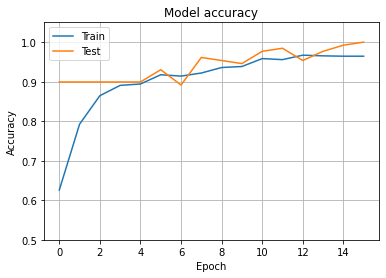

In [ ]:
plt.plot(result_list[study.best_trial.number].history["accuracy"])
plt.plot(result_list[study.best_trial.number].history["val_accuracy"])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Test"], loc="upper left")
plt.ylim(0.5, 1.05)
plt.grid()
plt.show()

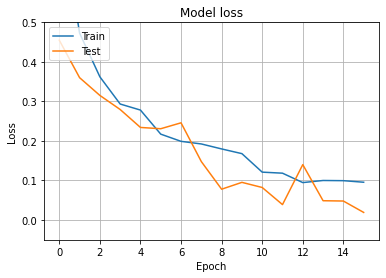

In [ ]:
plt.plot(result_list[study.best_trial.number].history["loss"])
plt.plot(result_list[study.best_trial.number].history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"], loc="upper left")
plt.ylim(-0.05, 0.5)
plt.grid()
plt.show()

In [ ]:
model_list[study.best_trial.number].save("kyogoku.h5")